In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:
tss_annotation = doc['tss_annotation']

In [3]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


In [4]:
data_folder = '../Processed/'

In [5]:
sys.path.append('/home/isshamie/software/homebrew/parallel_functions/')
import parallel_functions as pf

In [6]:
sys.path.append('/home/isshamie/software/NGS-Pipeline')

In [9]:
genome_ann_mrna = pd.read_csv(mrna_peak,sep='\t',index_col=0)

In [10]:
genome_ann_mrna.head()

Chr  Start    End  \
ID                                                                         
ID=asmbl_1;Parent=gene_1_1;gene_id=gene_1_1;gen...  picr_0      9     11   
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gen...  picr_0    175    177   
ID=asmbl_3;Parent=gene_1_3;gene_id=gene_1_3;gen...  picr_0   3879   3881   
ID=asmbl_5;Parent=gene_2;gene_id=gene_2;gene=RR...  picr_0  44541  44543   
ID=asmbl_6;Parent=gene_2;gene_id=gene_2;gene=RR...  picr_0  45911  45913   

                                                   Strand  
ID                                                         
ID=asmbl_1;Parent=gene_1_1;gene_id=gene_1_1;gen...      +  
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gen...      +  
ID=asmbl_3;Parent=gene_1_3;gene_id=gene_1_3;gen...      +  
ID=asmbl_5;Parent=gene_2;gene_id=gene_2;gene=RR...      -  
ID=asmbl_6;Parent=gene_2;gene_id=gene_2;gene=RR...      -

In [11]:
genome_ann_exon = pd.read_csv('/data/isshamie/TSS_CHO/exon.peak',sep='\t',index_col=0)

# For each gene ID, what is the distribution of number of exon peaks found across the gene body? 
Using genome annotation for exons, but our +/- 1kb for promoters (so we'll get some exons just by that virtue

#### Load in annotated peak and filter for exons

In [9]:
cho_mstart_anno = pd.read_csv('/data/isshamie/CH_tissue_TSS/CHO/mSTART/f06_annoPeaks/merge_bg_2.anno'
                              ,sep='\t',comment='#',index_col=0)
cho_mstart_anno.fillna('',inplace=True)
cho_mstart_exon = cho_mstart_anno[cho_mstart_anno['Annotation'].str.contains('exon ')]
cho_mstart_exon.head()

Chr     Start  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                       
Merged-picr_160-705648-2                            picr_160    705573   
Merged-picr_8-16510895-2                              picr_8  16510820   
Merged-picr_157-1228462-2                           picr_157   1228387   
Merged-picr_19-9310549-2                             picr_19   9310474   
Merged-picr_35-11035053-2                            picr_35  11034978   

                                                         End Strand  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                    
Merged-picr_160-705648-2                              705723      +   
Merged-picr_8-16510895-2                            16510970      -   
Merged-picr_157-1228462-2                            1228537      -   
Merged-picr_19-9310549-2                             9310624      +   
Merged-picr_35-11035053-2                           11035128      -   

                                                      Peak Score  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                 
Merged-picr_160-705648-2                            45987.101562   
Merged-picr_8-16510895-2                            11816.900391   
Merged-picr_157-1228462-2                            6019.100098   
Merged-picr_19-9310549-2                             3773.699951   
Merged-picr_35-11035053-2                            3525.899902   

                                                                              Focus Ratio/Region Size  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                                                      
Merged-picr_160-705648-2                            f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...   
Merged-picr_8-16510895-2                            f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...   
Merged-picr_157-1228462-2                           f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...   
Merged-picr_19-9310549-2                            f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...   
Merged-picr_35-11035053-2                           f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_a...   

                                                                                           Annotation  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                                                      
Merged-picr_160-705648-2                            exon (ID=asmbl_25152.exon1;Parent=asmbl_25152;...   
Merged-picr_8-16510895-2                            exon (ID=asmbl_77563.exon1;Parent=asmbl_77563;...   
Merged-picr_157-1228462-2                           exon (ID=asmbl_23604.exon6;Parent=asmbl_23604;...   
Merged-picr_19-9310549-2                            exon (ID=asmbl_28590.exon1;Parent=asmbl_28590;...   
Merged-picr_35-11035053-2                           exon (ID=asmbl_47948.exon1;Parent=asmbl_47948;...   

                                                   Detailed Annotation  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                       
Merged-picr_160-705648-2                                                 
Merged-picr_8-16510895-2                                                 
Merged-picr_157-1228462-2                                                
Merged-picr_19-9310549-2                                                 
Merged-picr_35-11035053-2                                                

                                                   Distance to TSS  \
PeakID (cmd=annotatePeaks.pl f04_peaks/merge_bg...                   
Merged-picr_160-705648-2                                       103   
Merged-picr_8-16510895-2                                       115   
Merged-picr_157-1228462-2                                    -1052   
Merged-picr_19-9310549-2                                       377   
Merged-picr_35-11035053-2                                    -3966   

                                                                                 

#### Load in geneCentric file example

In [10]:
gene_by_TSS = pd.read_csv('/data/isshamie/CH_tissue_TSS/CHO/mSTART/f06_annoPeaks/merge_bg_2.anno.geneCentric',index_col=0)
gene_by_TSS.dropna(axis=1,inplace=True) #Some unused columns
gene_by_TSS = gene_by_TSS[gene_by_TSS['hasPromoter']]

### Loop over tissues and types
#### Loop through each gene and add a column for number of exons found

In [87]:
def count_exons_by_TSS(f_gene_centric,f_peaks_annot,f_save=''):
    '''For each gene ID, what is the distribution of number of exon peaks found across the gene body?
    '''
    #### Load in geneCentric file
    curr_sample_anno = pd.read_csv(f_peaks_annot,sep='\t',comment='#',index_col=0)
    curr_sample_anno = curr_sample_anno.fillna('')
    curr_sample_exon = curr_sample_anno[curr_sample_anno['Annotation'].str.contains('exon ')]
    
    #### Loop through each gene and add a column for number of exons found
    gene_by_TSS = pd.read_csv(f_gene_centric,index_col=0)
    gene_by_TSS.dropna(axis=1,inplace=True) #Some unused columns
    gene_by_TSS = gene_by_TSS[gene_by_TSS['hasPromoter']]
    gene_by_TSS['Exon peaks'] = 0
    for ind,val in gene_by_TSS.iterrows():
        gene_by_TSS.set_value(ind,'Exon peaks',np.sum(curr_sample_exon['Annotation'].str.contains(ind)))

    #Save the gene_by_TSS
    gene_by_TSS.to_csv(f_gene_centric)

    #### Plot the distribution
    #Remove the top 99% exon peaks for some outliers 
    q = gene_by_TSS['Exon peaks'].quantile(0.99)
        
    #Plot the distribution of exons
    f = plt.figure()
    ax = f.add_subplot(111)
    sns.distplot(gene_by_TSS.loc[gene_by_TSS['Exon peaks']<q,'Exon peaks'],kde = False,axlabel='Number of exon peaks when gene has TSS');
    
    if not f_save == '':
        plt.savefig(f_save,bbox_inches='tight')
    plt.close()
    return gene_by_TSS

In [88]:
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_per_TSS/exon_per_TSS_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                count_exons_by_TSS(f_gene_centric,f_peaks_annot,f_save)
            else:
                print 'Files not here for %s_%s' %(curr_tissue,curr_type) 
    

BloondnegSpleen
GRO
mSTART
Files not here for BloondnegSpleen_mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
Files not here for Brain7neg1_mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Files not here for Intestine_mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Files not here for Skin_mSTART
Spleen
mSTART
Total
mSTART
Files not here for Total_mSTART
CHO
GRO
mSTART


In [150]:
def which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save=''):
    '''For each gene ID, what is the distribution of number of exon peaks found across the gene body?
    '''
    #### Load in geneCentric file
    curr_sample_anno = pd.read_csv(f_peaks_annot,sep='\t',comment='#',index_col=0)
    curr_sample_anno = curr_sample_anno.fillna('')
    curr_sample_exon = curr_sample_anno[curr_sample_anno['Annotation'].str.contains('exon ')]
    
    #Find which exon number relative to the gene was it
    all_exon_nums = curr_sample_exon['Annotation'].apply(lambda x: re.search(r'exon(\d+);',x).group(1))
    all_exon_nums = all_exon_nums.astype(int)
    over_20 = np.sum(all_exon_nums > 20)
    plot_all_exon_nums = all_exon_nums[all_exon_nums < 20]
    plot_all_exon_nums = np.append(np.array(plot_all_exon_nums),20*np.ones([over_20,]))

    fig, ax = plt.subplots()
    sns.distplot(plot_all_exon_nums,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    fig.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'

    ax.set_xticklabels(labels);
    ax.set_title('Which exon into the genes had peaks?')
    
    if not f_save == '':
        plt.savefig(f_save,bbox_inches='tight')
    plt.close()
    return plot_all_exon_nums

In [161]:
mstart_exons = []
gro_exons = []
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_positions/exon_positions_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                if curr_type == 'mSTART':
                    mstart_exons.append(which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save))
                else:
                    gro_exons.append(which_exon_peak_by_TSS(f_gene_centric,f_peaks_annot,f_save))
            else:
                print 'Files not here for %s_%s' %(curr_tissue,curr_type) 
    

BloondnegSpleen
GRO
mSTART
Files not here for BloondnegSpleen_mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
Files not here for Brain7neg1_mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Files not here for Intestine_mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Files not here for Skin_mSTART
Spleen
mSTART
Total
mSTART
Files not here for Total_mSTART
CHO
GRO
mSTART


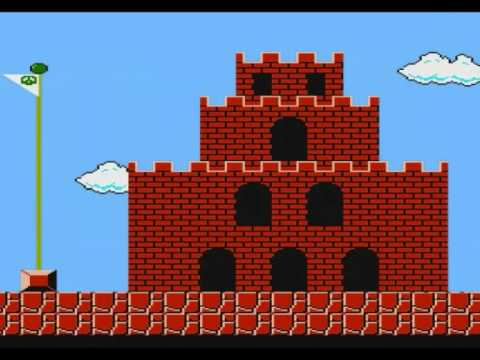

In [117]:
from IPython.display import Image
Image(filename='/home/isshamie/mario_chapter.jpg',width=600)

### Read in and plot based on Type and tissue

In [8]:
all_list = []
all_exons = pd.DataFrame()
for curr_tissue in tissues: 
    i = '/data/isshamie/CH_tissue_TSS/' + curr_tissue    
    print curr_tissue
    curr_raw = glob.glob(i + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        print curr_type
        if not curr_type == 'ATAC':
            count = 1
            f_gene_centric  = j + 'f06_annoPeaks/merge_bg_2.anno.geneCentric'
            f_peaks_annot = j + 'f06_annoPeaks/merge_bg_2.anno'
            f_save = 'Results/Figures/exons_per_TSS/exon_per_TSS_%s_%s.png' % (curr_tissue,curr_type)
            if os.path.isfile(f_peaks_annot) and os.path.isfile(f_gene_centric):
                all_list.append((curr_type,curr_tissue))
                curr = pd.read_csv(f_gene_centric,index_col=0)
                all_exons = all_exons.append(curr['Exon peaks'].transpose())
index = pd.MultiIndex.from_tuples(all_list, names=['type', 'tissue'])
all_exons.index = index


BloondnegSpleen
GRO
mSTART
ATAC
BMDM1hKLA1
GRO
ATAC
BMDMwt
GRO
ATAC
Brain
GRO
mSTART
ATAC
Brain7neg1
mSTART
FemaleReproductive
mSTART
Heart
mSTART
Intestine
mSTART
Kidney
GRO
mSTART
ATAC
Liver
GRO
mSTART
ATAC
Lung
GRO
mSTART
ATAC
MiscOrgans
mSTART
Muscle
mSTART
Pancreas
mSTART
Skin
mSTART
Spleen
mSTART
Total
mSTART
CHO
GRO
mSTART


GRO
mSTART


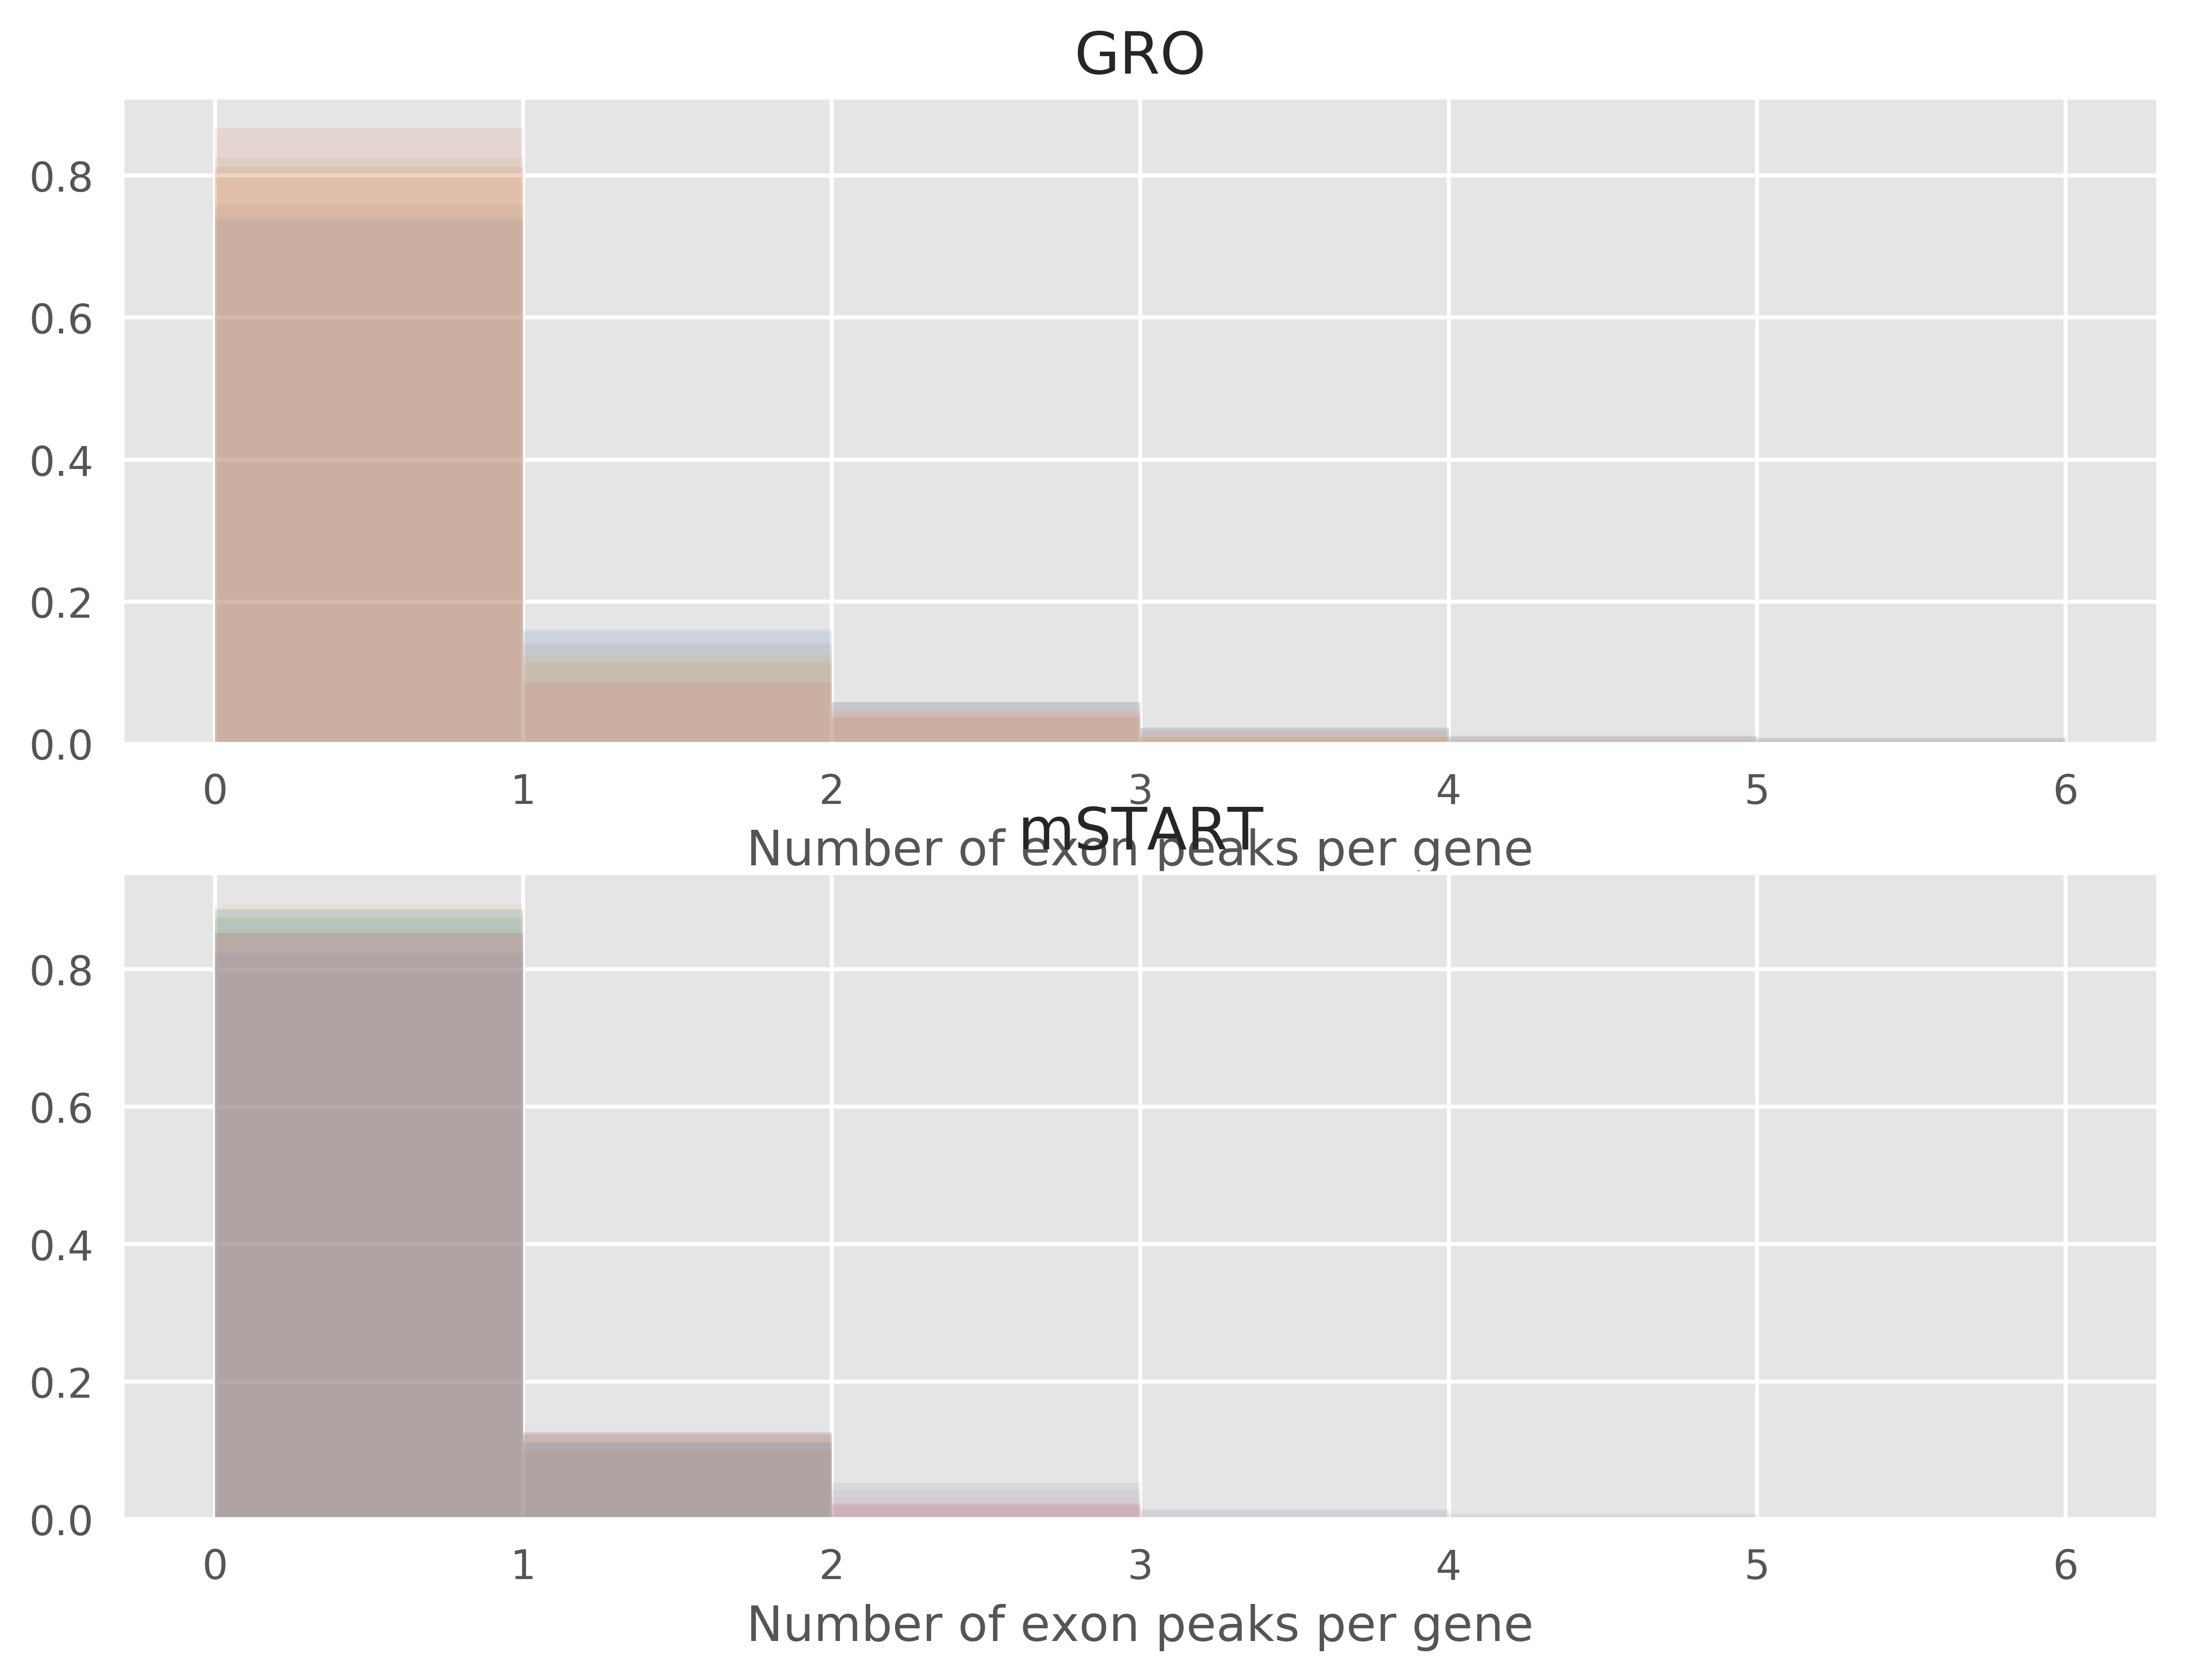

In [23]:
f = plt.figure(dpi=300)

num_types = len(set(all_exons.index.get_level_values('type')))

curr = 1
bins = np.linspace(0, 6, 7)

for ind,val in all_exons.groupby('type'):
    
    print ind
    ax = f.add_subplot(num_types,1,curr)
    for ind2,val2 in val.iterrows():
        q = np.percentile(val2.dropna(),99)
        tmp = val2.dropna()
        tmp = tmp[tmp<q]
        weights = np.ones_like(tmp)/float(len(tmp))
        
        ax.hist(tmp,weights=weights,bins=bins,alpha=0.1)
        
    ax.set_title(ind);
    ax.set_xlabel("Number of exon peaks per gene")
    curr += 1

plt.savefig('Results/Figures/exon_peak_numbers.png')
#f.close()
    

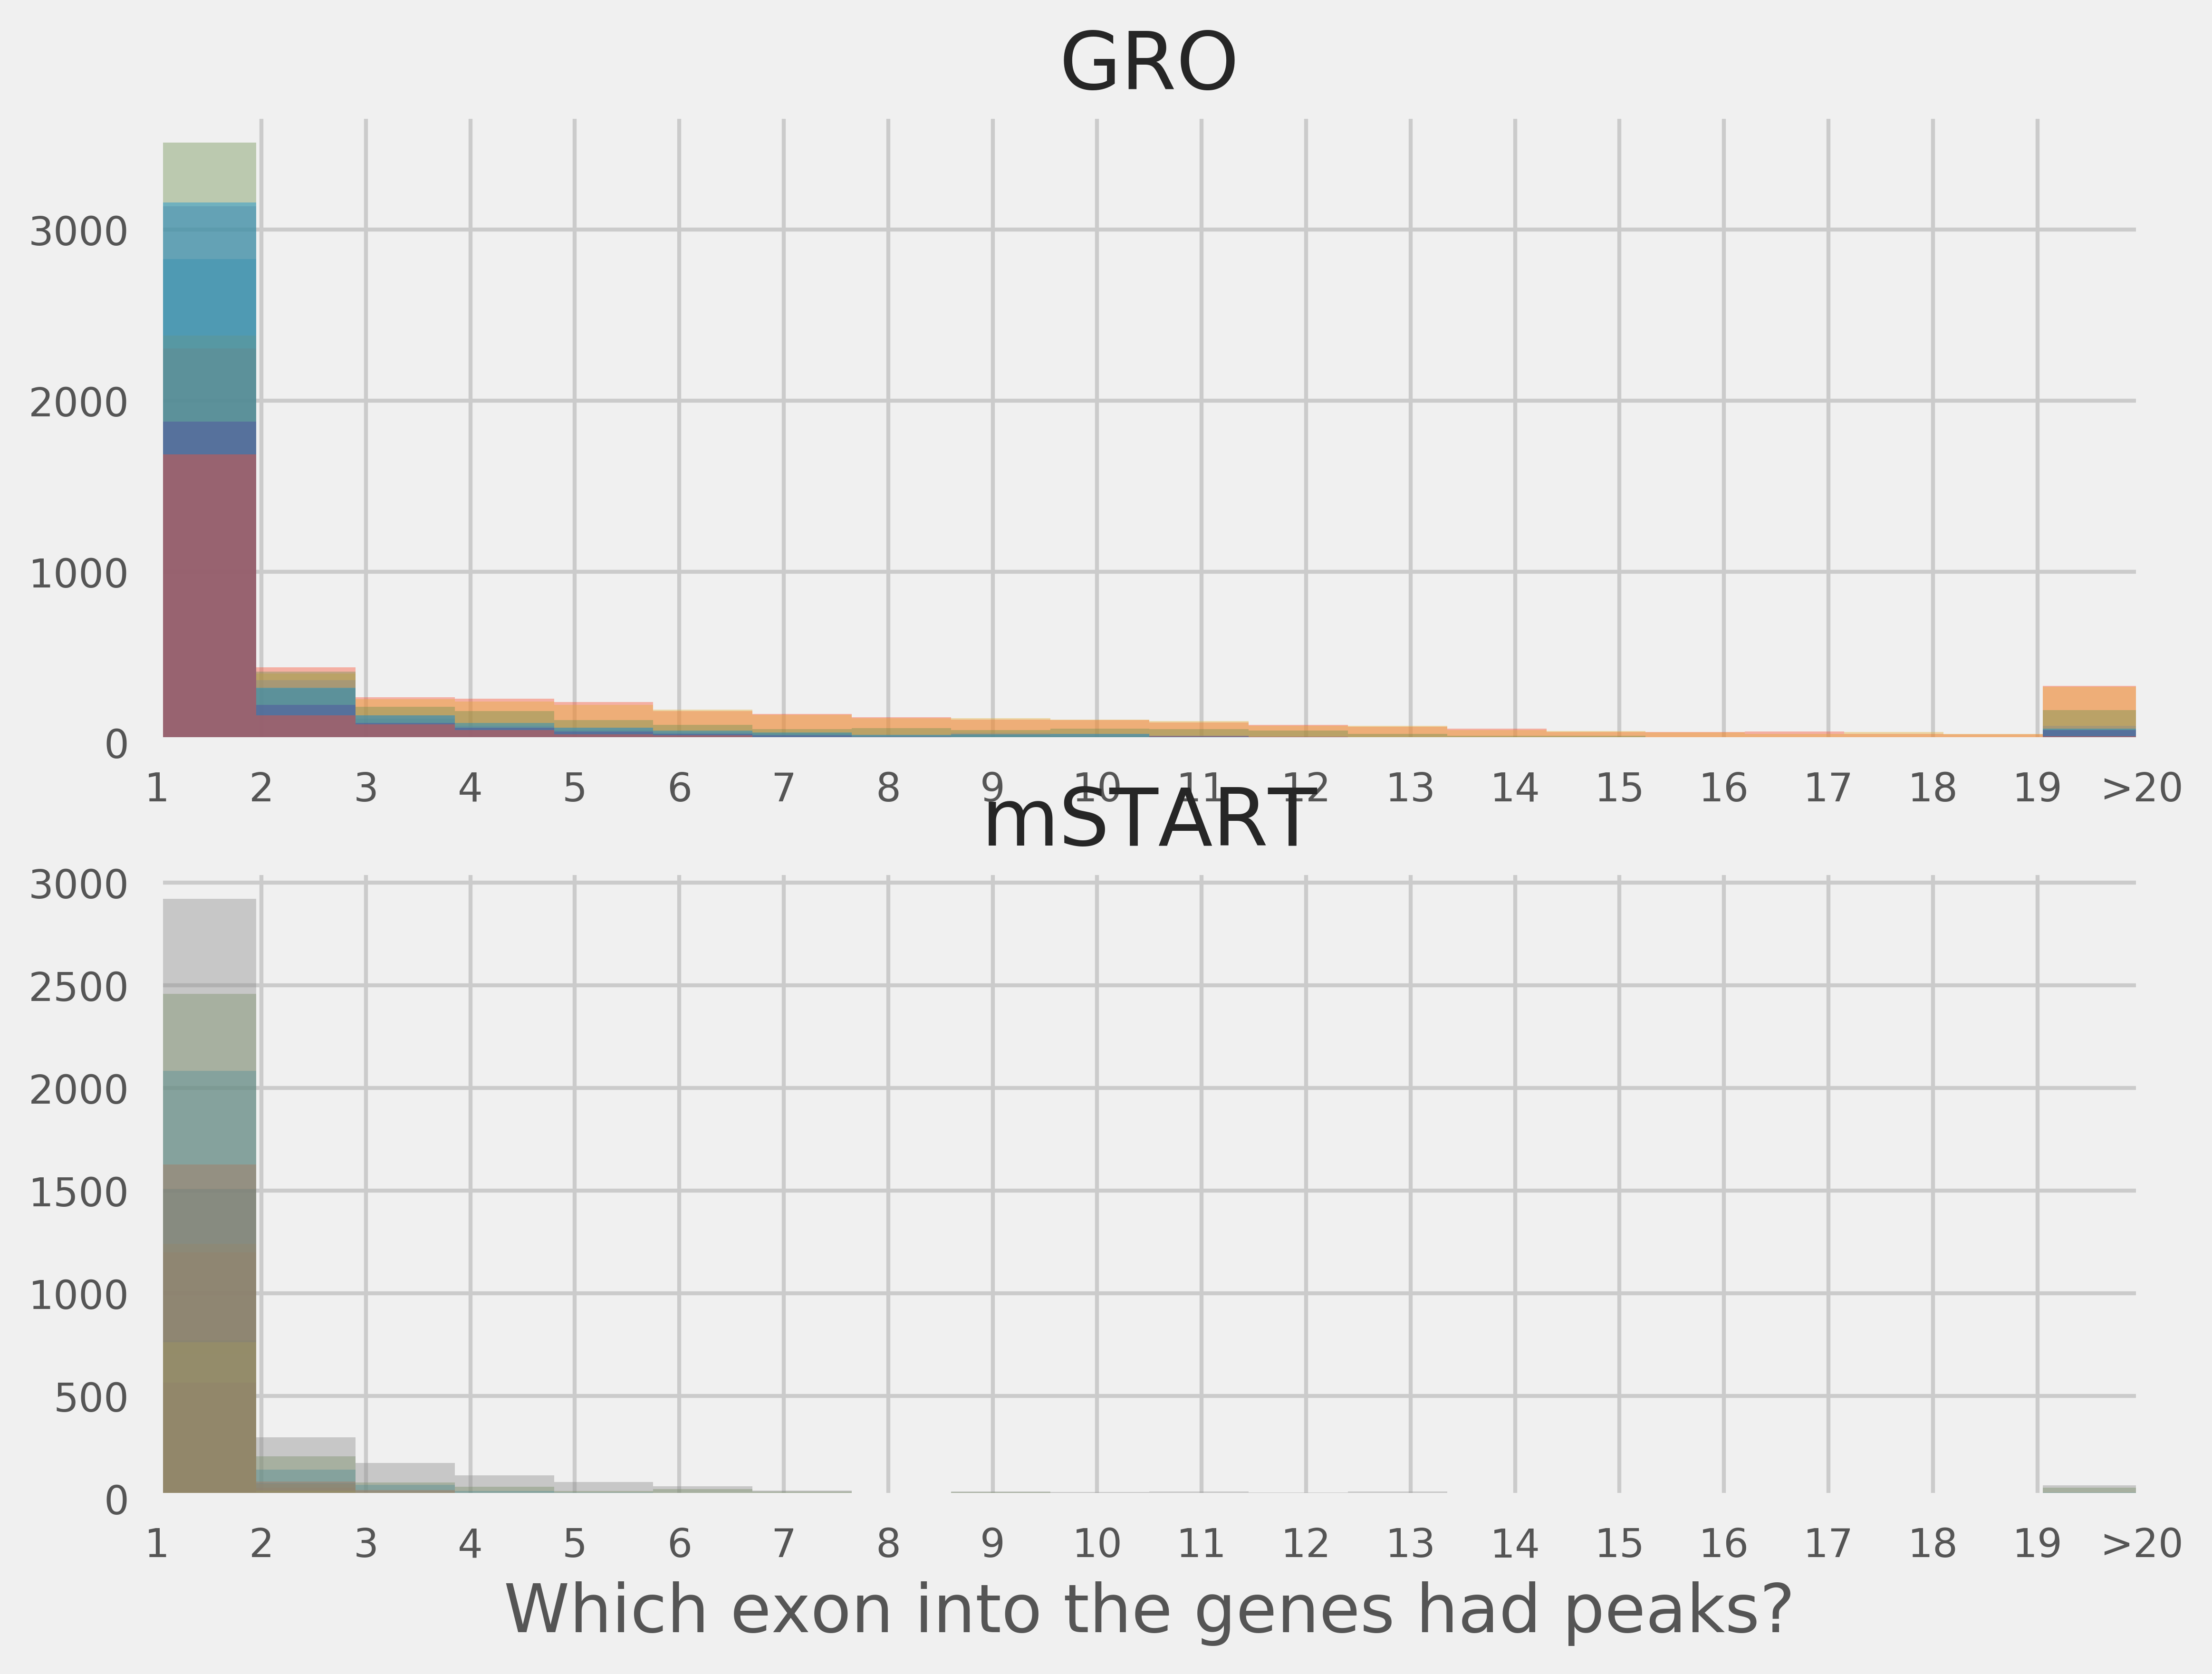

In [160]:
f = plt.figure(dpi=300)


#bins = np.linspace(0, 6, 7)    

ax = f.add_subplot(2,1,1)
for val in gro_exons:
    #ax.hist(val,weights=weights,bins=bins,alpha=0.1)
    #fig, ax = plt.subplots()
    sns.distplot(val,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    f.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'
    ax.set_xticklabels(labels);
    ax.set_title('GRO')

ax = f.add_subplot(2,1,2)
for val in mstart_exons:
    
    sns.distplot(val,kde=False,bins=20)#,axlabel='')
    ax.set_xlim([1,20])
    ax.set_xticks(range(1,20+1));

    f.canvas.draw() #Fix plot 
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[-1] = '>20'

    ax.set_xticklabels(labels);
    ax.set_xlabel('Which exon into the genes had peaks?')    
    ax.set_title('mSTART')
plt.savefig('Results/Figures/exon_into_gene_numbers.png',bbox_inches='tight')

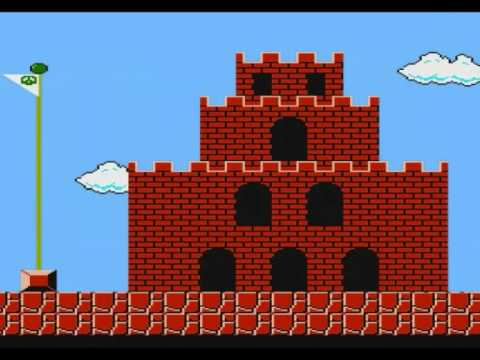

In [117]:
from IPython.display import Image
Image(filename='/home/isshamie/mario_chapter.jpg',width=600)

# Metagene plot using deepTools

In [ ]:
def run_heatmap(bed,bigwig,outfile,dist=2000,numProc=6,
                dispImage = False,computeMat_args = '',plotHeat_args = ''
               is_tss_f = ''):
    
    
    cmd = 'computeMatrix reference-point -S {bw} -R {bd} -a {d} -b {d} -out {out} --numberOfProcessors {p} {args}'.format(
        bw=bigwig, bd = tss_bed,d=dist,out=outfile,p=numProc,args=computeMat_args)
    print(cmd)
    !{cmd}   
    
    cmd = """plotHeatmap\
     -m {out}\
     -out {out}.png \
     --heatmapHeight 15  \
     --refPointLabel TSS.center \
     --regionsLabel TSS \
     --plotTitle 'ATAC signal' {args}""".format(out=outfile,args = plotHeat_args)

    print(cmd)
    !{cmd}
    
    
    if dispImage:
        return Image(filename=outfile + '.png')
    return

In [16]:
cmd = '''\
computeMatrix scale-regions -S \
../Processed/CHO/GRO/bedgraph_files/trim_CHO-5GRO-SD367_S6_R1_001.bedgraph.gz \
-R ../Processed/CHO/GRO/bed_files/merge_bg_2.anno_promoter.bed \
-out Results/gene_body_coverage/tmp --numberOfProcessors 4\
'''
cmd

'computeMatrix scale-regions -S ../Processed/CHO/GRO/bedgraph_files/trim_CHO-5GRO-SD367_S6_R1_001.bedgraph.gz -R ../Processed/CHO/GRO/bed_files/merge_bg_2.anno_promoter.bed -out Results/gene_body_coverage/tmp --numberOfProcessors 4'

### Loop through the bedgraph files and convert to bigwig using bedGraphToBigWig

In [ ]:
## Function to get into right order for deepTools

# gunzip -c {f} > {f.replace('.gz','')}
# sed -i '/type=bedGraph/d' trim_CHO-5GRO-SD367_S6_R1_001.bedgraph
# sort -k1,1 -k2,2n trim_CHO-5GRO-SD367_S6_R1_001.bedgraph -o trim_CHO-5GRO-SD367_S6_R1_001.bedgraph

# bedGraphToBigWig input /data/isshamie/genome/chrom.sizes input.replace('bedGraph','bw')
# tr ' ' \\t < trim_CHO-5GRO-SD367_S6_R1_001.bedgraph  > trim_CHO-5GRO-SD367_S6_R1_001.bedgraph_tab

## latest error is : Overlapping regions in bedGraph line 183 of trim_CHO-5GRO-SD367_S6_R1_001.bedgraph
# This is b/c some regions there may be both pos and neg (-strand )values. Probably want to pick the one with max abs value. 
# Also, since the fragments are length 1, we can just use the 2nd column and see if same, then remove the min


In [ ]:
def remove_overlap_bedgraph_regions(f_in,f_out):
    '''To convert to bigWig using bigWigToBedGraph, there is this problem where if the pos and neg values (+/- strand) overlap
    regions, it cannot convert the file. This function will remedy this by looking at the overlappinng regions
    and take the strand that has the higher absolute value (sinnce - strand is negative)
    
    Input: 
    f_in: Input uncompressed and sorted bedgraph file. Also assumes the fragment length is 1 like for TSS data
    f_out: File to save to. Will probably be the same'''
    
    
    #Load file
    df = pd.read_csv(f_in,sep='\t',header=None)
    df.columns = ['Chr','Start','End','Score']
    df['Start'] - df['Start']
    df['diff'] = df['Start'] - df['Start'].shift(-1) == 0

In [33]:
f_in = '/data/isshamie/TSS/Processed/CHO/GRO/bedgraph_files/trim_CHO-5GRO-SD367_S6_R1_001.bedgraph_tab'
df = pd.read_csv(f_in,sep='\t',header=None)#,nrows=10)

df.columns = ['Chr','Start','End','Score']
df['Start'] - df['Start']
df['diff'] = df['Start'] - df['Start'].shift(-1) == 0
df.head()

Chr  Start    End  Score   diff
0  picr_0   2060   2061   1.51  False
1  picr_0  11919  11920   1.51  False
2  picr_0  19115  19116  -1.51  False
3  picr_0  20206  20207  -1.51  False
4  picr_0  20227  20228   1.51  False

In [56]:
inds = np.flatnonzero(df['diff'] == True)
c = np.vstack((inds,inds+1)).reshape((-1,),order='F')
df.iloc[c]

Chr    Start      End  Score   diff
181       picr_0    20879    20880   1.51   True
182       picr_0    20879    20880  -3.01  False
284       picr_0    21023    21024  -1.51   True
285       picr_0    21023    21024   6.02  False
306       picr_0    21139    21140  -3.01   True
307       picr_0    21139    21140   3.01  False
310       picr_0    21179    21180   1.51   True
311       picr_0    21179    21180  -3.01  False
344       picr_0    21406    21407  -1.51   True
345       picr_0    21406    21407   1.51  False
357       picr_0    21676    21677  -1.51   True
358       picr_0    21676    21677   1.51  False
557       picr_0    44859    44860  -1.51   True
558       picr_0    44859    44860   4.52  False
992       picr_0    78632    78633  -1.51   True
993       picr_0    78632    78633  18.06  False
1029      picr_0    78674    78675  15.05   True
1030      picr_0    78674    78675  -1.51  False
1268      picr_0    79359    79360   1.51   True
1269      picr_0    79359    79360  -3.01  False
1344      picr_0    83540    83541  -1.51   True
1345      picr_0    83540    83541   1.51  False
1699      picr_0   120550   120551   1.51   True
1700      picr_0   120550   120551  -3.01  False
1741      picr_0   120723   120724  -1.51   True
1742      picr_0   120723   120724   1.51  False
1765      picr_0   120765   120766  -1.51   True
1766      picr_0   120765   120766   3.01  False
1779      picr_0   120853   120854  -1.51   True
1780      picr_0   120853   120854   9.03  False
...          ...      ...      ...    ...    ...
6835092  picr_99  4131103  4131104  -1.51   True
6835093  picr_99  4131103  4131104   3.01  False
6835102  picr_99  4131126  4131127   1.51   True
6835103  picr_99  4131126  4131127  -4.52  False
6835109  picr_99  4131133  4131134   3.01   True
6835110  picr_99  4131133  4131134  -7.53  False
6835263  picr_99  4148543  4148544   1.51   True
6835264  picr_99  4148543  4148544  -3.01  False
6835449  picr_99  4149852  4149853  -1.51   True
6835450  picr_99  4149852  4149853   1.51  False
6835471  picr_99  4149992  4149993  -1.51   True
6835472  picr_99  4149992  4149993   3.01  False
6835481  picr_99  4150064  4150065  -1.51   True
6835482  picr_99  4150064  4150065   1.51  False
6835499  picr_99  4150113  4150114   1.51   True
6835500  picr_99  4150113  4150114  -7.53  False
6835547  picr_99  4150221  4150222  -1.51   True
6835548  picr_99  4150221  4150222   3.01  False
6835554  picr_99  4150233  4150234   1.51   True
6835555  picr_99  4150233  4150234  -4.52  False
6835559  picr_99  4150237  4150238   1.51   True
6835560  picr_99  4150237  4150238  -3.01  False
6835563  picr_99  4150240  4150241  -1.51   True
6835564  picr_99  4150240  4150241   1.51  False
6835575  picr_99  4150258  4150259  -1.51   True
6835576  picr_99  4150258  4150259   1.51  False
6836602  picr_99  6824393  6824394  -1.51   True
6836603  picr_99  6824393  6824394   3.01  False
6836612  picr_99  6824453  6824454  -1.51   True
6836613  picr_99  6824453  6824454   4.52  False

[153896 rows x 5 columns]

In [64]:
for ind,val in df.loc[c].iterrows():

    if np.abs(df.loc[ind,'Score']) > np.abs(df.loc[ind+1,'Score']):
        print df.loc[ind,'Score']
    


6.02
-3.01
4.52
15.05
-3.01
9.03
9.03
-6.02
10.54
3.01
3.01
12.04
3.01
-3.01
4.52
10.54
-6.02
-3.01
-6.02
3.01
-12.04
-3.01
3.01
3.01
6.02
-7.53
-4.52
-15.05
-24.08
12.04
4.52
-4.52
138.49
13.55
-6.02
6.02
3.01
-3.01
15.05
13.55
-3.01
3.01
7.53
6.02
21.07
-4.52
-3.01
-3.01
-12.04
-6.02
3.01
12.04
-6.02
-3.01
-4.52
-4.52
-6.02
-3.01
4.52
-4.52
-6.02
3.01
6.02
3.01
4.52
37.63
3.01
-6.02
-3.01
-3.01
4.52
-7.53
-10.54
4.52
4.52
4.52
12.04
-3.01
-13.55
-6.02
12.04
3.01
3.01
3.01
3.01
-6.02
-121.93
3.01
-6.02
12.04
-6.02
4.52
-16.56
-6.02
13.55
-7.53
6.02
-4.52
28.6
16.56
-4.52
37.63
-4.52
-13.55
3.01
-4.52
3.01
-3.01
4.52
21.07
4.52
4.52
3.01
3.01
4.52
-3.01
4.52
6.02
-3.01
3.01
12.04
3.01
6.02
4.52
3.01
6.02
6.02
-6.02
6.02
6.02
-4.52
4.52
-7.53
9.03
3.01
-12.04
-10.54
-4.52
6.02
-9.03
3.01
-13.55
3.01
-6.02
21.07
16.56
-3.01
16.56
-3.01
13.55
9.03
-22.58
-4.52
-9.03
10.54
3.01
12.04
3.01
-7.53
3.01
-6.02
9.03
6.02
-3.01
3.01
-3.01
-4.52
-3.01
4.52
-3.01
6.02
-10.54
-7.53
-3.01
4.52
10.54


-18.07
-4.52
3.01
-6.02
4.52
-6.02
4.52
6.02
3.01
6.02
4.52
3.01
4.52
-4.52
-9.03
7.53
12.04
-3.01
3.01
-7.53
7.53
-18.07
4.52
3.01
-13.55
3.01
4.52
4.52
-3.01
4.52
3.01
3.01
4.52
-3.01
12.04
30.11
12.04
-9.03
3.01
-3.01
13.55
46.67
16.56
-3.01
7.53
7.53
7.53
3.01
4.52
-4.52
-6.02
-3.01
10.54
-4.52
-3.01
13.55
-18.07
3.01
-9.03
-3.01
-3.01
10.54
-9.03
4.52
3.01
-9.03
-9.03
9.03
-4.52
-3.01
4.52
9.03
-9.03
3.01
-3.01
3.01
-3.01
36.13
4.52
12.04
-3.01
-3.01
34.62
-4.52
-4.52
-3.01
3.01
108.38
10.54
-7.53
39.14
10.54
6.02
4.52
3.01
4.52
-4.52
72.26
46.67
-3.01
12.04
-9.03
4.52
-10.54
10.54
4.52
10.54
3.01
25.59
7.53
3.01
6.02
-3.01
10.54
12.04
7.53
19.57
6.02
3.01
7.53
4.52
3.01
7.53
6.02
-4.52
-7.53
-3.01
-3.01
3.01
-16.56
3.01
-3.01
-45.16
-19.57
12.04
-7.53
-3.01
-9.03
-10.54
-15.05
3.01
-3.01
6.02
-3.01
-3.01
3.01
6.02
-6.02
-15.05
7.53
-12.04
3.01
-4.52
-3.01
-3.01
-9.03
7.53
-6.02
9.03
3.01
-3.01
3.01
-4.52
-15.05
3.01
-4.52
-6.02
4.52
4.52
6.02
3.01
4.52
12.04
-4.52
-6.02
-6.02
18.

4.52
13.55
-3.01
-7.53
4.52
-6.02
9.03
-3.01
-3.01
-4.52
-3.01
1.51
1.51
3.01
1.51
3.01
3.01
3.01
1.51
1.51
3.01
1.51
10.54
4.52
-6.02
1.51
3.01
-58.71
36.13
7.53
3.01
6.02
7.53
-3.01
1.51
-6.02
-4.52
-7.53
-3.01
4.52
4.52
3.01
7.53
-7.53
3.01
10.54
1.51
3.01
-3.01
1.51
9.03
7.53
4.52
12.04
-3.01
69.24
-4.52
4.52
31.61
-3.01
-3.01
-3.01
-6.02
-3.01
13.55
-3.01
4.52
1.51
3.01
-3.01
4.52
7.53
-6.02
-22.58
3.01
-3.01
1.51
-4.52
15.05
1.51
1.51
12.04
7.53
3.01
-3.01
3.01
-73.76
3.01
-3.01
3.01
4.52
1.51
4.52
-9.03
4.52
-3.01
-3.01
-4.52
-3.01
-111.39
-4.52
-9.03
-16.56
7.53
-9.03
-3.01
-3.01
-3.01
-16.56
4.52
15.05
4.52
-3.01
4.52
3.01
3.01
6.02
4.52
3.01
-3.01
-19.57
6.02
3.01
7.53
-18.06
-18.06
3.01
6.02
4.52
-13.55
3.01
4.52
4.52
-4.52
3.01
3.01
6.02
-7.53
-6.02
-12.04
-3.01
-6.02
3.01
4.52
-6.02
1.51
-3.01
6.02
-4.52
4.52
15.05
-42.15
-16.56
-6.02
-7.53
-3.01
4.52
-3.01
-3.01
3.01
9.03
1.51
-39.14
1.51
-7.53
-4.52
4.52
-6.02
-19.57
-58.71
1.51
1.51
3.01
-3.01
-15.05
-3.01
-16.56
12.04


-15.05
15.05
-10.54
7.53
-45.16
7.53
1.51
4.52
4.52
-13.55
3.01
-10.54
7.53
3.01
-4.52
1.51
-3.01
4.52
-3.01
1.51
1.51
1.51
6.02
-4.52
-6.02
1.51
-6.02
3.01
3.01
3.01
4.52
4.52
-6.02
13.55
1.51
-3.01
1.51
3.01
3.01
6.02
1.51
-9.03
1.51
-3.01
-4.52
-12.04
3.01
-4.52
-9.03
7.53
28.6
-9.03
-4.52
-4.52
4.52
1.51
1.51
-9.03
1.51
3.01
3.01
-3.01
3.01
-3.01
16.56
-3.01
6.02
43.65
3.01
7.53
10.54
3.01
1.51
-3.01
-10.54
3.01
3.01
1.51
-4.51
3.01
1.51
1.51
12.04
-4.51
-13.55
-3.01
6.02
10.54
4.52
-3.01
1.51
-6.02
13.55
12.04
13.55
24.08
-7.53
-21.07
36.13
-6.02
-3.01
-19.57
-7.53
-15.05
3.01
-4.51
3.01
1.51
3.01
3.01
13.55
-3.01
-3.01
1.51
1.51
-3.01
3.01
1.51
-7.53
1.51
3.01
-3.01
-12.04
-3.01
-4.52
-13.55
1.51
7.53
3.01
3.01
-4.52
1.51
-9.03
-31.61
10.54
9.03
3.01
-27.09
-36.13
4.52
-9.03
-15.05
6.02
-15.05
-4.52
-3.01
-3.01
-6.02
1.51
1.51
1.51
3.01
-3.01
-3.01
3.01
1.51
4.52
-3.01
1.51
1.51
1.51
3.01
1.51
1.51
7.53
1.51
1.51
10.54
3.01
130.96
13.55
3.01
-7.53
1.51
3.01
1.51
6.02
-3.01
3.01
2

-10.54
-3.01
-4.52
9.03
4.52
6.02
3.01
-21.07
-3.01
3.01
3.01
-3.01
3.01
-4.52
-7.53
-4.52
-3.01
-10.54
-7.53
-7.53
7.53
-1.51
6.02
-3.01
4.52
4.52
6.02
9.03
-1.51
-4.52
3.01
4.52
4.52
-1.51
-3.01
6.02
4.52
-3.01
-1.51
-1.51
-9.03
9.03
6.02
7.53
-3.01
-4.52
-3.01
-10.54
3.01
4.52
-4.52
3.01
3.01
-40.64
-4.52
7.53
3.01
4.52
-4.52
-7.53
4.52
3.01
3.01
-27.1
6.02
6.02
3.01
3.01
-6.02
-3.01
4.52
6.02
4.52
-3.01
-16.56
3.01
-6.02
4.52
6.02
18.06
-7.53
-3.01
3.01
-6.02
3.01
31.61
6.02
10.54
10.54
-4.52
4.52
-3.01
3.01
-7.53
3.01
-9.03
-3.01
-3.01
6.02
-6.02
3.01
6.02
-49.68
4.52
-15.05
-6.02
-51.18
7.53
3.01
7.53
-49.68
6.02
-4.52
4.52
-3.01
4.52
-15.05
-3.01
7.53
-10.54
4.52
3.01
4.52
6.02
-6.02
18.06
-19.57
-3.01
13.55
-3.01
3.01
-6.02
-4.52
16.56
-4.52
3.01
16.56
58.71
28.6
16.56
-3.01
19.57
-6.02
9.03
-4.52
-10.54
-13.55
7.53
7.53
7.53
3.01
4.52
10.54
13.55
-6.02
-3.01
3.01
-10.54
-3.01
7.53
27.1
-3.01
9.03
-7.53
-30.11
-24.09
6.02
-12.04
10.54
-24.09
-9.03
-13.55
-6.02
105.37
16.56
9.03

12.04
10.54
6.02
3.01
4.52
-4.52
37.63
-9.03
-7.53
-3.01
6.02
-7.53
13.55
3.01
3.01
3.01
-4.52
-31.61
3.01
3.01
10.54
-4.52
-3.01
4.52
-19.57
4.52
15.05
-3.01
-4.52
-3.01
-4.52
-10.54
-111.39
6.02
3.01
4.52
3.01
-3.01
-4.52
9.03
36.13
-3.01
22.58
6.02
6.02
10.54
-7.53
13.55
7.53
-9.03
-3.01
-13.55
-7.53
3.01
-3.01
-4.52
3.01
-3.01
-22.58
-3.01
-4.52
-7.53
6.02
24.08
27.1
15.05
6.02
-3.01
-7.53
-4.52
3.01
-3.01
10.54
3.01
13.55
3.01
-19.57
3.01
-7.53
9.03
177.63
24.09
10.54
3.01
-9.03
-3.01
4.52
7.53
3.01
45.16
9.03
7.53
-10.54
19.57
-13.55
-15.05
-3.01
-3.01
-6.02
1.51
-3.01
3.01
-3.01
3.01
-7.53
-10.54
3.01
4.52
-15.05
-4.52
18.06
-3.01
-4.52
-12.04
-3.01
6.02
-3.01
-117.41
4.52
-3.01
30.11
3.01
7.53
4.52
-10.54
6.02
-4.52
3.01
3.01
3.01
-4.52
-10.54
-3.01
4.52
3.01
6.02
3.01
-7.53
-3.01
-3.01
22.58
-3.01
3.01
-7.53
39.14
67.74
3.01
-4.52
-9.03
-3.01
3.01
3.01
3.01
7.53
-4.52
3.01
16.56
3.01
-7.53
-22.58
4.52
-10.54
3.01
4.52
-4.52
7.53
-3.01
-16.56
4.52
-16.56
3.01
13.55
-4.52
-15.05

4.52
-24.08
3.01
-3.01
7.53
3.01
-4.52
3.01
6.02
4.52
6.02
9.03
9.03
43.65
-4.52
3.01
-4.52
-3.01
-4.52
-4.52
-3.01
16.56
12.04
-3.01
7.53
4.52
-3.01
4.52
-3.01
-4.52
13.55
12.04
-3.01
48.17
10.54
10.54
3.01
-9.03
3.01
3.01
4.52
-6.02
-4.52
-4.52
-7.53
3.01
-13.55
-3.01
4.52
-4.52
-4.52
-15.05
-13.55
12.04
-6.02
-3.01
6.02
-10.54
-4.52
27.1
3.01
-4.52
4.52
3.01
3.01
-16.56
-6.02
3.01
7.53
7.53
-6.02
6.02
-3.01
3.01
-3.01
10.54
-3.01
9.03
-4.52
3.01
-10.54
6.02
33.12
-15.05
-9.03
10.54
82.79
9.03
-13.55
-13.55
-7.53
-4.52
51.18
12.04
3.01
7.53
-10.54
6.02
3.01
-3.01
4.52
-3.01
3.01
6.02
-4.52
-4.52
4.52
3.01
-6.02
-4.52
19.57
3.01
7.53
-3.01
3.01
-82.79
3.01
-4.52
7.53
9.03
-6.02
3.01
-9.03
3.01
-3.01
-4.52
4.52
-6.02
-3.01
-4.52
3.01
-10.54
-22.58
-3.01
-4.52
3.01
16.56
4.52
9.03
-3.01
-3.01
4.52
-15.05
4.52
-16.56
-13.55
-4.52
3.01
-3.01
-3.01
-3.01
7.53
-3.01
-9.03
-24.08
4.52
-3.01
3.01
19.57
3.01
3.01
4.52
13.55
4.52
-4.52
7.53
-15.05
-9.03
-6.02
-7.53
-6.02
4.52
4.52
-3.01
48.17
-

-6.02
7.53
-4.52
4.52
3.01
4.52
4.52
4.52
-7.53
-7.53
3.01
4.52
18.06
10.54
15.05
4.52
-7.53
4.52
-3.01
6.02
-7.53
-3.01
-6.02
46.66
9.03
-3.01
4.52
4.52
3.01
-3.01
-3.01
16.56
-4.52
3.01
-3.01
10.54
-7.53
10.54
-4.52
9.03
16.56
12.04
4.52
-6.02
3.01
-3.01
-10.54
3.01
3.01
-3.01
-3.01
3.01
33.12
-3.01
-10.54
-16.56
3.01
-3.01
31.61
3.01
-9.03
12.04
-4.52
10.54
-6.02
7.53
-3.01
-4.52
6.02
4.52
-15.05
-4.52
3.01
-6.02
4.52
3.01
-16.56
4.52
-6.02
40.64
4.52
-3.01
-4.52
-3.01
3.01
3.01
9.03
4.52
-4.52
19.57
-10.54
7.53
-3.01
-18.06
-4.52
-66.23
-15.05
-42.15
-3.01
-16.56
12.04
-3.01
13.55
-69.24
-12.04
-4.52
6.02
13.55
9.03
10.54
-4.52
-3.01
-4.52
3.01
3.01
3.01
-3.01
-3.01
-4.52
13.55
4.52
3.01
-4.52
4.52
4.52
-3.01
4.52
6.02
-3.01
-3.01
-9.03
-6.02
-6.02
4.52
3.01
-1.51
12.04
3.01
-1.51
3.01
3.01
4.52
-1.51
-1.51
-3.01
-1.51
-7.53
-1.51
4.52
-3.01
18.06
-4.52
3.01
13.55
3.01
-6.02
-1.51
-12.04
3.01
-9.03
-27.1
-52.69
3.01
4.52
4.52
-1.51
-13.55
-1.51
-13.55
30.11
-4.52
3.01
12.04
-1.51
1

-4.52
-3.01
15.05
-36.13
-9.03
3.01
3.01
-7.53
4.52
15.05
73.76
3.01
3.01
-4.52
-4.52
-3.01
3.01
-3.01
3.01
12.04
-3.01
-7.53
3.01
3.01
-4.52
-4.52
-6.02
-9.03
3.01
-45.16
-36.13
-15.06
-18.07
3.01
25.59
3.01
3.01
-3.01
9.03
-12.04
3.01
-4.52
-6.02
3.01
-72.26
6.02
-25.59
3.01
-13.55
9.03
-4.52
10.54
-7.53
4.52
-4.52
-12.04
6.02
3.01
-3.01
3.01
7.53
-3.01
3.01
-3.01
9.03
-6.02
-15.06
-12.04
3.01
10.54
-9.03
-6.02
-3.01
4.52
7.53
4.52
-25.59
-3.01
-6.02
9.03
-3.01
3.01
-3.01
4.52
-3.01
-3.01
-4.52
-10.54
4.52
-4.52
10.54
-4.52
3.01
4.52
-13.55
9.03
-9.03
-6.02
22.58
-4.52
-7.53
3.01
-7.53
3.01
-13.55
-6.02
3.01
22.58
3.01
-3.01
-12.04
3.01
-3.01
-3.01
4.52
-3.01
-3.01
-3.01
4.52
4.52
22.58
4.52
-4.52
10.54
-4.52
-3.01
4.52
3.01
10.54
4.52
3.01
3.01
3.01
-6.02
-1.51
7.53
-1.51
3.01
-4.52
-3.01
-1.51
-10.54
4.52
4.52
-4.52
3.01
-3.01
-3.01
6.02
3.01
-4.52
-3.01
-9.03
-3.01
78.28
-6.02
-10.54
-4.52
3.01
3.01
3.01
-10.54
3.01
3.01
4.52
-3.01
3.01
3.01
-36.13
-3.01
3.01
-3.01
3.01
3.01
4.52


31.61
12.04
43.65
-70.75
-7.53
6.02
7.53
3.01
4.52
-4.52
-6.02
-1.51
10.54
19.57
-3.01
-4.52
-6.02
-42.15
-15.05
3.01
15.05
-4.52
4.52
15.05
-1.51
7.53
28.6
12.04
-1.51
-7.53
3.01
-4.52
4.52
4.52
-7.53
-1.51
3.01
-1.51
-3.01
-4.52
3.01
4.52
3.01
-3.01
3.01
3.01
3.01
-7.53
3.01
-1.51
-1.51
-4.52
4.52
7.53
4.52
3.01
4.52
-4.52
-3.01
-3.01
-9.03
3.01
-3.01
4.52
3.01
-4.52
-3.01
-4.52
4.52
6.02
-3.01
-3.01
-4.52
-4.52
3.01
3.01
-3.01
12.04
4.52
6.02
25.59
-3.01
-3.01
4.52
3.01
-4.52
-3.01
-3.01
7.53
-3.01
4.52
3.01
3.01
3.01
3.01
-4.52
4.52
7.53
-3.01
4.52
3.01
7.53
-16.56
4.52
6.02
-7.53
24.08
3.01
-7.53
-7.53
3.01
-4.52
6.02
-6.02
-9.03
-7.53
3.01
6.02
6.02
-3.01
13.55
42.15
3.01
6.02
3.01
-19.57
-3.01
3.01
6.02
-7.53
-4.52
6.02
-3.01
-13.55
-13.55
-10.54
4.52
6.02
4.52
-4.52
-3.01
-3.01
3.01
-40.64
12.04
6.02
-3.01
-3.01
-4.52
6.02
-3.01
-6.02
-4.52
-25.59
-7.53
-4.52
6.02
9.03
3.01
-3.01
-27.1
3.01
-21.07
3.01
-46.66
-109.89
-22.58
-6.02
-4.52
3.01
-10.54
3.01
4.52
-10.54
10.54
-4.52
-

-24.08
-3.01
3.01
-9.03
-3.01
3.01
6.02
-15.05
9.03
-78.28
21.07
-30.11
6.02
-112.9
-16.56
6.02
-18.06
3.01
9.03
9.03
4.52
10.54
13.55
-10.54
4.52
-13.55
-10.54
6.02
-3.01
88.81
3.01
3.01
-7.53
-19.57
-4.52
4.52
10.54
7.53
-3.01
-4.52
-18.06
-7.53
-9.03
-3.01
10.54
-3.01
3.01
3.01
10.54
-4.52
-3.01
-7.53
-9.03
-18.06
-12.04
-6.02
-4.52
24.08
4.52
3.01
21.07
9.03
-4.52
-3.01
3.01
-4.52
7.53
-3.01
-7.53
-4.52
6.02
-4.52
4.52
-6.02
-6.02
-24.08
12.04
6.02
-43.65
-4.52
-19.57
-3.01
-3.01
4.52
6.02
-4.52
-12.04
7.53
4.52
-3.01
-6.02
3.01
-10.54
3.01
7.53
4.52
-13.55
-28.6
-3.01
15.05
-3.01
-3.01
-12.04
3.01
-12.04
6.02
-3.01
3.01
12.04
-3.01
-3.01
-4.52
3.01
3.01
3.01
3.01
3.01
4.52
-4.52
-4.52
-3.01
-43.65
4.52
-4.52
3.01
-4.52
-6.02
-3.01
-3.01
-4.52
4.52
-3.01
4.52
3.01
6.02
-10.54
3.01
-6.02
-13.55
9.03
12.04
-3.01
3.01
-4.52
-6.02
-9.03
-6.02
7.53
-4.52
3.01
-3.01
3.01
4.52
3.01
3.01
6.02
3.01
-4.52
3.01
4.52
19.57
143.0
4.52
3.01
-7.53
3.01
-3.01
6.02
-3.01
7.53
10.54
-4.52
4.52
3.01


-10.54
4.52
10.54
6.02
-21.07
-9.03
-19.57
-10.54
3.01
-4.52
3.01
6.02
3.01
25.59
3.01
3.01
19.57
-3.01
-7.53
9.03
-4.52
1.51
-4.52
1.51
3.01
-6.02
4.52
21.07
-4.52
-6.02
4.52
12.04
-4.52
1.51
-6.02
3.01
4.52
19.57
-3.01
6.02
-7.53
-57.2
4.52
37.63
-18.06
79.78
28.6
3.01
3.01
-4.52
4.52
12.04
-6.02
3.01
146.01
3.01
4.52
4.52
3.01
3.01
3.01
-6.02
-6.02
9.03
9.03
-4.52
3.01
-10.54
3.01
-7.53
-6.02
-7.53
-85.8
-10.54
-7.53
7.53
-4.51
121.93
4.52
4.52
6.02
-4.51
-3.01
3.01
12.04
-4.51
6.02
4.52
-31.61
33.12
12.04
13.55
-3.01
16.56
4.52
21.07
4.52
3.01
4.52
4.52
3.01
7.53
4.52
-4.51
-3.01
15.05
-3.01
3.01
-4.51
3.01
-3.01
3.01
-3.01
15.05
-15.05
-3.01
-13.55
4.52
-6.02
-3.01
3.01
3.01
7.53
-3.01
3.01
-4.51
-15.05
-15.05
-4.52
1.51
-3.01
1.51
1.51
10.54
-48.17
-3.01
3.01
3.01
-3.01
1.51
7.53
-9.03
-6.02
-21.07
3.01
-4.52
13.55
4.52
-4.52
3.01
6.02
-4.52
4.52
-6.02
-10.54
1.51
4.52
-4.52
3.01
27.1
6.02
1.51
7.53
9.03
-6.02
3.01
3.01
-3.01
-10.54
4.52
12.04
-15.05
-12.04
3.01
4.52
-3.01
-33.12

-4.52
-4.52
4.52
15.05
-9.03
-3.01
3.01
-4.52
-6.02
-3.01
4.52
-4.52
-16.56
-15.05
-3.01
60.21
3.01
-4.52
-3.01
12.04
40.64
24.08
3.01
3.01
-12.04
-6.02
4.52
-4.52
3.01
3.01
6.02
4.52
-3.01
-9.03
6.02
18.06
4.52
-9.03
-3.01
-6.02
-4.52
-4.52
3.01
-24.09
-4.52
-4.52
16.56
-4.52
4.52
-3.01
3.01
-3.01
-4.52
3.01
-9.03
6.02
-4.52
13.55
3.01
3.01
3.01
4.52
7.53
15.05
-9.03
-6.02
9.03
-3.01
-3.01
-4.52
-9.03
-15.05
3.01
-10.54
3.01
-3.01
9.03
3.01
3.01
3.01
3.01
-4.52
-6.02
3.01
-6.02
6.02
-18.06
7.53
-15.05
-4.52
-7.53
3.01
9.03
-10.54
-3.01
6.02
4.52
-4.52
-6.02
-4.52
10.54
-3.01
-6.02
7.53
3.01
-4.52
3.01
-4.52
7.53
-12.04
4.52
7.53
-3.01
6.02
12.04
-3.01
6.02
-6.02
-3.01
-12.04
3.01
-4.52
-3.01
-15.05
-6.02
3.01
7.53
12.04
-4.52
-100.86
3.01
4.52
12.04
-4.52
-9.03
-49.68
-10.54
-3.01
3.01
3.01
-12.04
3.01
4.52
7.53
-4.52
-4.52
-6.02
7.53
6.02
-3.01
3.01
-4.52
3.01
-7.53
3.01
22.58
12.04
-3.01
4.52
3.01
-6.02
16.56
-10.54
-4.52
3.01
3.01
6.02
-4.52
-4.52
-6.02
-13.55
-7.53
15.05
-3.01
-16

9.03
-3.01
-4.52
6.02
10.54
-3.01
-3.01
-10.54
7.53
-39.14
-15.05
4.52
6.02
9.03
16.56
12.04
10.54
-4.52
4.52
-1.51
-7.53
6.02
13.55
-3.01
-3.01
-1.51
-1.51
-1.51
-3.01
-9.03
-4.52
-3.01
7.53
-1.51
-1.51
3.01
3.01
4.52
3.01
7.53
3.01
-3.01
-3.01
-9.03
3.01
-1.51
3.01
-3.01
3.01
-3.01
-3.01
3.01
-6.02
-1.51
-1.51
-1.51
67.74
-3.01
-15.05
-1.51
304.07
3.01
-3.01
16.56
9.03
-3.01
-1.51
6.02
10.54
-1.51
3.01
-3.01
4.52
-9.03
-4.52
-15.05
-6.02
-4.52
3.01
4.52
-10.54
-10.54
-42.15
-75.27
-45.16
-12.04
-27.1
-4.52
-3.01
-1.51
4.52
-1.51
-1.51
3.01
4.52
-4.52
3.01
-9.03
3.01
10.54
-3.01
4.52
3.01
-1.51
3.01
-1.51
-1.51
-22.58
6.02
-4.52
3.01
-1.51
-6.02
-6.02
3.01
4.52
12.04
-1.51
3.01
-1.51
6.02
4.52
-3.01
-6.02
-3.01
-1.51
19.57
-3.01
13.55
27.1
-3.01
-18.06
3.01
4.52
-4.52
-7.53
-6.02
31.61
3.01
-3.01
3.01
-3.01
3.01
7.53
-4.52
4.52
-3.01
-4.52
3.01
-4.52
-9.03
6.02
-3.01
7.53
-6.02
-7.53
-6.02
-10.54
-3.01
-4.52
-12.04
9.03
4.52
3.01
9.03
4.52
-21.07
-3.01
3.01
-4.52
3.01
-3.01
-9.03
-18.

3.01
6.02
4.52
-10.54
-9.03
-3.01
-7.53
34.62
-240.85
-15.05
3.01
-25.59
4.52
-7.53
-4.52
19.57
16.56
3.01
3.01
10.54
3.01
4.52
-4.52
3.01
4.52
15.05
-3.01
-4.52
3.01
4.52
4.52
-3.01
4.52
6.02
19.57
15.05
4.52
4.52
3.01
19.57
-3.01
-3.01
-3.01
3.01
-3.01
7.53
-3.01
-4.52
6.02
46.66
-9.03
3.01
24.09
18.06
-3.01
-7.53
3.01
-3.01
4.52
-3.01
-4.52
-13.55
4.52
-3.01
4.52
-6.02
4.52
-6.02
-6.02
-25.59
-10.54
-3.01
9.03
15.05
4.52
-3.01
7.53
4.52
-6.02
-3.01
-3.01
-3.01
10.54
3.01
4.52
-3.01
-3.01
6.02
6.02
-4.52
4.52
-4.52
-6.02
9.03
-6.02
-4.52
3.01
-10.54
9.03
4.52
-3.01
4.52
-3.01
7.53
16.56
9.03
3.01
6.02
18.06
-3.01
12.04
6.02
4.52
4.52
3.01
3.01
-3.01
4.52
10.54
4.52
-4.52
6.02
4.52
-12.04
4.52
4.52
-3.01
-6.02
-6.02
-4.52
-4.52
3.01
-3.01
-4.52
-4.52
-76.77
-24.08
3.01
6.02
16.56
4.52
18.06
4.52
-4.52
-9.03
-3.01
-3.01
-4.52
-6.02
3.01
-4.52
7.53
-19.57
6.02
-3.01
3.01
-10.54
3.01
4.52
-33.12
-25.59
-33.12
-12.04
-52.69
-10.54
4.52
4.52
-6.02
45.16
-6.02
-4.52
4.52
-7.53
-3.01
3.01
6.

4.52
-12.04
-3.01
4.52
3.01
-4.52
3.01
12.04
-3.01
-7.53
3.01
-7.53
-3.01
-4.52
139.99
102.36
-9.03
3.01
10.54
4.52
6.02
-9.03
3.01
-19.57
10.54
27.1
-4.52
-4.52
3.01
3.01
-4.52
4.52
4.52
-4.52
-7.53
-4.52
-3.01
-6.02
19.57
-34.62
13.55
4.52
-10.54
3.01
-3.01
6.02
6.02
4.52
3.01
-6.02
3.01
3.01
7.53
-3.01
-4.52
106.88
-13.55
-4.52
-42.15
6.02
-6.02
4.52
6.02
12.04
-4.52
-3.01
-4.52
7.53
4.52
-6.02
10.54
4.52
3.01
3.01
-127.95
-75.27
-19.57
-16.56
-31.61
3.01
-6.02
-4.52
-12.04
3.01
-3.01
-4.52
3.01
-7.53
-3.01
3.01
3.01
6.02
-7.53
18.06
-3.01
4.52
-3.01
4.52
-4.52
3.01
-15.05
-22.58
-16.56
3.01
-4.52
-52.69
-43.65
-9.03
-4.52
4.52
-18.06
6.02
27.1
-9.03
-13.55
4.52
-6.02
3.01
6.02
15.05
10.54
-37.63
-9.03
16.56
24.08
-4.52
3.01
-13.55
-6.02
-7.53
-7.53
-3.01
-34.62
-9.03
-10.54
-3.01
3.01
18.06
3.01
-3.01
3.01
-3.01
4.52
4.52
-3.01
13.55
21.07
-6.02
194.18
7.53
4.52
9.03
6.02
4.52
4.52
7.53
-15.05
4.52
-13.55
-6.02
4.52
-3.01
-7.53
7.53
3.01
3.01
-9.03
6.02
-10.54
-9.03
13.55
9.03
6.02

-7.53
3.01
3.01
10.54
-1.51
3.01
-1.51
-3.01
-3.01
-7.53
-1.51
-1.51
6.02
-4.52
3.01
-3.01
-3.01
-1.51
4.51
-3.01
-1.51
-1.51
3.01
-1.51
-4.52
9.03
-3.01
-3.01
3.01
-12.04
3.01
-34.62
-84.3
15.05
-3.01
4.51
-28.6
-4.52
3.01
39.14
27.09
-10.54
3.01
3.01
-4.52
-4.52
-1.51
-3.01
3.01
-4.52
-4.52
-4.52
4.51
9.03
6.02
7.53
-4.52
-6.02
3.01
-3.01
-6.02
6.02
-1.51
-3.01
-16.56
-1.51
-3.01
78.27
-7.53
-6.02
4.51
-1.51
28.6
-4.52
-1.51
-4.52
3.01
6.02
-6.02
-6.02
37.63
3.01
4.51
-4.52
6.02
-4.52
-1.51
-31.61
-13.55
6.02
-1.51
-7.53
-4.52
3.01
3.01
3.01
3.01
18.06
-1.51
-1.51
-3.01
-1.51
3.01
22.58
-1.51
-3.01
3.01
-1.51
-1.51
-1.51
-3.01
-1.51
3.01
-13.55
-6.02
-7.53
-12.04
6.02
7.52
12.04
4.51
94.83
3.01
-4.52
-6.02
-22.58
-6.02
3.01
-3.01
3.01
3.01
-48.17
4.51
-3.01
3.01
-4.52
-3.01
-4.52
-1.51
-3.01
6.02
4.51
12.04
4.51
7.53
-3.01
-3.01
6.02
-6.02
-33.12
-15.05
-144.51
-34.62
42.15
10.54
7.53
21.07
-1.51
4.51
-1.51
-3.01
4.51
12.04
-9.03
6.02
-1.51
-6.02
3.01
-1.51
-3.01
3.01
-1.51
-4.52
-1.

4.52
10.54
9.03
9.03
10.54
-1.51
-1.51
-16.56
19.57
10.54
-3.01
-1.51
-1.51
-1.51
3.01
-9.03
-1.51
-3.01
4.52
-3.01
6.02
4.52
-1.51
3.01
3.01
-4.52
3.01
-1.51
3.01
3.01
9.03
12.04
-3.01
4.52
3.01
-6.02
3.01
18.06
-4.52
-7.53
78.28
10.54
3.01
7.53
3.01
3.01
3.01
3.01
3.01
-4.52
3.01
-21.07
-3.01
-10.54
3.01
12.04
-3.01
-3.01
3.01
-9.03
-4.52
3.01
-4.52
-10.54
-10.54
-12.04
4.52
3.01
10.54
4.52
12.04
-3.01
4.52
4.52
-3.01
4.52
-12.04
3.01
4.52
3.01
-3.01
9.03
-57.2
3.01
12.04
4.52
-6.02
3.01
-6.02
9.03
3.01
4.52
9.03
-4.52
12.04
-10.54
-18.06
-6.02
-4.52
-3.01
7.53
4.52
-10.54
-15.05
6.02
9.03
10.54
-4.52
3.01
4.52
-6.02
6.02
10.54
-4.52
3.01
4.52
-6.02
3.01
-3.01
4.52
108.38
16.56
3.01
3.01
-6.02
-6.02
-4.52
4.52
60.21
12.04
-10.54
6.02
-4.52
3.01
3.01
-4.52
-3.01
6.02
7.53
-13.55
6.02
4.52
-3.01
-3.01
-3.01
-3.01
-9.03
-10.54
3.01
13.55
3.01
34.62
-13.55
3.01
4.52
3.01
-3.01
-3.01
-3.01
10.54
3.01
-4.52
-7.53
-21.07
-4.52
-3.01
-76.77
-6.02
-3.01
10.54
3.01
12.04
6.02
-21.07
6.02
6.02


4.52
88.81
3.01
-3.01
-4.52
-4.52
24.08
-4.52
-6.02
-18.06
-6.02
6.02
10.54
12.04
6.02
3.01
6.02
-9.03
-13.55
7.53
13.55
-3.01
16.56
-4.52
6.02
9.03
-16.56
21.07
3.01
-15.05
-4.52
-4.52
21.07
4.52
45.16
-9.03
-4.52
-3.01
-3.01
-3.01
10.54
-3.01
-6.02
-12.04
-3.01
-3.01
10.54
-4.52
-6.02
4.52
-3.01
-3.01
3.01
3.01
9.03
13.55
-3.01
-30.11
-3.01
-4.52
-19.57
15.05
22.58
3.01
3.01
-4.52
3.01
-6.02
-52.69
-7.53
-21.07
3.01
-10.54
9.03
-12.04
-3.01
-4.52
6.02
-3.01
6.02
-3.01
4.52
-7.53
-3.01
6.02
6.02
-3.01
3.01
4.52
4.52
54.19
-18.06
18.06
-6.02
-21.07
3.01
3.01
3.01
3.01
-3.01
-3.01
15.05
-3.01
-6.02
3.01
-3.01
21.07
-4.52
-4.52
-10.54
-7.53
3.01
3.01
-3.01
-3.01
-10.54
19.57
-3.01
-3.01
340.2
6.02
-4.52
-3.01
4.52
-3.01
-3.01
-3.01
6.02
12.04
3.01
-3.01
27.1
4.52
-10.54
6.02
10.54
10.54
-6.02
-3.01
-18.06
7.53
7.53
4.52
18.06
-3.01
-7.53
3.01
-3.01
-3.01
-7.53
7.53
-13.55
3.01
4.52
4.52
12.04
-3.01
3.01
-9.03
7.53
-4.52
-7.53
21.07
15.05
-4.52
-3.01
-3.01
7.53
3.01
-3.01
7.53
-9.03
-7.53

-3.01
-4.52
6.02
3.01
6.02
-3.01
3.01
10.54
-3.01
4.52
3.01
-4.52
-3.01
-3.01
-13.55
-3.01
-13.55
18.06
3.01
-3.01
3.01
3.01
3.01
3.01
34.62
-7.53
73.76
19.57
4.52
25.59
-3.01
3.01
13.55
7.53
-4.52
3.01
24.08
-3.01
-6.02
7.53
4.52
10.54
-3.01
-10.54
-3.01
7.53
3.01
-4.52
6.02
3.01
-4.52
-6.02
3.01
3.01
-3.01
10.54
4.52
-3.01
4.52
3.01
3.01
-7.53
-3.01
-13.55
-6.02
-9.03
10.54
-3.01
3.01
3.01
-3.01
15.05
-4.52
-3.01
-3.01
-4.52
-9.03
13.55
10.54
4.52
-3.01
-3.01
4.52
6.02
9.03
-4.52
-7.53
-3.01
-3.01
3.01
12.04
-31.61
-10.54
69.24
3.01
13.55
-7.53
25.59
16.56
-3.01
4.52
3.01
-3.01
3.01
3.01
13.55
-7.53
-7.53
-3.01
3.01
-4.52
4.52
-10.54
4.52
7.53
3.01
-6.02
-3.01
-4.52
-3.01
-3.01
-15.05
-18.06
-6.02
39.14
3.01
3.01
-3.01
3.01
-3.01
3.01
3.01
-7.53
3.01
-4.52
-4.52
3.01
-6.02
-3.01
-4.52
3.01
4.52
55.7
-3.01
3.01
3.01
-10.54
-3.01
21.07
12.04
7.53
15.05
28.6
7.53
-3.01
-3.01
3.01
-4.52
10.54
10.54
-3.01
-6.02
9.03
4.52
3.01
-19.57
10.54
-10.54
3.01
4.52
4.52
7.53
6.02
3.01
7.53
3.01
4.5

-4.52
7.53
7.53
7.53
6.02
3.01
-7.53
3.01
-3.01
7.53
3.01
-9.03
-9.03
-10.54
-15.05
-7.53
13.55
-7.53
4.52
6.02
3.01
4.52
3.01
-4.52
-4.52
6.02
-4.52
3.01
3.01
3.01
-4.52
7.53
-3.01
-12.04
4.52
-9.03
-3.01
4.52
-19.57
3.01
-12.04
1.51
3.01
1.51
-3.01
1.51
10.54
1.51
12.04
-4.52
4.52
-3.01
4.52
3.01
-4.52
4.52
-3.01
21.07
9.03
3.01
4.52
7.53
-3.01
-9.03
3.01
-12.04
-6.02
-3.01
-9.03
9.03
-7.53
-15.05
3.01
-28.6
6.02
-4.52
-6.02
3.01
4.52
-12.04
3.01
-24.08
-3.01
3.01
21.07
-6.02
-73.76
1.51
3.01
-25.59
3.01
1.51
9.03
12.04
-12.04
-4.52
4.52
6.02
-7.53
-3.01
1.51
-9.03
6.02
-7.53
-3.01
3.01
-13.55
3.01
9.03
15.05
6.02
3.01
7.53
7.53
7.53
93.33
3.01
-9.03
-3.01
1.51
1.51
7.53
-6.02
4.52
7.53
7.53
1.51
-3.01
1.51
1.51
-3.01
3.01
3.01
-9.03
-3.01
-22.58
7.53
-6.02
-6.02
13.55
-7.53
-12.04
-40.64
-7.53
-6.02
73.76
-7.53
-31.61
-3.01
-9.03
1.51
10.54
1.51
3.01
-3.01
-10.54
6.02
3.01
-6.02
-15.05
-6.02
1.51
-3.01
-4.52
1.51
-4.52
-3.01
-4.52
-3.01
10.54
3.01
10.54
-3.01
-7.53
9.03
-7.53
3.01
3

-6.02
-1.51
-1.51
3.01
10.54
-3.01
4.51
-1.51
25.59
-1.51
-1.51
-6.02
-4.52
-3.01
-6.02
-7.53
-3.01
4.51
-4.52
-7.53
-15.05
4.51
-3.01
19.57
-1.51
3.01
-1.51
-1.51
3.01
3.01
6.02
6.02
10.54
34.62
4.52
7.53
15.05
4.52
4.52
7.53
-3.01
9.03
-10.54
-28.6
-7.53
3.01
-454.6
-13.55
-3.01
-9.03
-19.57
-7.53
3.01
3.01
3.01
4.52
3.01
-3.01
-6.02
13.55
3.01
-3.01
-3.01
-13.55
57.2
-7.53
49.67
4.52
-4.52
12.04
13.55
88.81
-3.01
6.02
3.01
-12.04
-6.02
3.01
9.03
-3.01
6.02
-12.04
-3.01
4.52
4.52
-6.02
6.02
13.55
3.01
13.55
-4.52
-7.53
-9.03
12.04
4.52
3.01
-9.03
12.04
-4.52
3.01
3.01
25.59
3.01
58.71
4.52
19.57
3.01
15.05
3.01
4.52
3.01
-4.52
-3.01
4.52
-4.52
3.01
-3.01
3.01
4.52
3.01
-3.01
7.53
7.53
4.52
-6.02
10.54
7.53
4.52
4.52
-7.53
-27.1
-3.01
4.52
15.05
-7.53
4.52
-4.52
-3.01
3.01
-3.01
3.01
6.02
6.02
-3.01
-3.01
3.01
3.01
4.52
-6.02
-3.01
-36.13
-12.04
25.59
15.05
-7.53
-4.52
-16.56
-6.02
-10.54
4.52
4.52
-13.55
-4.52
12.04
4.52
-21.07
9.03
-3.01
-4.52
4.52
4.52
3.01
3.01
-18.06
-10.54
3.01


-4.52
-4.52
-6.02
-24.08
3.01
-3.01
4.52
3.01
-6.02
27.1
-4.52
4.52
3.01
-4.52
4.52
-7.53
-4.52
-6.02
-21.07
-3.01
3.01
3.01
4.52
-6.02
3.01
-3.01
3.01
-6.02
-4.52
3.01
-4.52
-4.52
4.52
-10.54
3.01
6.02
4.52
-7.53
-7.53
-7.53
-7.53
-4.52
4.52
3.01
-3.01
-6.02
7.53
-10.54
-9.03
22.58
9.03
9.03
-4.52
4.52
3.01
3.01
3.01
-42.15
-94.83
-6.02
-9.03
4.52
16.56
4.52
13.55
6.02
3.01
4.52
4.52
3.01
3.01
3.01
-3.01
7.53
-4.52
-3.01
19.57
-3.01
3.01
16.56
-6.02
1.51
-7.53
3.01
9.03
-4.52
6.02
4.52
-4.52
1.51
1.51
-12.04
9.03
46.66
34.62
-3.01
16.56
-7.53
4.52
-7.53
6.02
1.51
6.02
-18.06
4.52
-10.54
-4.52
37.63
-10.54
1.51
6.02
1.51
-4.52
3.01
4.52
1.51
9.03
-3.01
-3.01
3.01
1.51
4.52
3.01
-19.57
96.34
1.51
1.51
-4.52
7.53
4.52
3.01
9.03
-4.52
3.01
-6.02
-40.64
-13.55
30.11
3.01
4.52
-22.58
-3.01
3.01
-3.01
1.51
1.51
-36.13
-22.58
-9.03
-30.11
3.01
3.01
1.51
4.52
15.05
-4.52
3.01
4.52
64.73
-4.52
9.03
3.01
3.01
1.51
1.51
6.02
3.01
1.51
1.51
-9.03
-40.64
1.51
-4.52
1.51
-3.01
6.02
1.51
3.01
-7.53
9

10.54
-3.01
3.01
-3.01
-3.01
-15.05
55.7
4.52
9.03
7.53
-18.06
3.01
76.77
21.07
48.17
4.52
4.52
4.52
7.53
-4.52
3.01
-4.52
4.52
-3.01
3.01
-3.01
-6.02
-7.53
21.07
4.52
-3.01
-18.06
3.01
3.01
6.02
7.53
3.01
4.52
3.01
-6.02
-7.53
-3.01
9.03
-7.53
-7.53
3.01
-3.01
-27.1
3.01
-4.52
16.56
-4.52
15.05
18.06
3.01
3.01
-4.52
3.01
-3.01
9.03
-4.52
-3.01
3.01
7.53
4.52
-3.01
-4.52
3.01
-3.01
-6.02
22.58
24.08
6.02
-10.54
-3.01
3.01
-3.01
-18.06
3.01
7.53
-6.02
-10.54
4.52
3.01
7.53
3.01
4.52
4.52
4.52
3.01
-3.01
-4.52
-6.02
3.01
-7.53
3.01
16.56
19.57
-6.02
3.01
-4.52
10.54
58.71
4.52
6.02
6.02
-4.52
3.01
4.52
-4.52
3.01
-6.02
-4.52
-3.01
-7.53
4.52
3.01
4.52
-4.52
-9.03
-3.01
12.04
3.01
-16.56
-4.52
3.01
-7.53
4.52
-4.52
3.01
-7.53
-3.01
-9.03
-7.53
3.01
6.02
-4.52
-7.53
4.52
-12.04
3.01
-24.08
4.52
7.53
-9.03
4.52
-7.53
-15.05
-12.04
3.01
-30.11
3.01
4.52
-4.52
-3.01
-3.01
3.01
-3.01
-3.01
3.01
-3.01
3.01
4.52
3.01
-6.02
4.52
-4.52
-7.53
10.54
4.52
15.05
10.54
-3.01
13.55
-4.52
9.03
4.52
7.53


In [23]:
seq = ['GRO','mSTART']
for t in tissues:
    for s in seq:
        curr = glob.glob(os.path.join(data_folder,t,s,'bedgraph_files/*'))

        if not curr == []:
            for f in curr:
                cmd = 'bedGraphToBigWig '
            print(curr)

['../Processed/BMDMwt/GRO/bedgraph_files/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.bedgraph.gz', '../Processed/BMDMwt/GRO/bedgraph_files/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.bedgraph.gz']
['../Processed/Brain/GRO/bedgraph_files/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.bedgraph.gz', '../Processed/Brain/GRO/bedgraph_files/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.bedgraph.gz']
['../Processed/Brain/mSTART/bedgraph_files/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.bedgraph.gz', '../Processed/Brain/mSTART/bedgraph_files/trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001.bedgraph.gz', '../Processed/Brain/mSTART/bedgraph_files/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.bedgraph.gz']
['../Processed/Heart/mSTART/bedgraph_files/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.bedgraph.gz', '../Processed/Heart/mSTART/bedgraph_files/trim_CHHeart_mSTART_JHS1056_SD_ATGAGC_S78_L004_R1_001.bedgraph.gz', '../Processed/Hear

computeMatrix reference-point -S ../Processed/CHO/ATAC/homer_output/CHO-ATAC-SD378_S17_R1_001.bw -R Results/tss_final/tss_peakCenter.bed -a 250 -b 250 -out Results/ATAC_results/Homer_matrix_TSS_ATAC_CHO --numberOfProcessors 6
Skipping IGHV3-74;gene_7002;asmbl_20945;Lung_mSTART;cs=4, due to being absent in the computeMatrix output.
plotHeatmap -m Results/ATAC_results/Homer_matrix_TSS_ATAC_CHO -out Results/ATAC_results/Homer_matrix_TSS_ATAC_CHO.png  --refPointLabel TSS.center  --regionsLabel TSS  --plotTitle 'ATAC signal'
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/deeptools/heatmapper.py:1193: RuntimeWarning:


# Metagene with Homer 

In [8]:
save_dir = 'Results/metaGene'
org = 'ch'
gene_set = '/data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv'


In [8]:
def run_metaGene(t,save_dir,org,gene_set,annotation,data_folder):

    for t in tissues:    
        #(save_dir,org,gene_set,annotation,data_folder) = (f_args)

        out_dir = os.path.join(save_dir, t)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        for s in ['GRO', 'mSTART']:
            curr = (os.path.join(data_folder, t, s,'f03_tags'))
            for f in glob.glob(curr + '/*'):
                in_file = f

                out_file = os.path.join(out_dir, os.path.basename(f).replace('trim_','').partition('_SD')[0])

                cmd = 'makeMetaGeneProfile.pl %s %s -gff3 %s -d %s -min 200 > %s' % (
                    gene_set, org, annotation, in_file, out_file)                    
                print(cmd)
                !{cmd}

    return 

In [14]:
pf.parallel_ar(np.array(tissues),run_metaGene,func_args=(save_dir,org,gene_set,annotation,data_folder))

makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq -min 200 > Results/metaGene/BMDMwt/CHBMDMwt_GRO_JHS1026
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq -min 200 > Results/metaGene/BMDMwt/CHBMDMwt_GRO_JHS1026
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq -min 200 > Results/metaGene/BMDMwt/CHBMDMwt_GRO_JHS1026
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/g

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		R

	40000
	30000
	40000
	50000
	50000

	40000

	Peak file = 0.140260896486328.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq

	50000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.0554848979963971.3.tmp
	Genome = ch
	Organism = null
	Peak


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq -min 200 > Results/metaGene/BMDMwt/CHBMDMwt_5GRO_JHS1033
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted co

	20000
	40000
	40000
	40000
	30000
	50000
	50000

	50000
	40000

	Peak file = 0.757796330683963.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0


	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.324647924005152.2.tmp
	Genome = ch
	Organi

	Reading Positions...

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq : 1.87875916223874

	Peak file = 0.171091295619593.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq : 1.87875916223874
	Peak/BED file conversion summary:
		BED/Header formatted lines:

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.583348466622741.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.821378455570997.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of region


	Peak file = 0.955868332254799.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq : 0.396521664377481
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be in

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	30000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Pe


	Peak file = 0.574213388682441.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/GRO/f03_tags/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Pea


	Peak file = 0.848265882655145.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/GRO/f03_tags/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq
	40000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Reading Positions...

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/


	Peak file = 0.053151014567451.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.661452347952039.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)


	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Resizing peaks...


	Peak file = 0.405061420126916.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.fastq
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Reading Positions...

	Peak File Statistics:
		Total Peaks:

	Resizing peaks...
	10000
	10000
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.fastq
	Reading Positions...
	20000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.fastq : 1.90887015693394
	20000
	10000
	30000
	30000
	20000
	40000
	40000
	30000
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001.fastq
	50000

	50000

	40000
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001.fastq -min 200 > Results/metaGene/Brain/CHBrain_mSTARTinput_JHS1078
	10000
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort


	Peak file = 0.961745429624902.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001.fastq
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % 

	20000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	20000

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000
	Resizing peaks...
	30000
	30000
	20000
	40000
	40000
	Reading Positions...
	30000
	50000

	50000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001.fastq : 1.85519257269943

	40000

	Peak file = 0.657264356342242.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	------------------------------

	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000
	20000
	Peak/BED file conversion summary:
		


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq : 0.169423609529001
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq
	Processing tags from ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.f

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq : 0.169423609529001
	Reading Positions...
	Resizing peaks...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Brain/mSTART/f03_tags/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001.fastq : 0.169423609529001
	Reading Positions...
	-----------------------
	Compiling per bp H


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.93757761253892.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTARTinput_JHS1077_SD_ATGAGC_S99_L005_R1_001.fastq

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking in

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Reading Positions...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTARTinput_JHS1077_SD_ATGAGC_S99_L005_R1_001.fastq : 1.07068100665428
	Resizing peaks...
	20000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTARTinput_JHS1077_SD_ATGAGC_S99_L005_R1_001.fastq : 1.07068100665428
	Processing tags from ../Processed/Heart/mSTART/f03

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	50000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Resizing peaks...
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.fastq : 1.17948827429424
	Processing tags from ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.fastq
	Processing tags from ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.fastq
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52


	Peak file = 0.226116712278785.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	50000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Pe

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Processing tags from ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1013_SD_AGTTCC_S25_L002_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000
	20000

	Peak file = 0.248138114418001.1.tmp
	Geno



	Peak file = 0.968534796106727.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1056_SD_ATGAGC_S78_L004_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	50000
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Dup

	10000
	Processing tags from ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1056_SD_ATGAGC_S78_L004_R1_001.fastq
	30000
	20000
	10000
	30000
	20000
	Processing tags from ../Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1056_SD_ATGAGC_S78_L004_R1_001.fastq
	40000
	40000
	10000
	30000
	50000

	40000
	20000
	50000
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq -min 200 > Results/metaGene/Kidney/CHKidney_5GRO_JHS1035
	50000
	30000


	40000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.829188807009817.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-------------------------


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 

	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fast

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	20000

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordi

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq : 1.02863376965578
	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq
	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq
	Processing tags from ../Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq
	Pr


	Resizing peaks...

	Peak file = 0.973632965543406.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Findin

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1022_SD_GAGTGG_S34_L002_R1_001.fastq : 5.22585082077213
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	50000
	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1022_SD_GAGTGG_S34_L002_R1_001.fastq

	Peak file = 0.143065796773048.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-------

	50000

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.0112129210765524.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1022_SD_GAGTGG_S34_L002_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from eac

makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1059_SD_CAACTA_S81_L004_R1_001.fastq -min 200 > Results/metaGene/Kidney/CHKidney_mSTART_JHS1059

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformat

	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1059_SD_CAACTA_S81_L004_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1059_SD_CAACTA_S81_L004_R1_001.fastq : 3.14953586864672
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	40000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	40000
	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1059_SD_CAACTA_S81_L004_R1_001.fastq
	Reading Positions...
	50000

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTART_JHS1059_SD_CAACTA_S81_L004_R1_001.fastq : 3.14953586864672
	50000

	Peak file = 0.680158794698404.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode act

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.560213373116316.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile format

	40000
	50000
	40000


	Peak file = 0.560213373116316.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	50000

	50000

	Peak file = 0.410683824987249.2.tmp
	Genome = ch

	Reading Positions...
	Reading Positions...
	10000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq : 1.64863200637691
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq : 1.64863200637691
	20000
	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq
	30000
	10000
	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq
	Processing tags from ../Processed/Kidney/mSTART/f03_tags/trim_CHKidney_mSTARTinput_JHS1080_SD_CAACTA_S102_L005_R1_001.fastq
	40000
	20000
	10000
	10000
	50000
	20000
	30000

	20000
makeMetaGeneProfile.pl /

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq : 5.58892141641153

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	30000

	Peak file = 0.445119117227481.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updat

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq : 5.58892141641153
	20000
	Reading Positions...
	Processing tags from ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq : 5.58892141641153
	30000
	10000
	Processing tags from ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq
	Processing tags from ../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq
	20000
	10000
	10000
	40000
	30000
	20000
	20000
	40000
	30000
	50000
	30000

	50000

	Peak file = 0.220847409757884.2.tmp
	Genome = c

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.220847409757884.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Liver/GRO/f03_tags/trim_CHLiver_5GRO_JHS1038_SD_GTAGAG_S53_L003_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0


	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.124985484014363.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Liver/GRO/f03_tags/trim_CHLiver_GRO_JHS1031_SD_TAATCG_S46_L003_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 523

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/GRO/f03_tags/trim_CHLiver_GRO_JHS1031_SD_TAATCG_S46_L003_R1_001.fastq : 2.03961295488723
	30000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	50000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...


	Peak file = 0.270450520170019.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (bett

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	50000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1015_SD_CCGTCC_S27_L002_R1_001.fastq : 4.1584295108772

	Peak file = 0.359027237239392.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated 

	Resizing peaks...
	50000

	Processing tags from ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1015_SD_CCGTCC_S27_L002_R1_001.fastq

	Peak file = 0.190980557425977.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1015_SD_CCGTCC_S27_L002_R1_001.fastq
	Reading Positions...
	Reading Positions...
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1015_SD_CCGTCC_S27_L002_R1_001.fastq : 4.1

	Processing tags from ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1015_SD_CCGTCC_S27_L002_R1_001.fastq
	10000
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	20000

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	20000
	30000
	40000
	50000
	30000




	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Processing tags from ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1055_SD_ACTGAT_S77_L004_R1_001.fastq
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1055_SD_ACTGAT_S77_L004_R1_001.fastq : 6.59588838701507
	Reading Positions...
	10000
	Peak/BED file conversion summary:
		BED/Header forma

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	20000

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	40000
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	30000
	50000
	Reading Positions...

	40000
	Reading Positions...

	Peak file = 0.187213301033811.3.tmp
	Genome = ch
	Orga


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTART_JHS1055_SD_ACTGAT_S77_L004_R1_001.fastq : 6.59588838701507

	Peak file = 0.50462492166935.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTARTinput_JHS1

	Resizing peaks...

	Peak file = 0.239698932579817.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTARTinput_JHS1076_SD_ACTGAT_S98_L005_R1_001.fastq
	30000
	50000

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000

	Peak file = 0.809761846511723.2.tmp
	Genome 

	20000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTARTinput_JHS1076_SD_ACTGAT_S98_L005_R1_001.fastq : 1.0553454831741
	Resizing peaks...
	30000
	40000
	Reading Positions...
	Processing tags from ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTARTinput_JHS1076_SD_ACTGAT_S98_L005_R1_001.fastq
	50000

	10000
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Liver/mSTART/f03_tags/trim_CHLiver_mSTARTinput_JHS1076_SD_ACTGAT_S98_L005_R1_001.fastq : 1.0553454831741
	20000
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Lung/GRO/f03_tags/trim_CHLung_GRO_JHS1030_SD_CACGAT_S45_L003_R1_001.fastq -min 200 > Results/metaGene/Lung/CHLung_GRO_JHS1030
	--------------------


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	50000

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Lung/GRO/f03_tags/trim_CHLung_GRO_JHS1030_SD_CACGAT_S45_L003_R1_001.fastq -min 200 > Results/metaGene/Lung/CH

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...

	Reading Positions...

	Peak file = 0.770743588292138.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/GRO/f03_tags/trim_CHLung_GRO_JHS1030_SD_CACGAT_S45_L003_R1_001.fastq
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from ea

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		R


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.845594128900306.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/GRO/f03_tags/trim_CHLung_5GRO_JHS1037_SD_CCGTCC_S52_L003_R1_001.fastq
	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking informa

	Resizing peaks...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/GRO/f03_tags/trim_CHLung_5GRO_JHS1037_SD_CCGTCC_S52_L003_R1_001.fastq : 0.652336529195224
	Reading Positions...
	30000
	30000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/GRO/f03_tags/trim_CHLung_5GRO_JHS1037_SD_CCGTCC_S52_L003_R1_001.fastq : 0.652336529195224
	Processing tags from ../Processed/Lung/GRO/f03

	30000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Reading Positions...

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1054_SD_GGTAGC_S76_L004_R1_001.fastq : 3.06499693806806
	40000
	Reading Positions...
	50000

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1054_SD_GGTAGC_S76_L004_R1_001.fastq : 3.06499693806806
	50000
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_m

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	30000
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1054_SD_GGTAGC_S76_L004_R1_001.fastq : 3.06499693806806
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1054_SD_GGTAGC_S76_L004_R1_001.fastq : 3.06499693806806
	30000
	40000
	40000
	Processing tags from ../


	Peak file = 0.943008060175092.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1054_SD_GGTAGC_S76_L004_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Proces

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000
	40000
	50000
	50000



	Peak file = 0.436740146325068.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	------------------


	Resizing peaks...
	Resizing peaks...
	30000

	Peak file = 0.436740146325068.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTARTinput_JHS1075_SD_GGTAGC_S97_L005_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000
	Reading Positions...
	Resizing peaks...
	Reading Positions...
	-

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTARTinput_JHS1075_SD_GGTAGC_S97_L005_R1_001.fastq : 1.8113047878944
	Resizing peaks...

	Peak file = 0.598148412843333.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	Processing tags from ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTARTinput_JHS1075_SD_GGTAGC_S97_L005_R1_001.fastq
	10000
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplic

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq : 0.918247000362524
	Reading Positions...
	20000
	20000
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq : 0.918247000362524
	Processing tags from ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	30000
	30000
	Processing tags from ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	10000
	40000
	40000
	10000
	20000
	50000
	20000
	50000


	Peak file = 0.267461828262643.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	---------------

	20000
	10000
	30000
	20000
	Processing tags from ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	Processing tags from ../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	10000
	40000
	10000
	30000
	20000
	20000
	50000
	30000

	40000
	30000

	Peak file = 0.00369856630368659.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Lung/mSTART/f03_tags/trim_CHLung_mSTART_JHS1020_SD_GTTTCG_S32_L002_R1_001.fastq
	40000
	40000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	50000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant P

	50000
	Reading Positions...


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001.fastq : 0.837200712256878
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001.fastq -min 200 > Results/metaGene/Muscle/CHMuscle_mSTART_JHS1019
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Muscle/mSTART/f03_tags/

	30000
	30000
	Processing tags from ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001.fastq
	40000
	Processing tags from ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001.fastq
	40000
	10000
	10000
	50000
	20000
	20000

	50000

	Peak file = 0.753832988747494.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001.fastq

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak file = 0.120809562112303.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-

	Resizing peaks...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file l

	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000

	Peak file = 0.0647407433289153.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTARTinput_JHS1079_SD_CAAAAG_S101_L005_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misform

	20000

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	20000
	30000
	30000

	Peak file = 0.838807845329033.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.848192059275792.1.tmp
	Genome = ch
	Organism =

	10000
	10000
	Processing tags from ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001.fastq
	Processing tags from ../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001.fastq
	20000
	20000
	10000
	10000
	30000
	30000
	20000
	20000
	40000
	40000
	30000
	30000
	50000
	50000



	Peak file = 0.838807845329033.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001.fastq

	Peak file = 0.848192059275792.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin 

	20000

	Peak file = 0.894726220126362.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Muscle/mSTART/f03_tags/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Processing tags from ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTARTinput_JHS1072_SD_GTTTCG_S94_L005_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000
	Processing tags from ../Processed/Panc

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	Reading Positions...
	Resizing peaks...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each dir


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		R




	Peak file = 0.988044922779412.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.261701362048374.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		

	Reading Positions...
	Resizing peaks...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq : 1.0428986993906
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq : 1.0428986993906
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq : 1.0428986993906
	Reading Positions...
	Processing tags from ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq
	Processing tags from ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD

	10000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	20000
	Processing tags from ../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001.fastq

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	30000
	10000
	40000
	20000
	50000
	3

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Resizing peaks...
	10000
	10000
	Reading Positions...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peak


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!



	Peak file = 0.750411251866357.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Pancreas/mSTART/f03_tags/trim_CHPancreas_mSTART_JHS1051_SD_GTTTCG_S73_L004_R1_001.fastq
	50000

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need 

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		R

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001.fastq : 1.22153681791369
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001.fastq
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001.fastq
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondn

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001.fastq -min 200 > Results/metaGene/Spleen/CHBloondnegSpleen_5GRO_JHS1039

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks wit

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001.fastq : 0.788009272662713
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001.fastq
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001.fastq
	10000
	10000
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondneg

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	40000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Resizing peaks...
	Reading Positions...
	Processing tags from ../Processed/Spleen/GRO/f03_tags/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L0

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	50000


	Peak file = 0.290145824969844.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annot

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Resizing peaks...
	Reading Positions...
	Reading Positions...
	Processing tags from ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTART_JHS1053_SD_GA

	20000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	20000

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	30000
	30000
	40000
	Reading Positions...
	40000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each d

	40000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	50000

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq : 1.12575733917797

	Peak file = 0.380199669468315.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie

	10000
	Processing tags from ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq
	10000
	10000
	Processing tags from ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq
	20000
	20000
	10000
	20000
	30000
	20000
	30000
	40000
	30000
	30000
	40000
	50000
	40000
	50000


	50000
	40000

	Peak file = 0.587904783039452.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3

	50000


	Peak file = 0.703572249579342.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Pea


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	40000
	20000
	Reading Positions...
	20000
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleednegBlood_mSTART_JHS1017_SD_GTCCGC_S29_L002_R1_001.fastq : 0.803292729027995
	50000
	30000
	30000


	Peak file = 0.314457413115637.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/Spleen/mSTART/f03_tags/tri


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	10000
	Processing tags from ../Processed/Spleen/mSTART/f03_tags/trim_CHSpleednegBlood_mSTART_JHS1017_SD_GTCCGC_S29_L002_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	10000
	Resizing peaks...
	Reading Positions...
	20000
	20000
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from 

	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001.fastq : 0.37632527178117

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	20000
	30000

	Peak file = 0.705412867319868.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001.fastq
	40000
	Peak/BED file conversion su

	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001.fastq : 0.37632527178117
	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001.fastq : 0.37632527178117


	Peak file = 0.156242524347366.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	------------------------------

	50000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD370_S9_R1_001.fastq -min 200 > Results/metaGene/CHO/CHO-GRO-SD370_S9_R1_001.fastq

	Peak file = 0.992458669076772.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 f


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD370_S9_R1_001.fastq : 0.478662998512555
	-----------------------
	Compiling per % Histograms...
	F

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD370_S9_R1_001.fastq : 0.478662998512555
	50000
	50000


	Peak file = 0.183924825237231.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD370_S9_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should

	50000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0


	Peak File Statistics:
		Total Peaks: 5


	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD371_S10_R1_001.fastq : 0.464333003285435
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD371_S10_R1_001.fastq
	50000

	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD371_S10_R1_001.fastq

	Peak file = 0.929416213025437.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data

	10000

	Peak file = 0.528779745175601.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	30000
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from ea

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq : 0.568732810406263
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	10000
	10000
	1000

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq : 0.568732810406263
	30000
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	40000
	Processing tags from ../Processed/CHO/GRO/f03_tags/trim_CHO-GRO-SD369_S8_R1_001.fastq
	10000
	10000
	50000


	Peak file = 0.614508916930394.3.tmp
	Genome = ch

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.998923523658053.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	------------------------------------------------

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq : 0.0840397893105674
	Processing tags from ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq
	Processing tags from ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq
	Processing tags from ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq
	10000
	10000
	10000
	50000
	20000
	20000
	20000


	Peak file = 0.724336282656626.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/CHO/

makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq -min 200 > Results/metaGene/CHO/CHO--mSTART-JHS823_S21_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -d ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq -min 200 > Results/metaGene/CHO/CHO--mSTART-JHS823_S21_R1_001.fastq

	Peak


	Peak file = 0.590831915455968.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Tag Directories:
		../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	30000
	Reading Positions...
	-----------------------
	Compiling per % Histograms...
	Finding Tags in Peaks from 

	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq : 0.498181736298856
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Ratio for ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq : 0.498181736298856
	Processing tags from ../Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq
	Processing tags from ../Processed

Process PoolWorker-4:
KeyboardInterrupt
Process PoolWorker-1:
Process PoolWorker-3:
Process PoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/isshamie/software/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/isshamie/software/anaconda2/lib/python2.

## Plot results

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


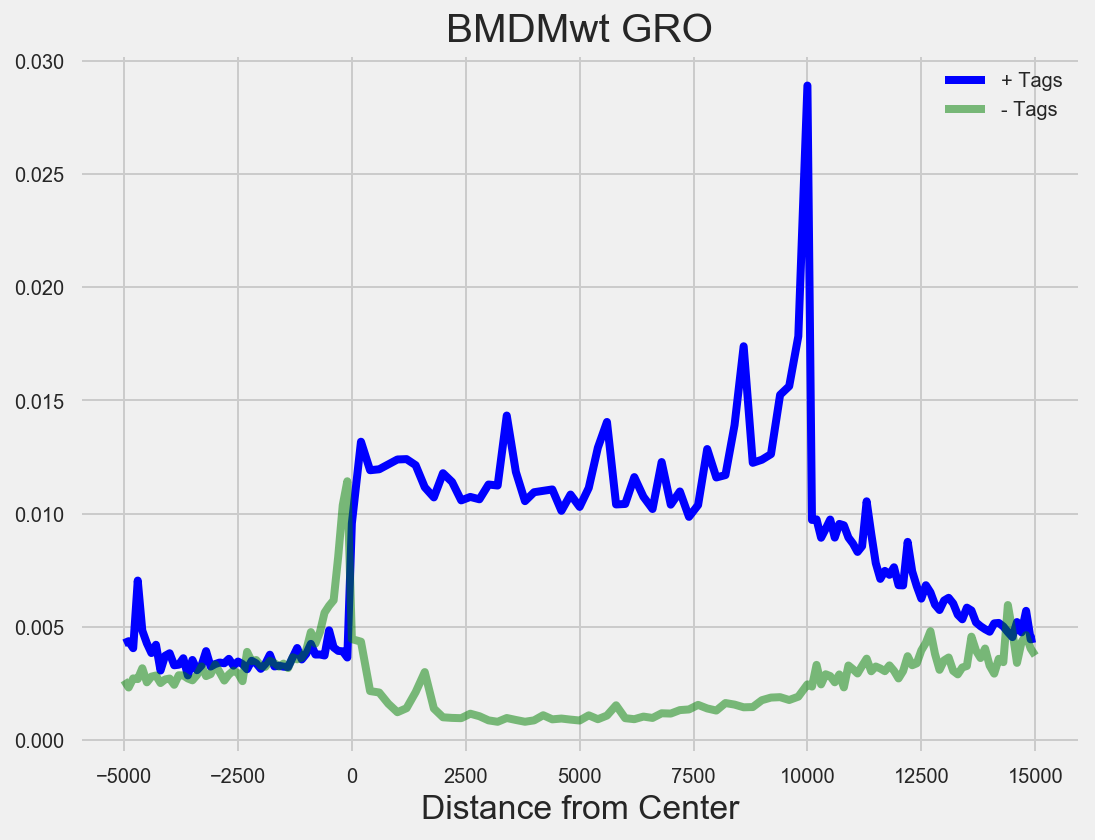

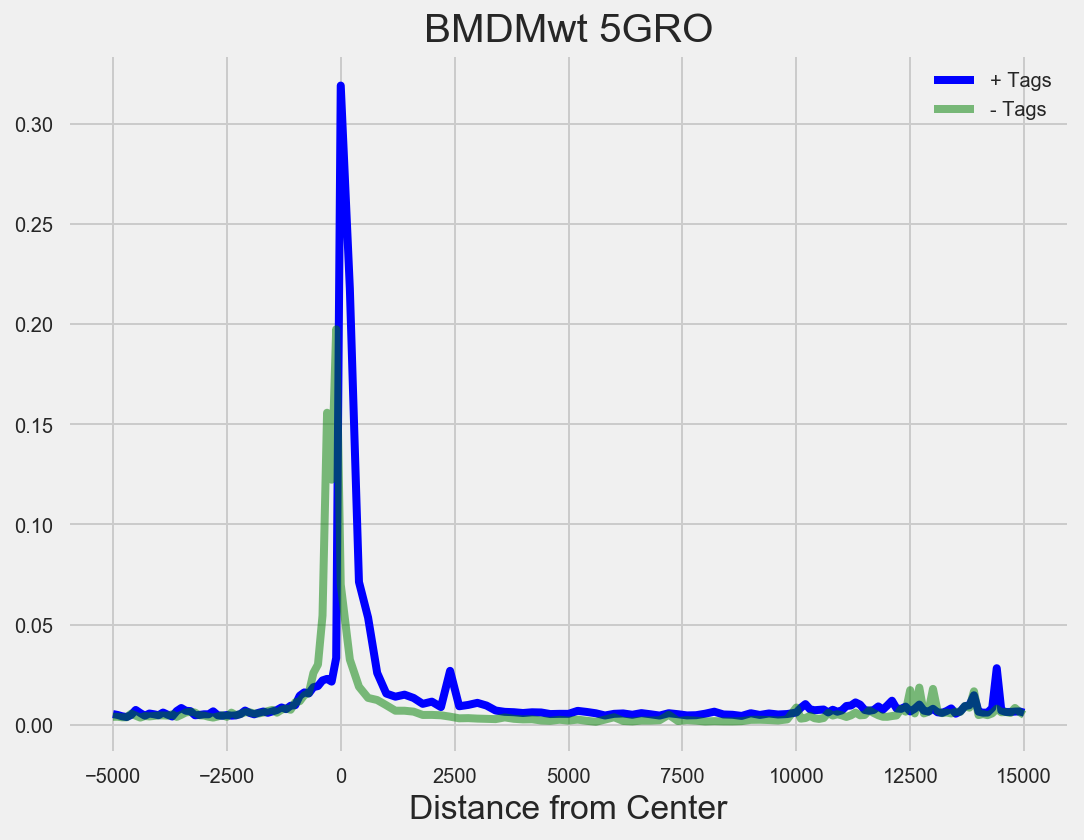

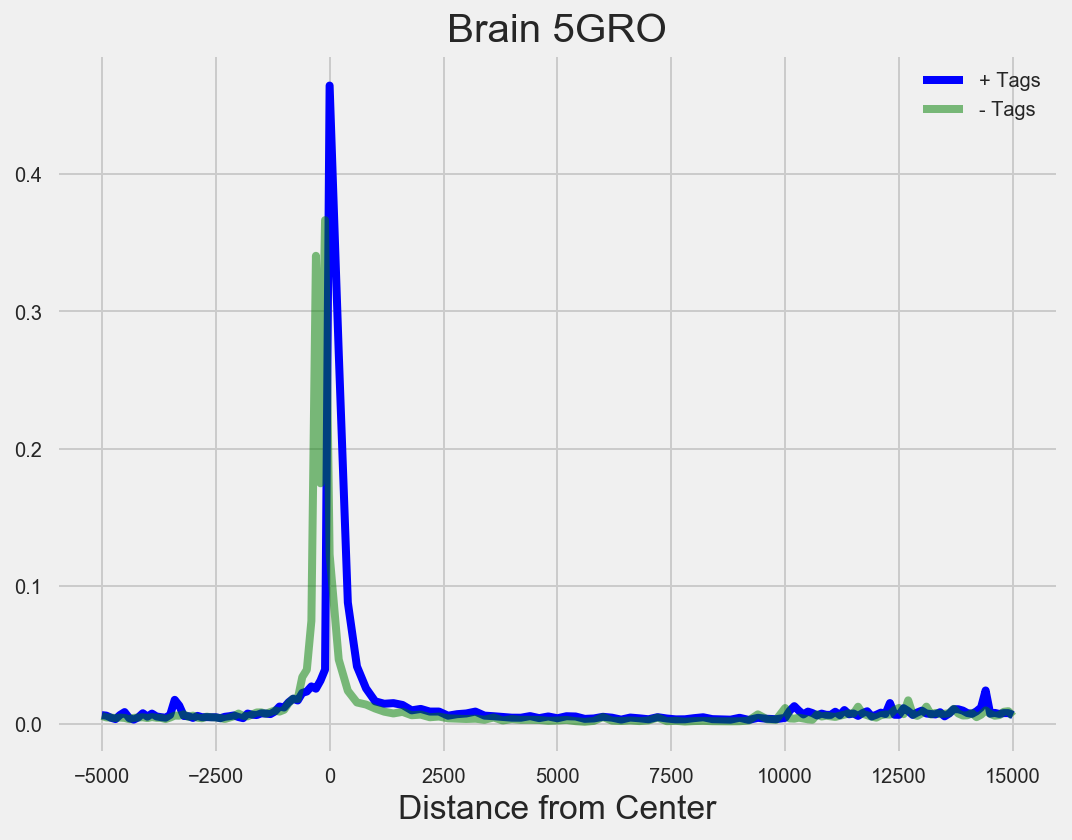

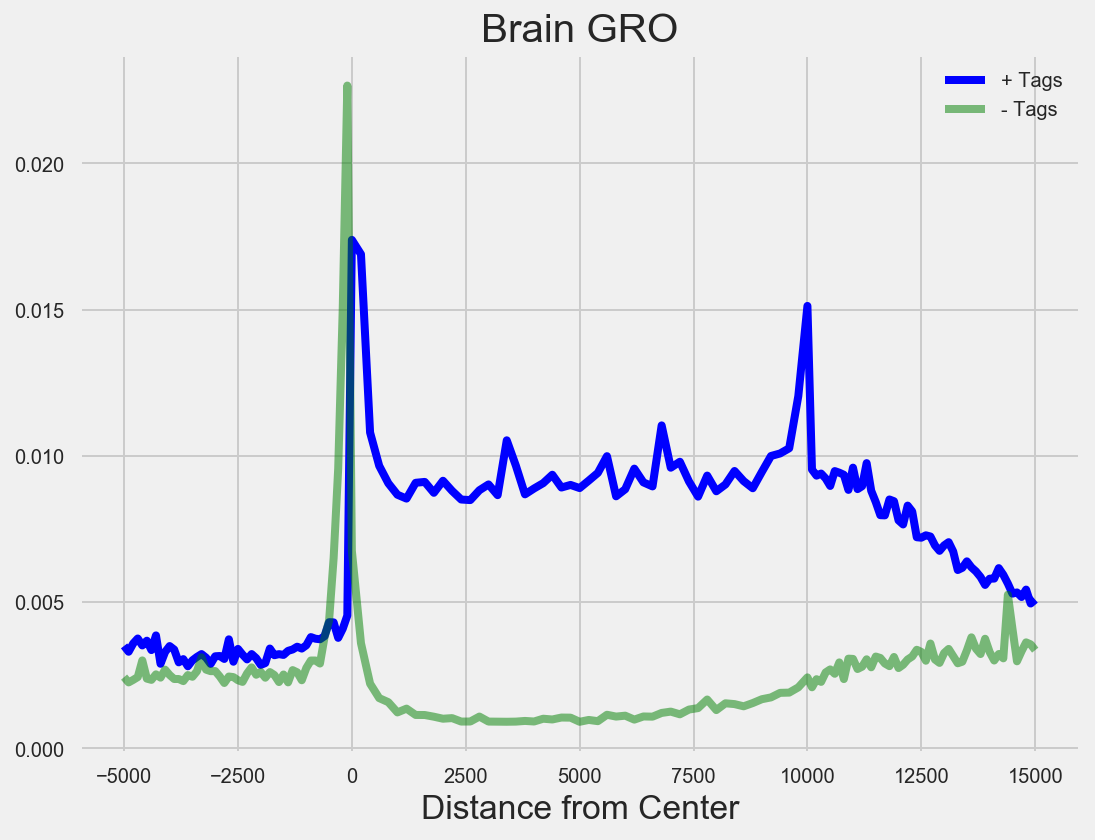

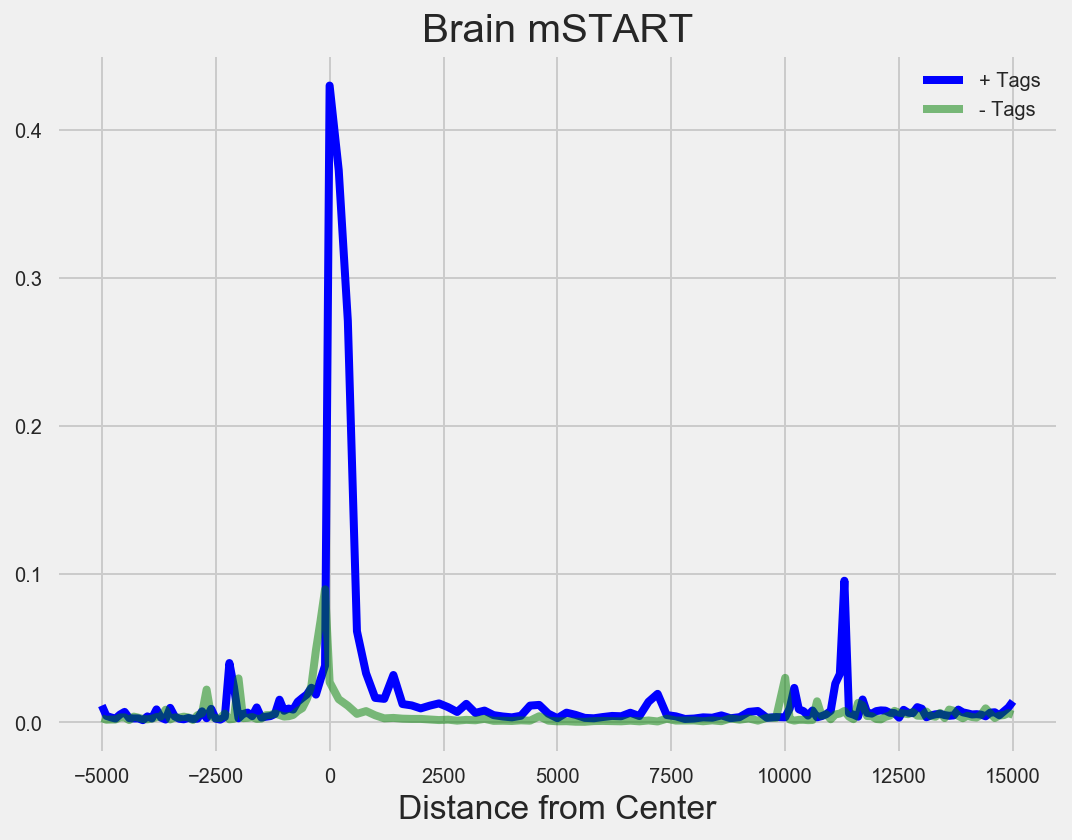

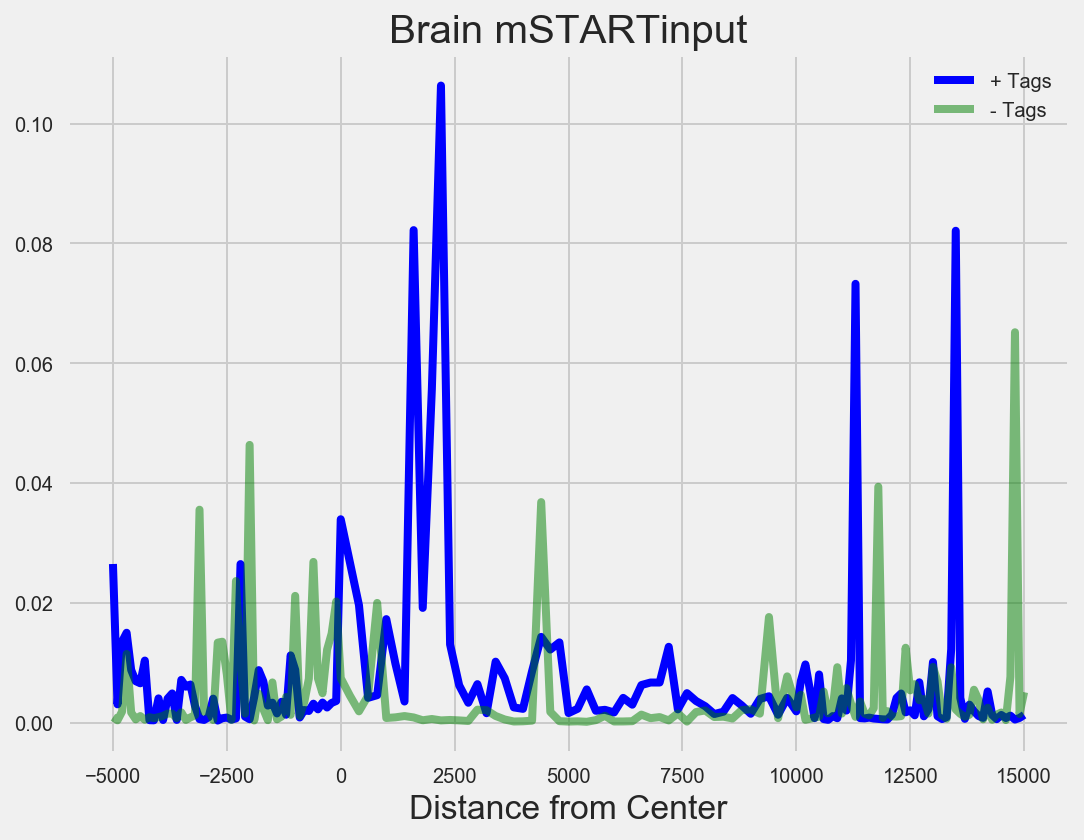

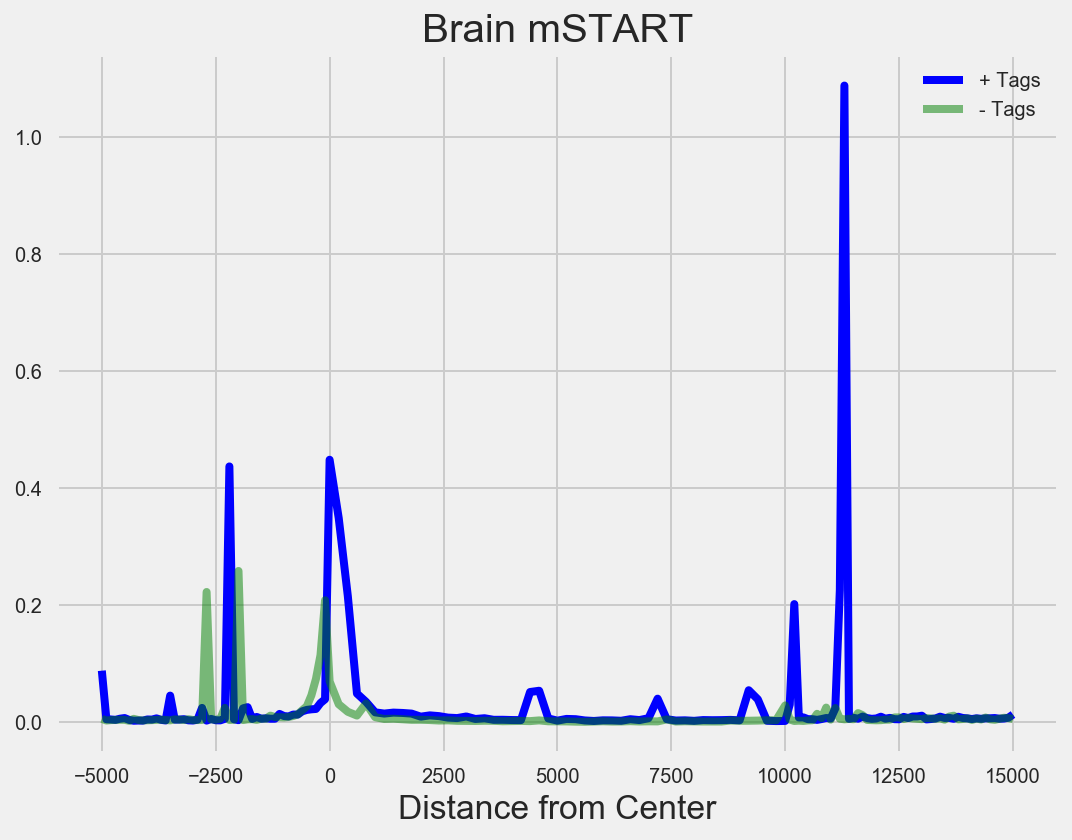

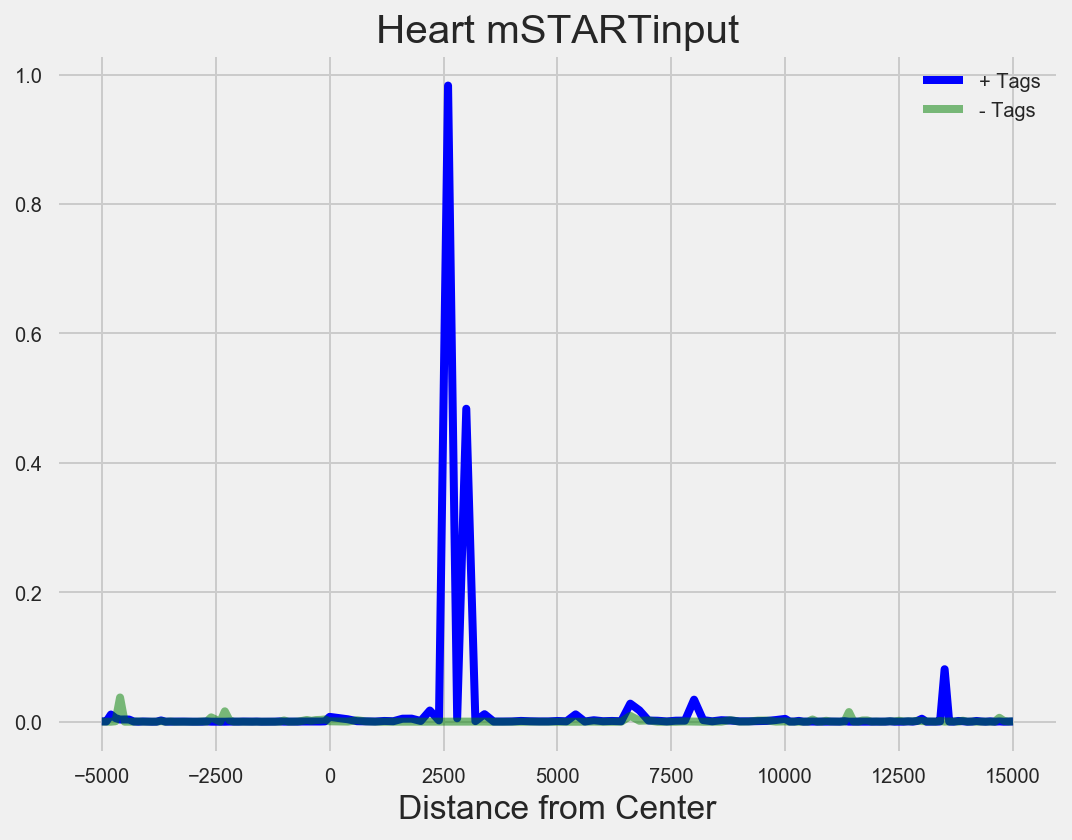

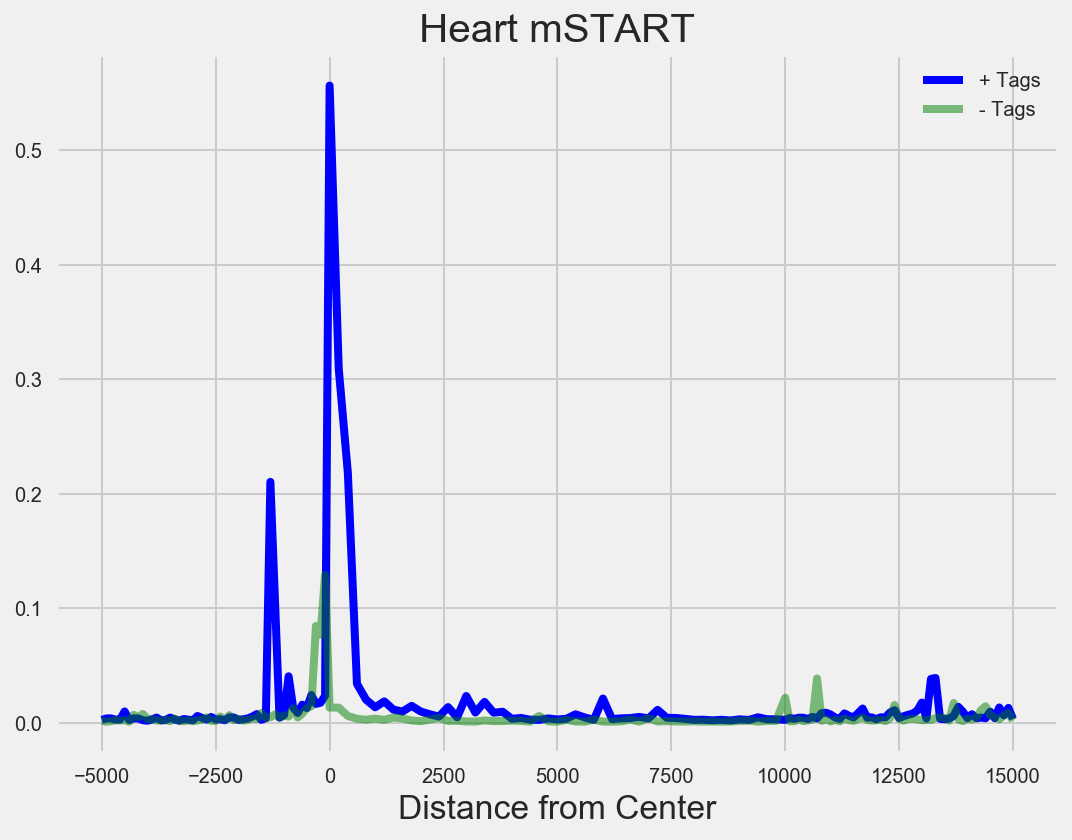

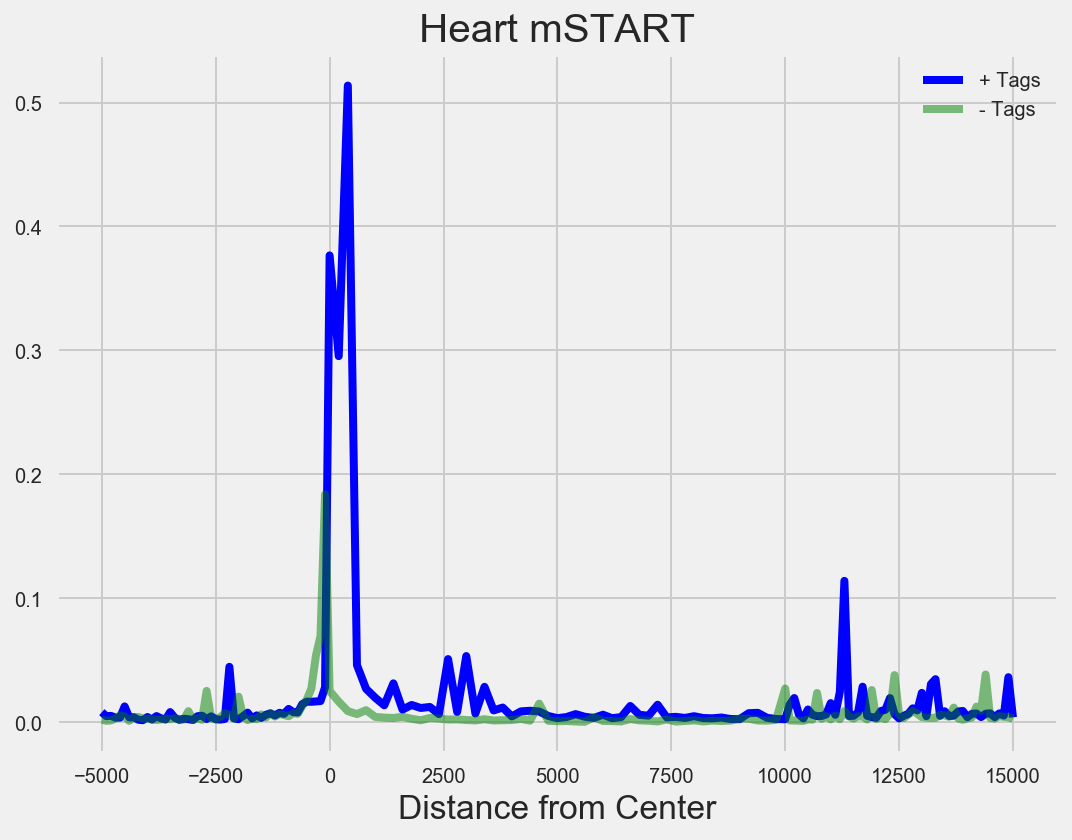

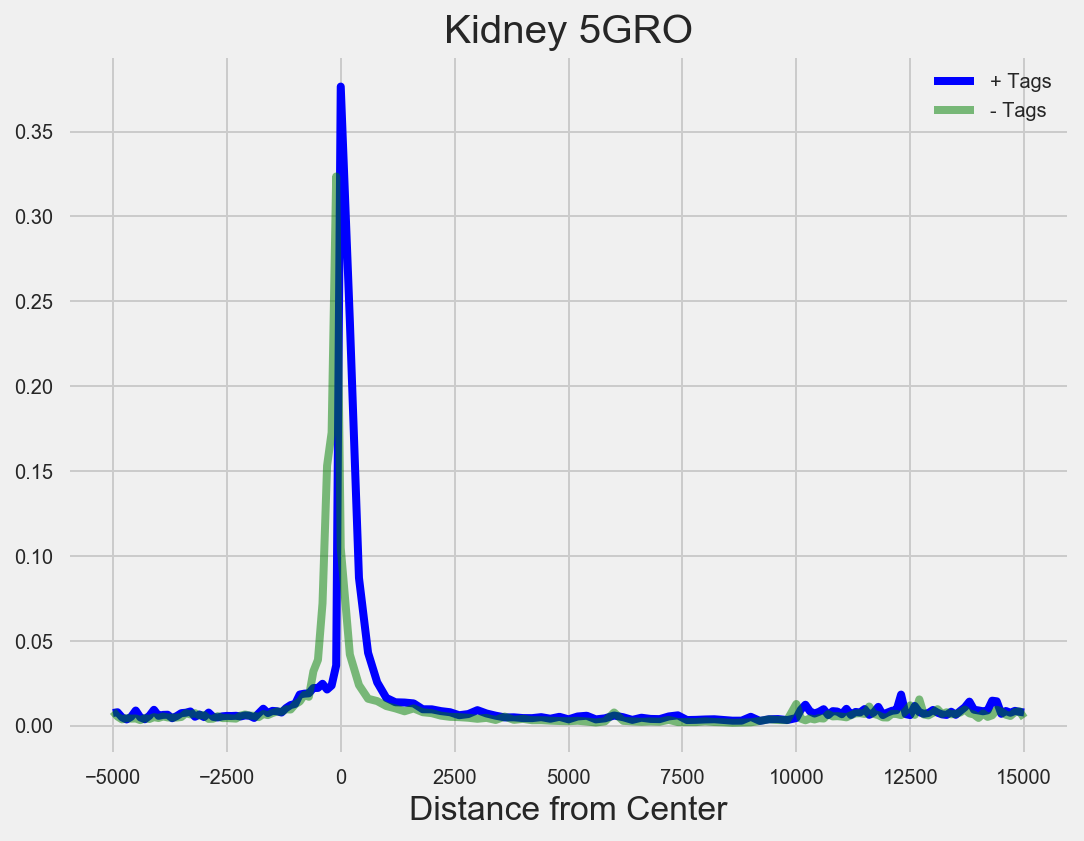

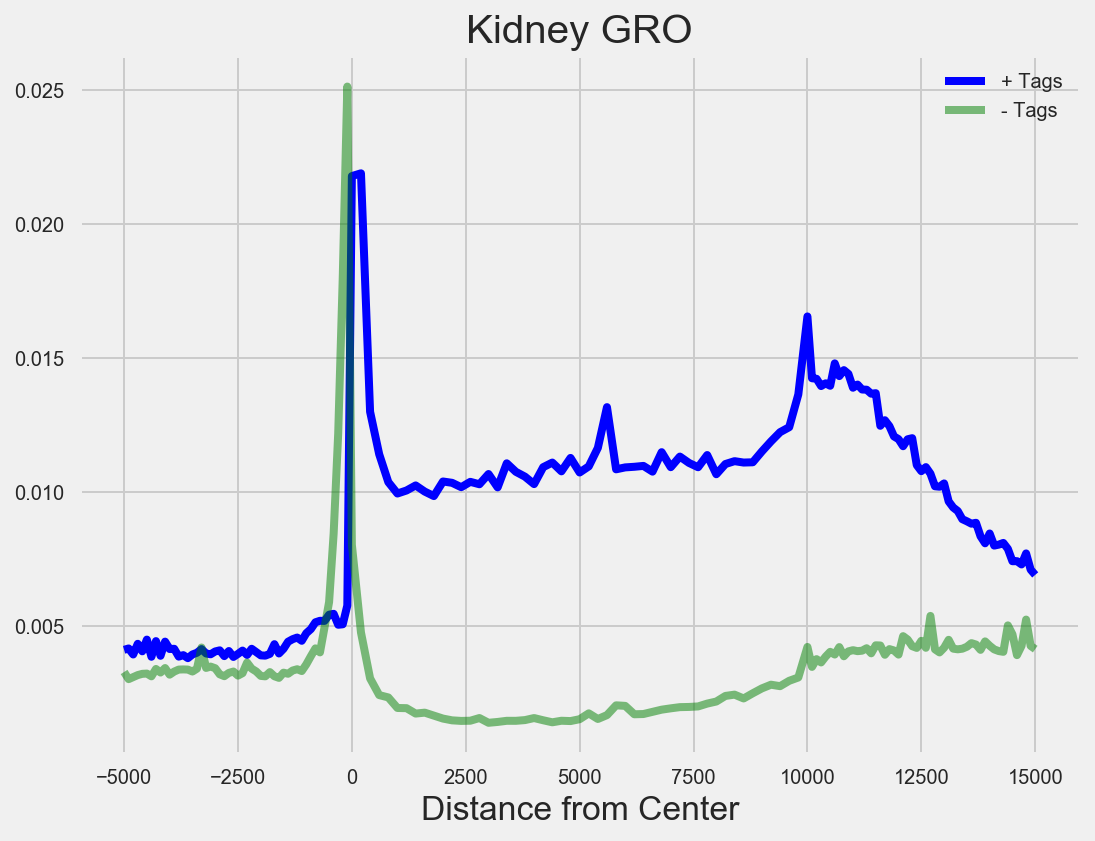

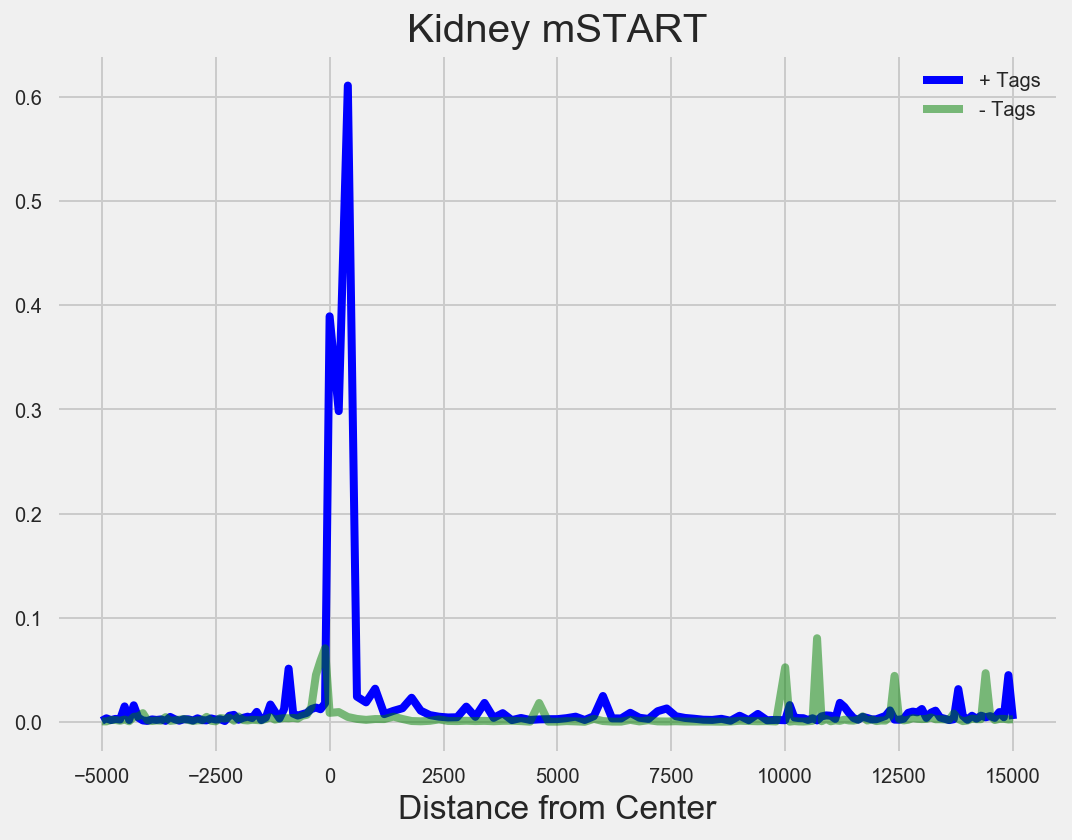

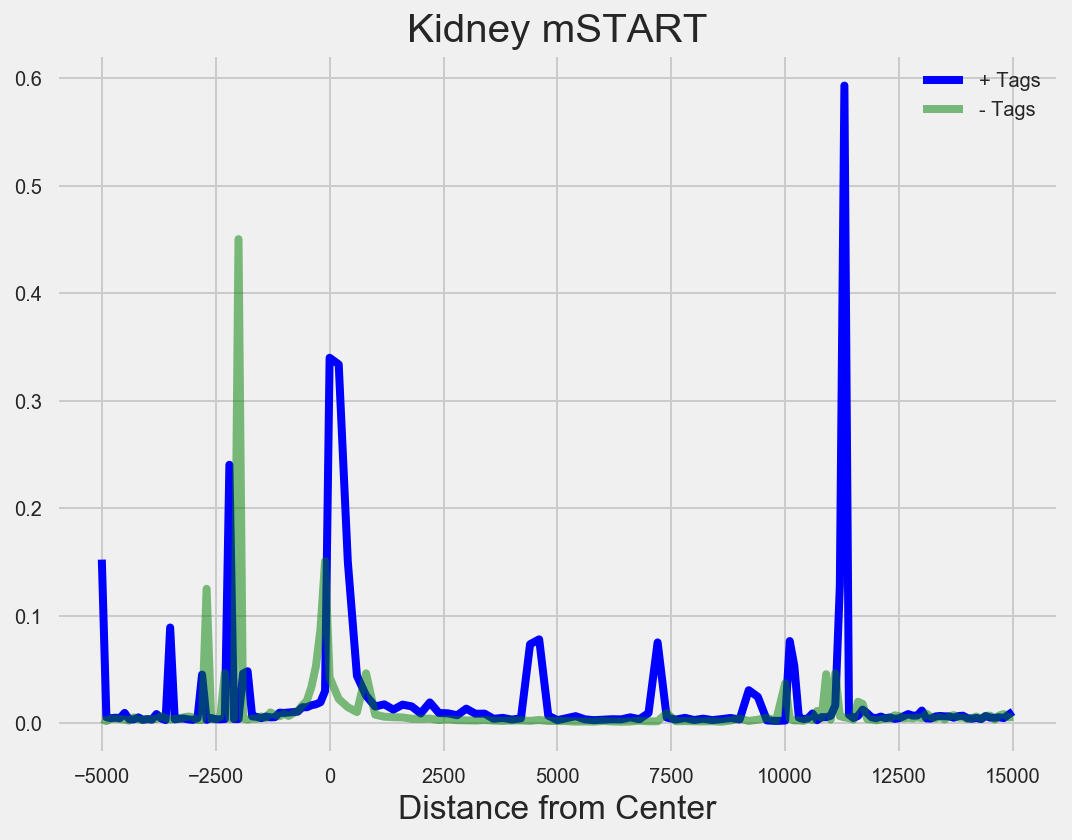

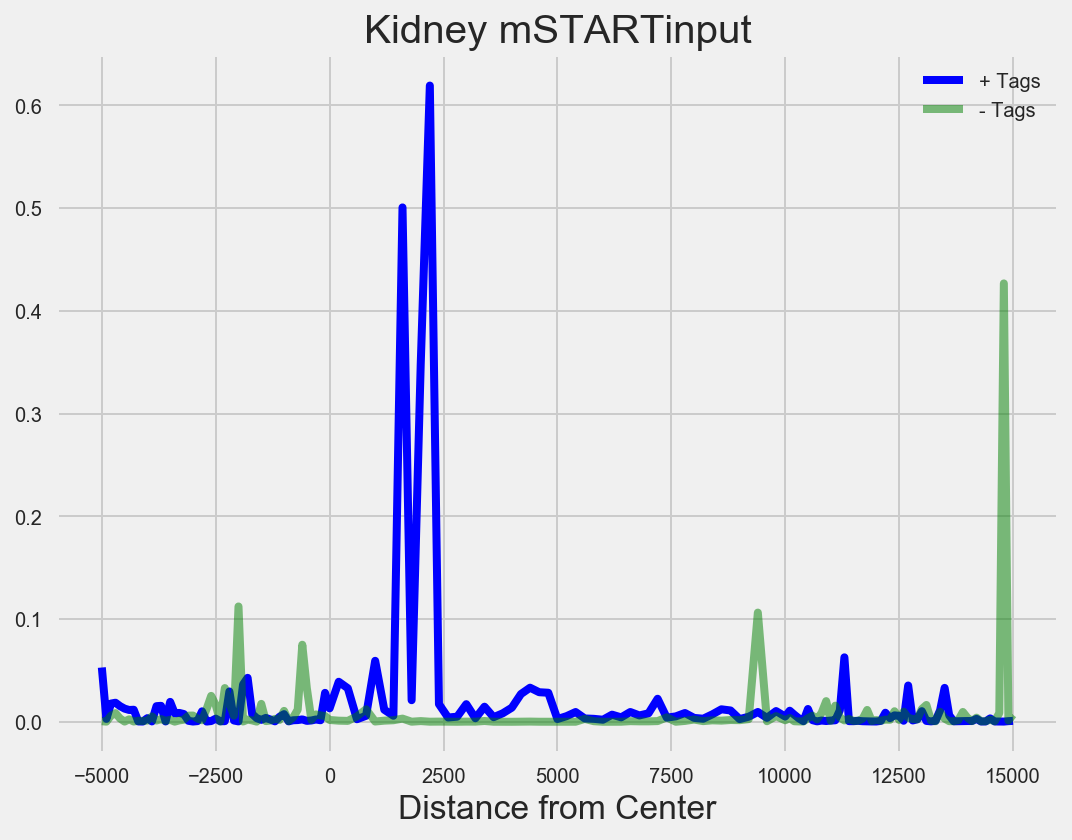

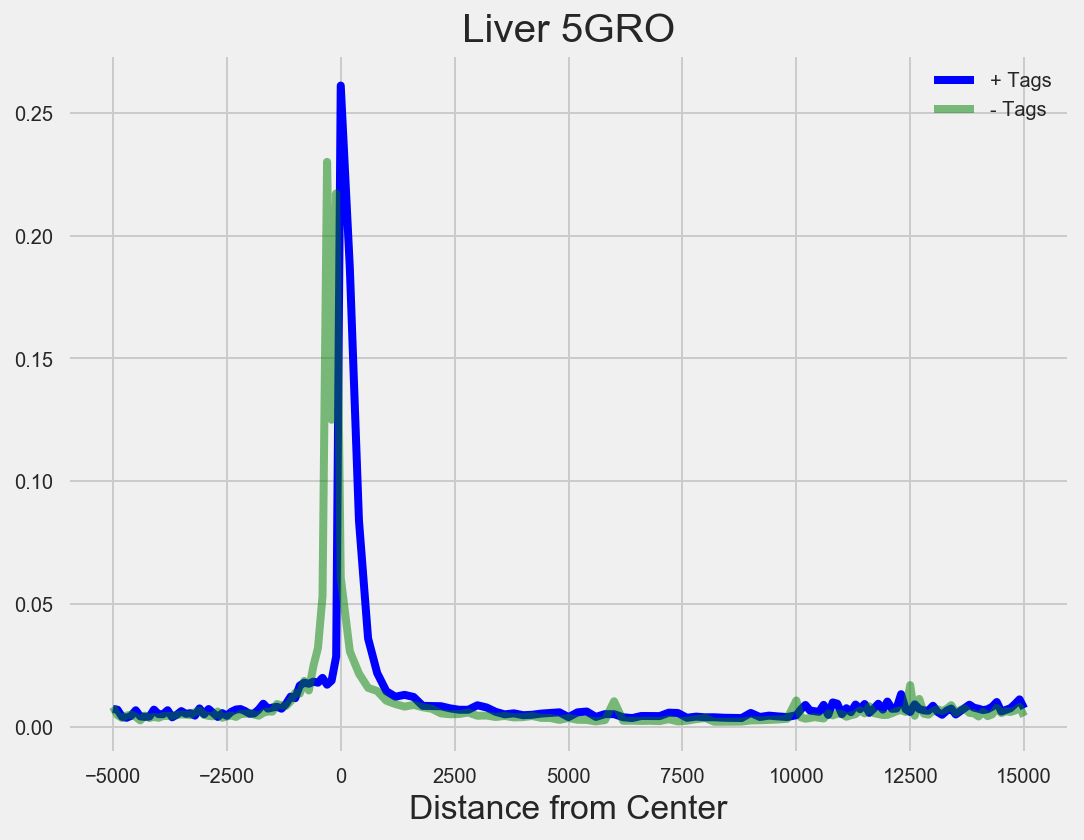

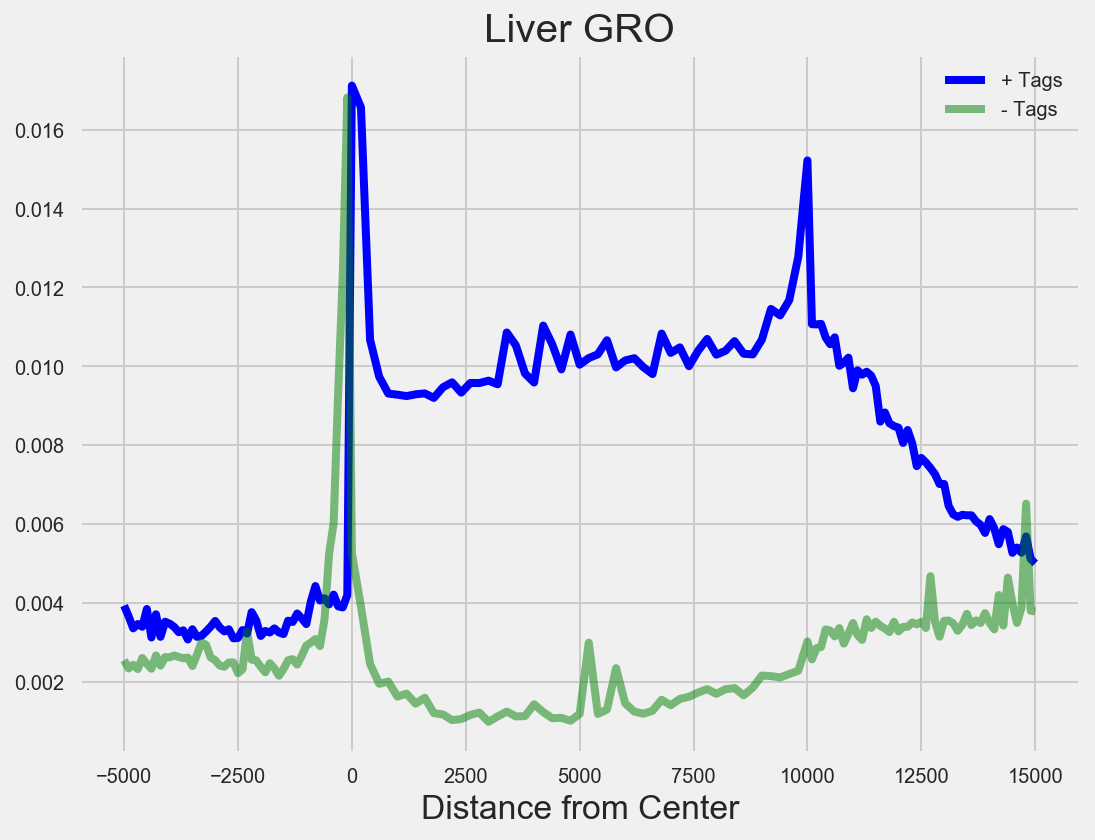

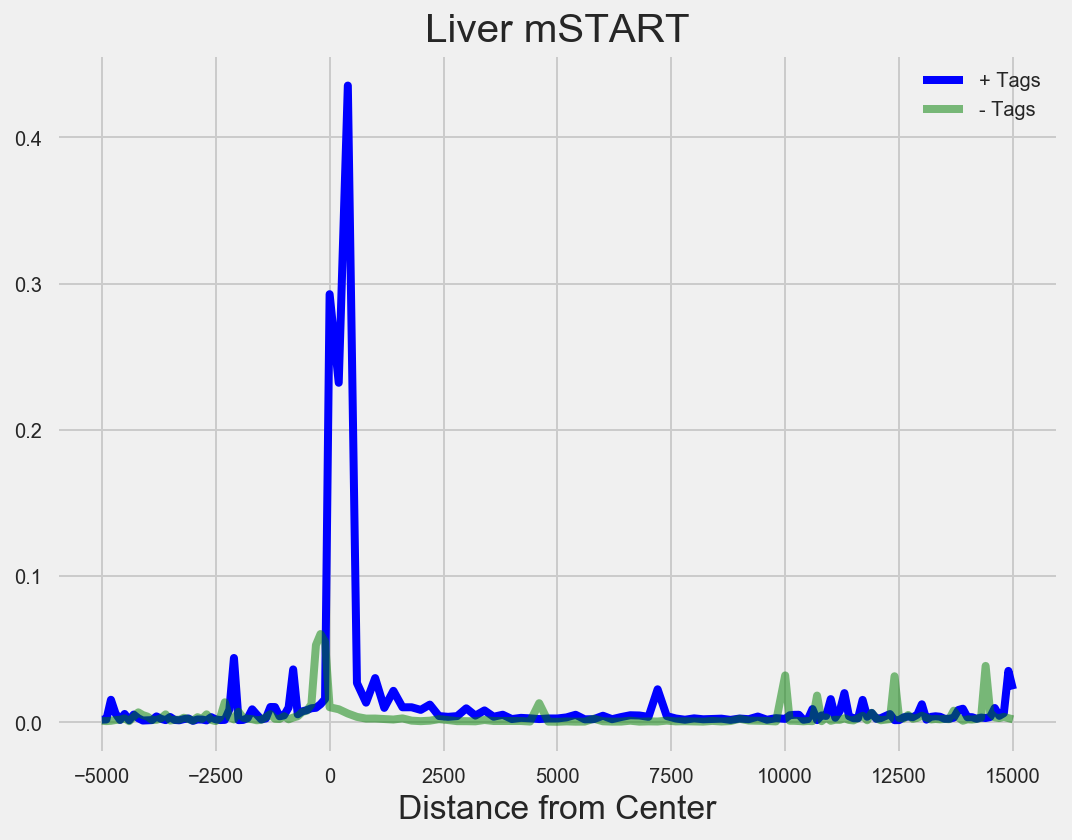

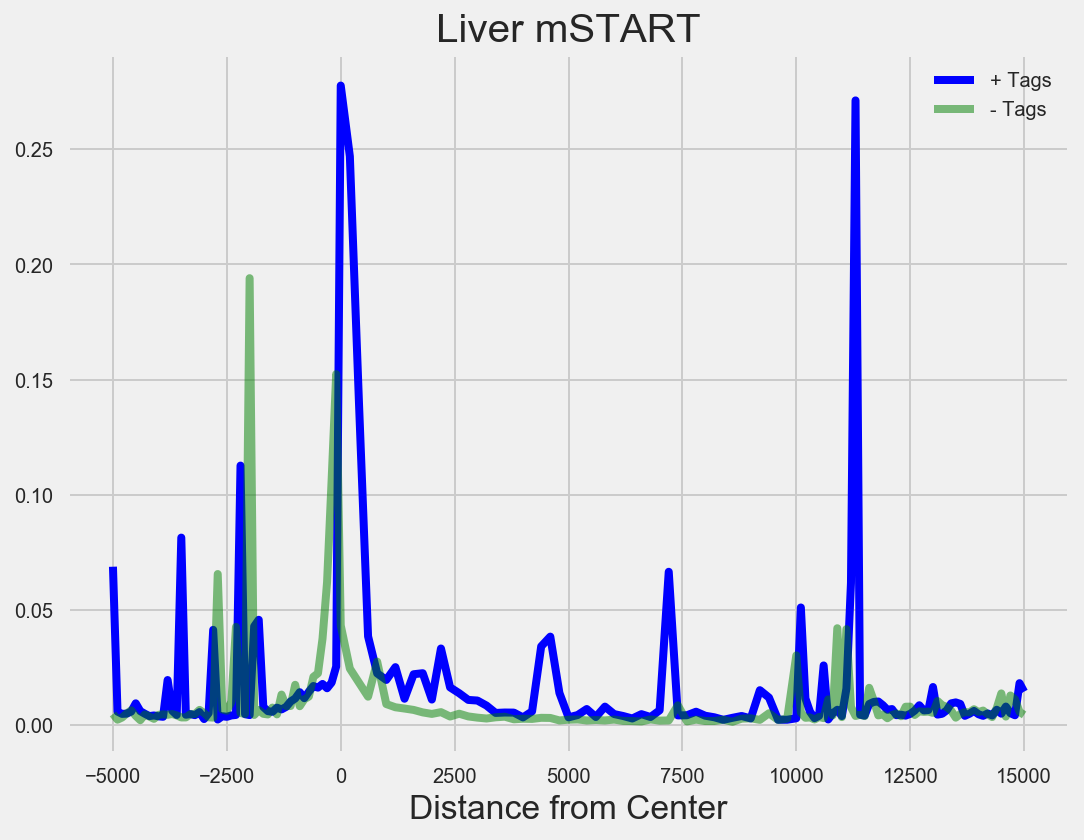

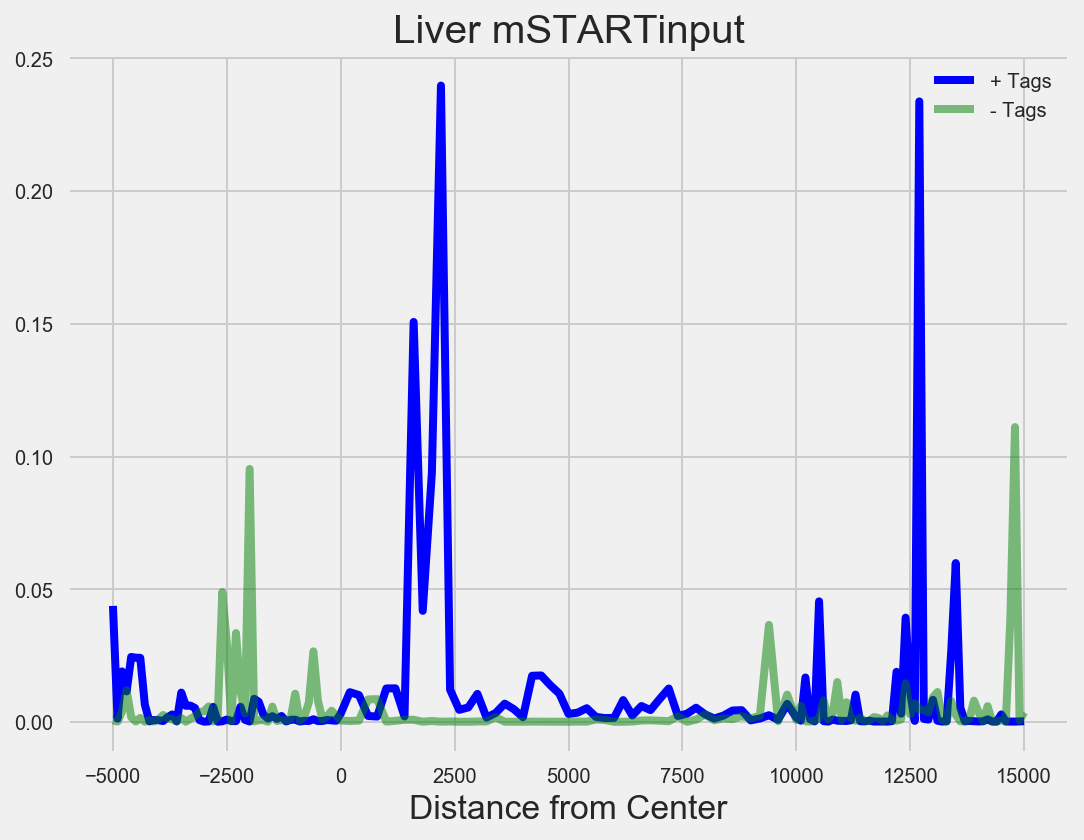

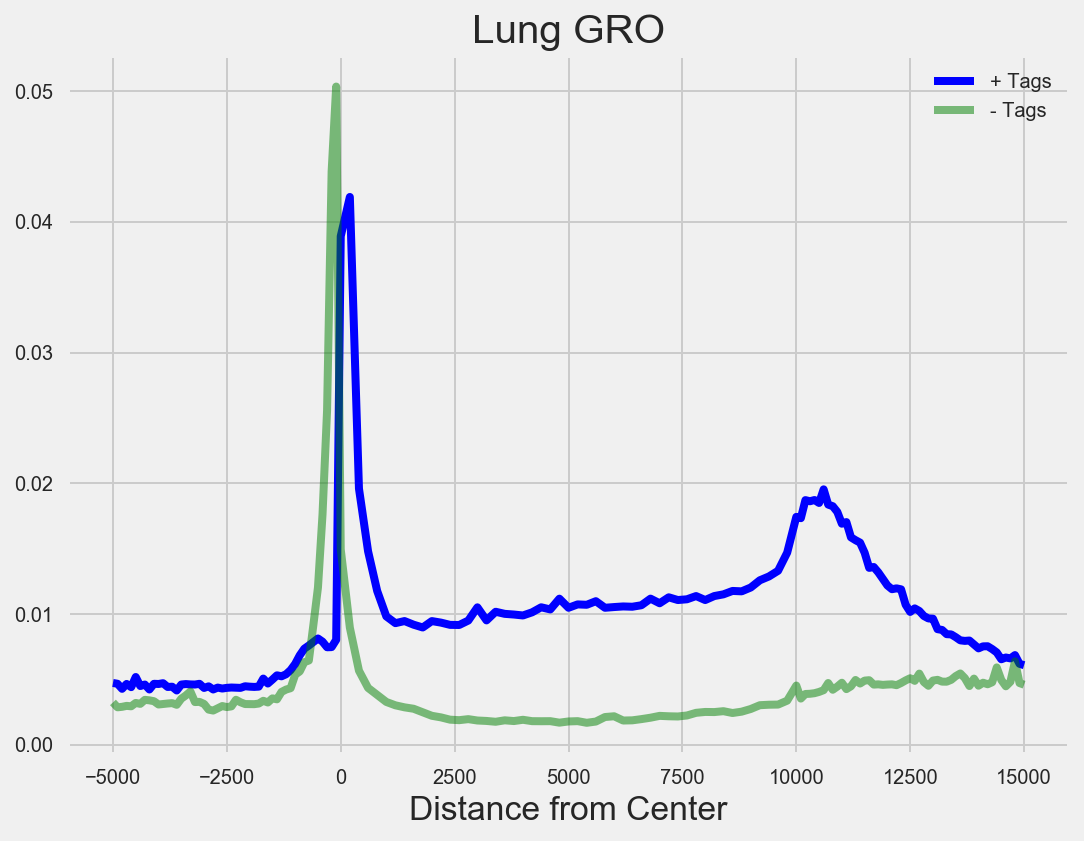

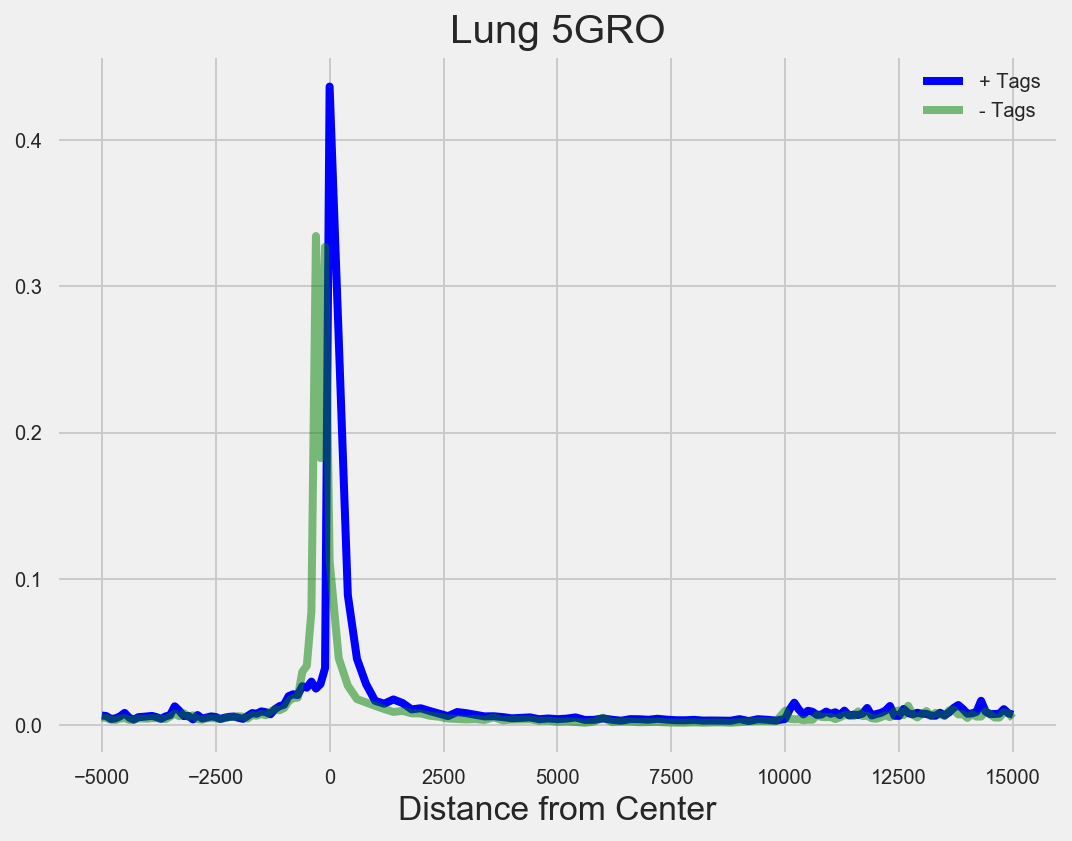

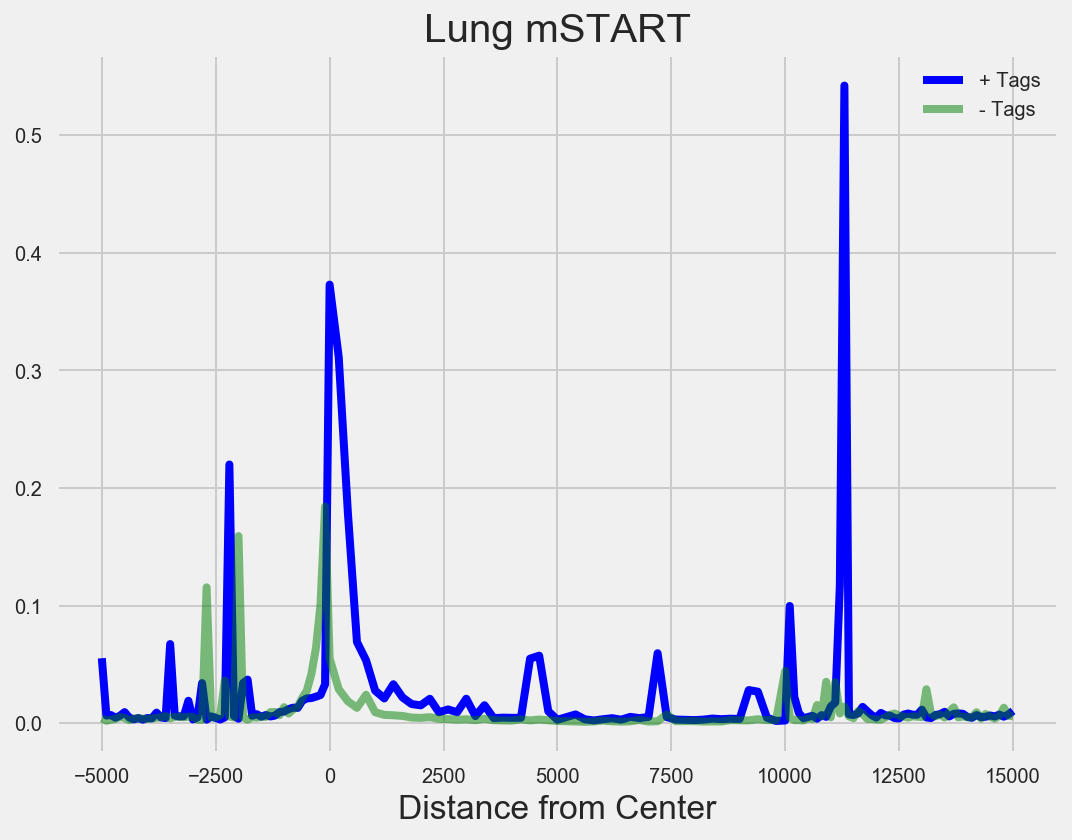

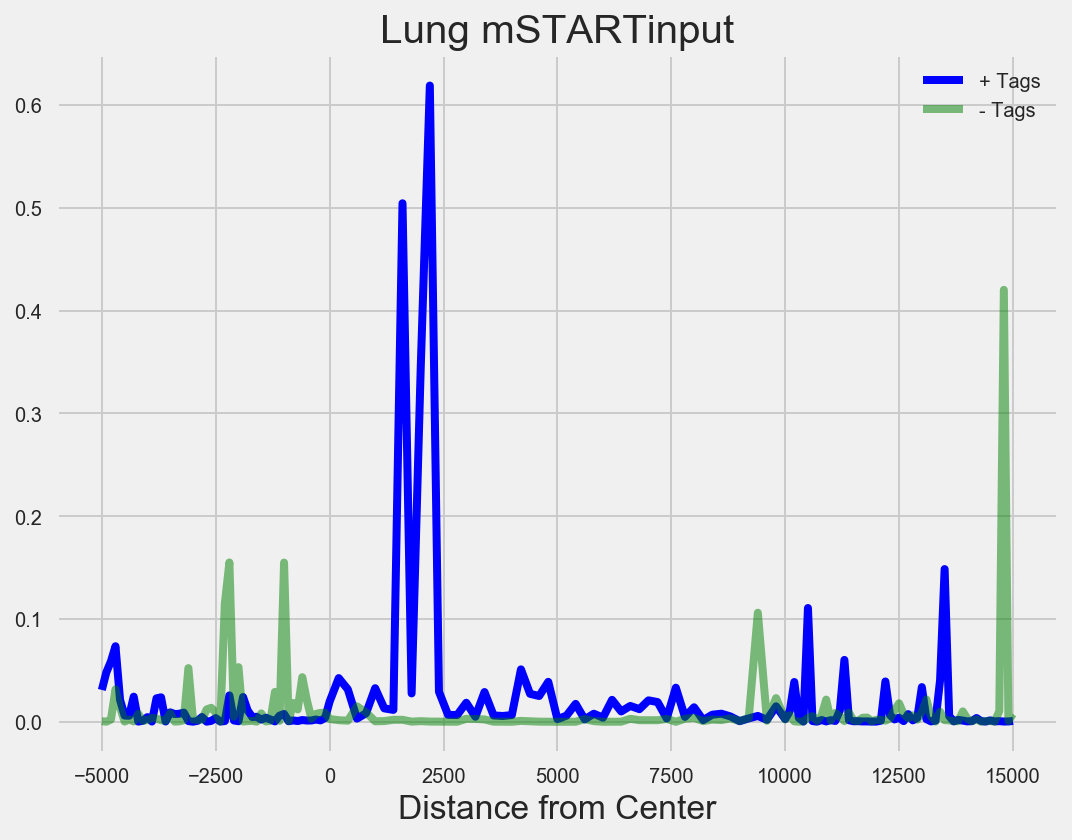

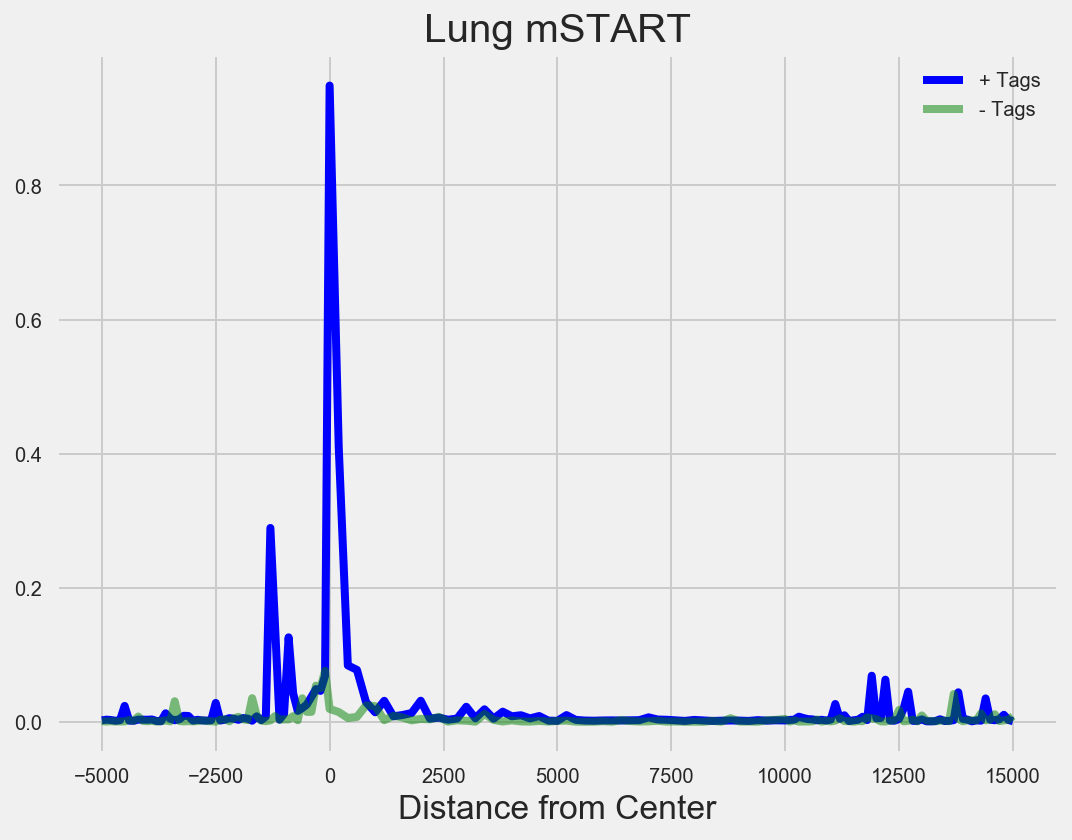

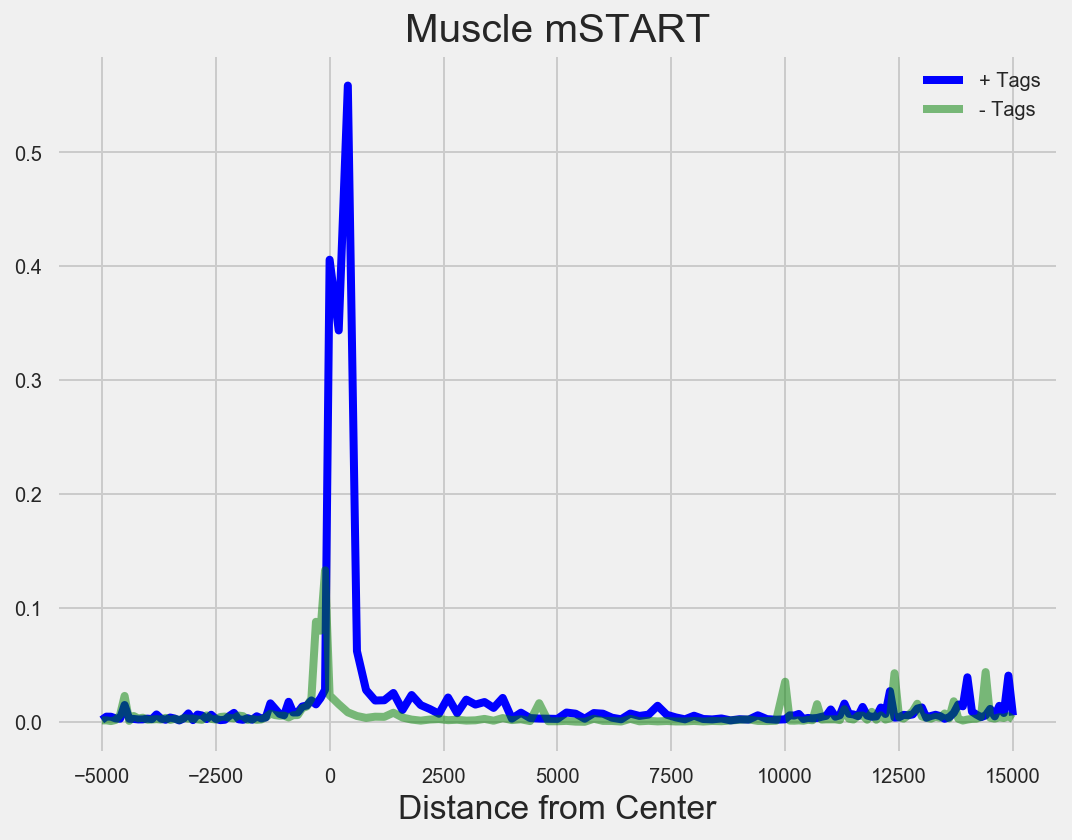

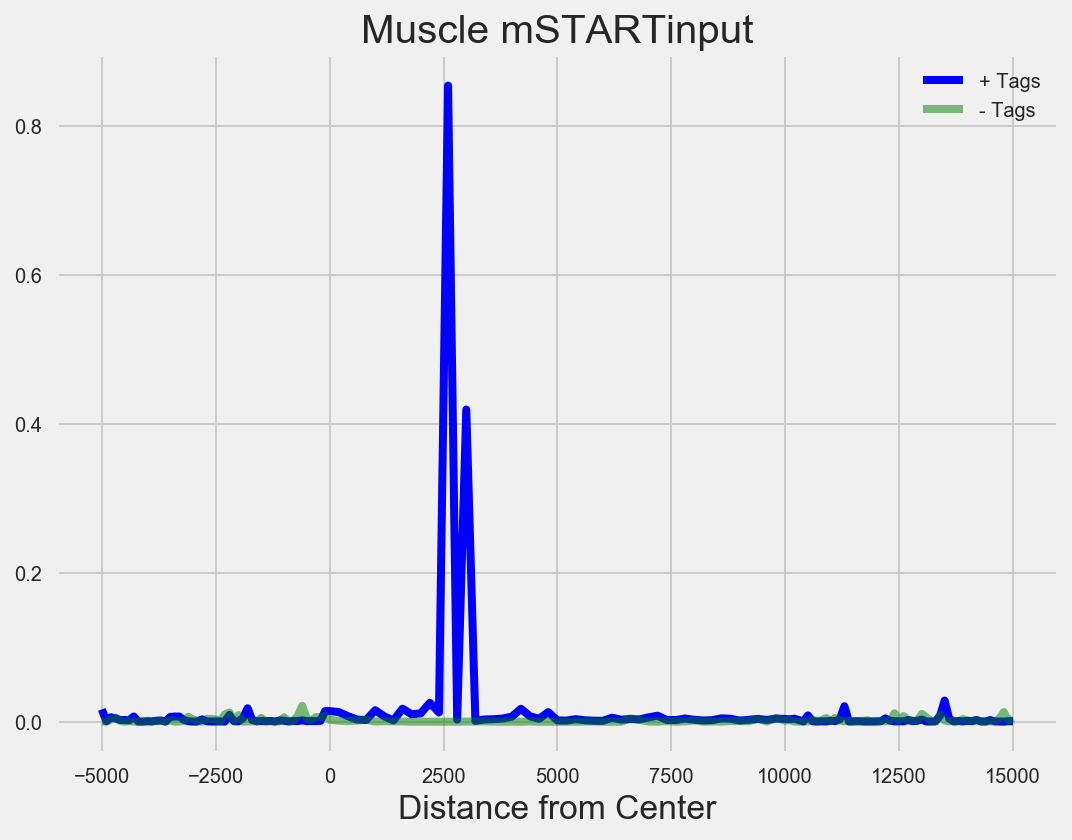

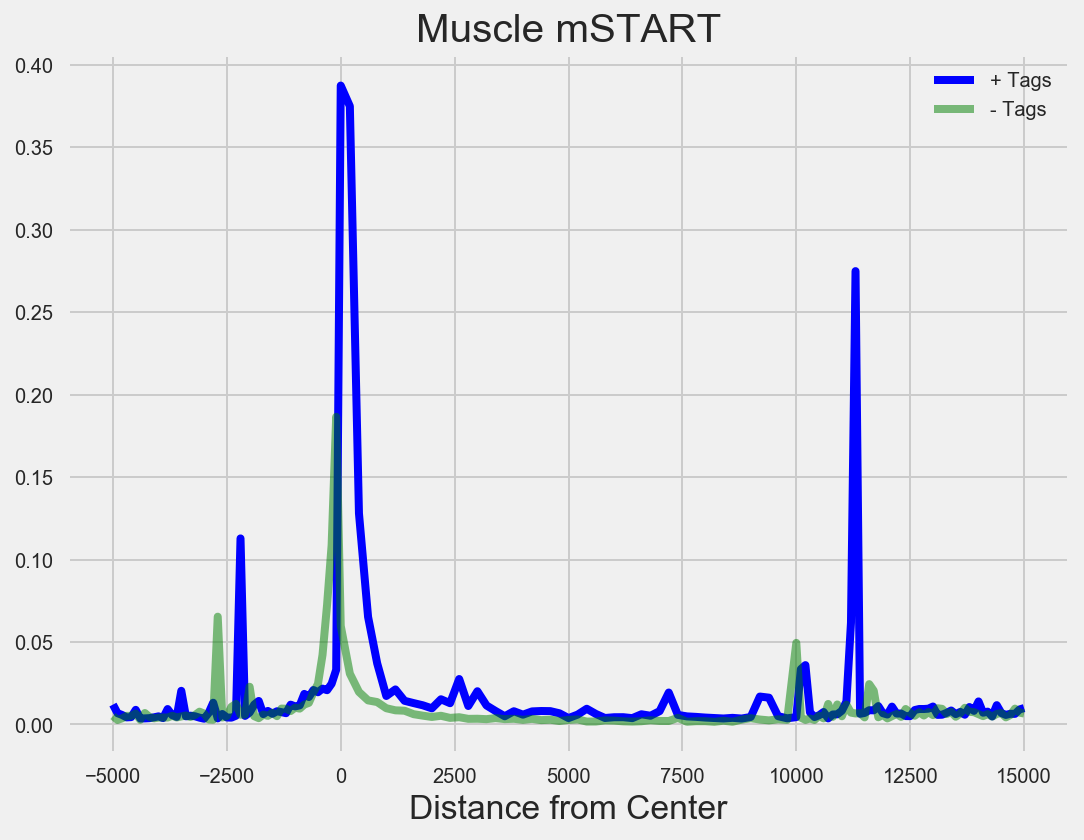

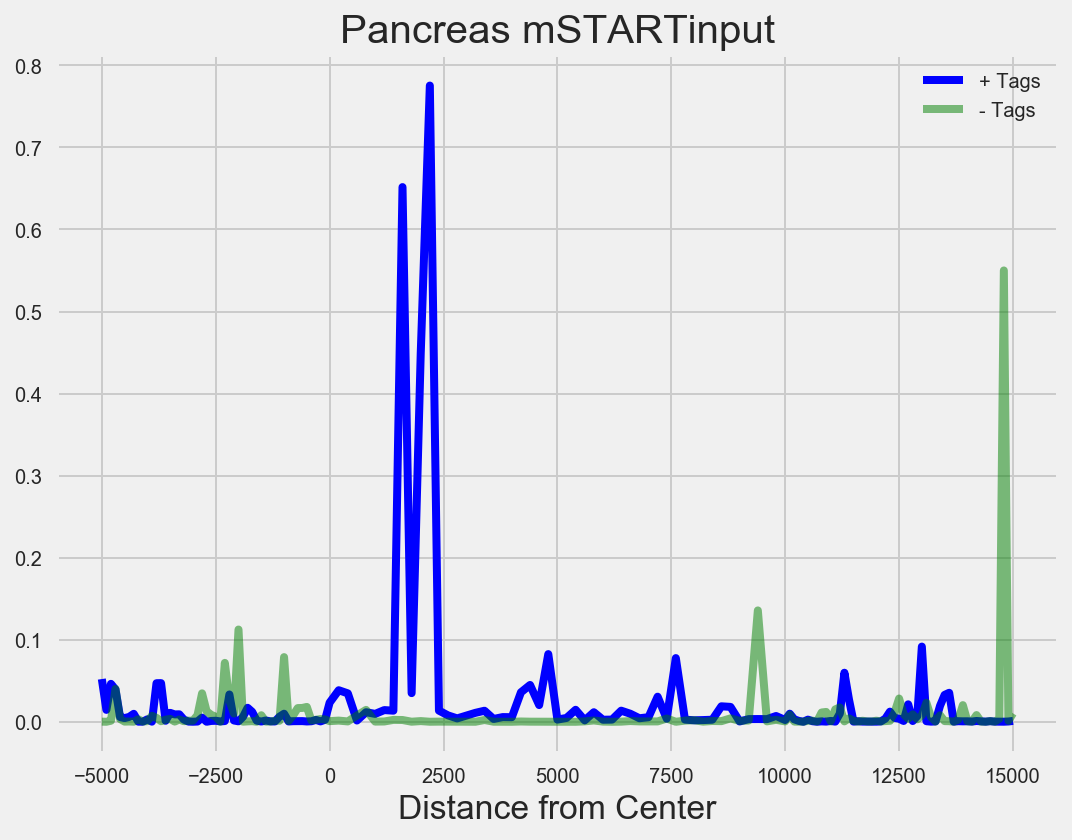

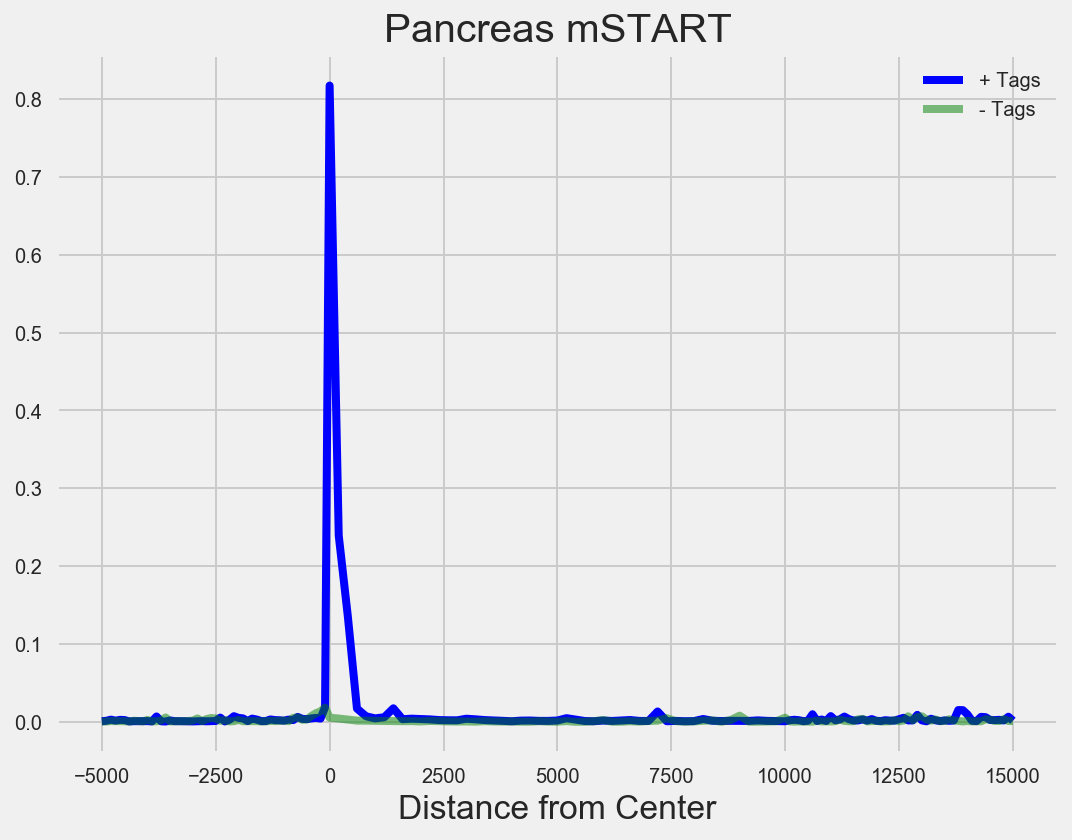

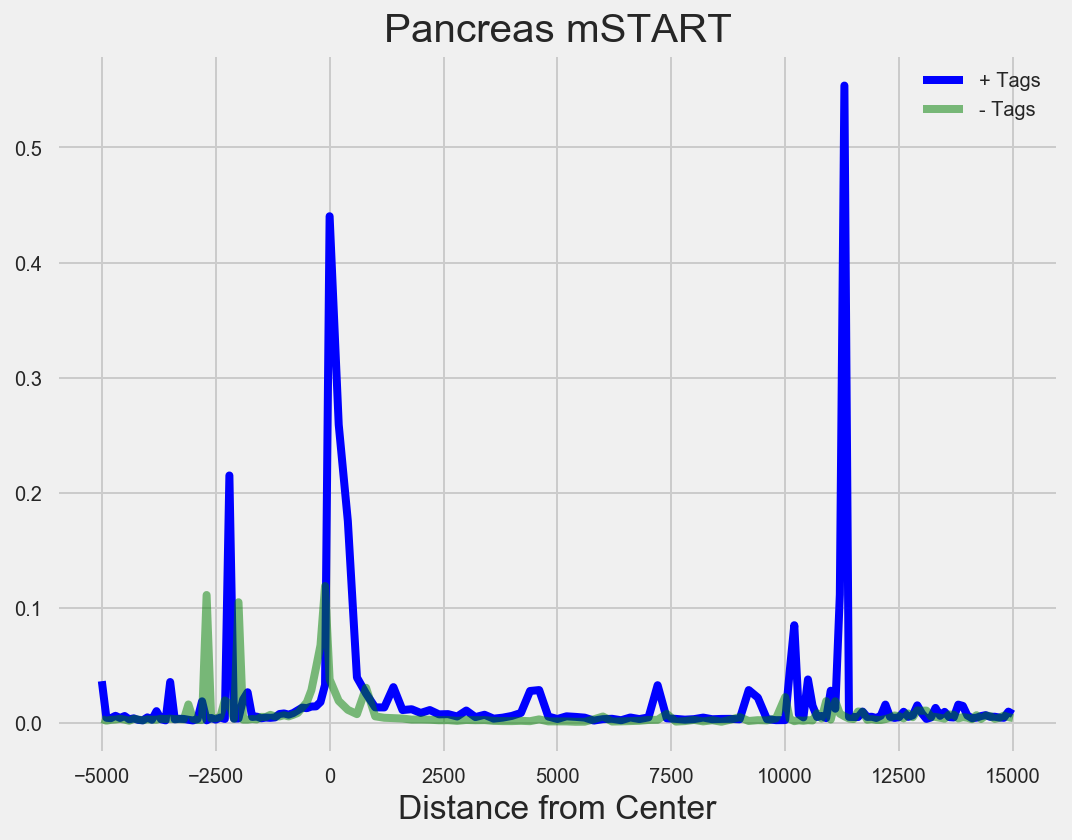

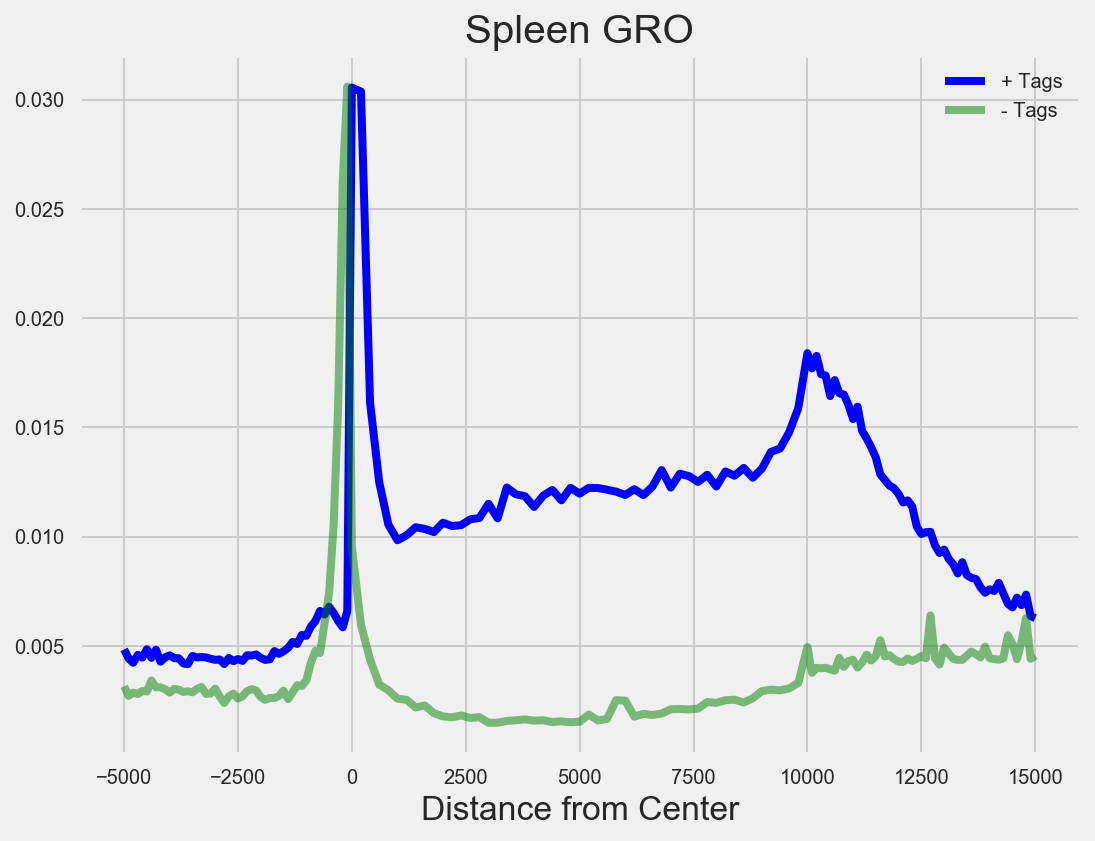

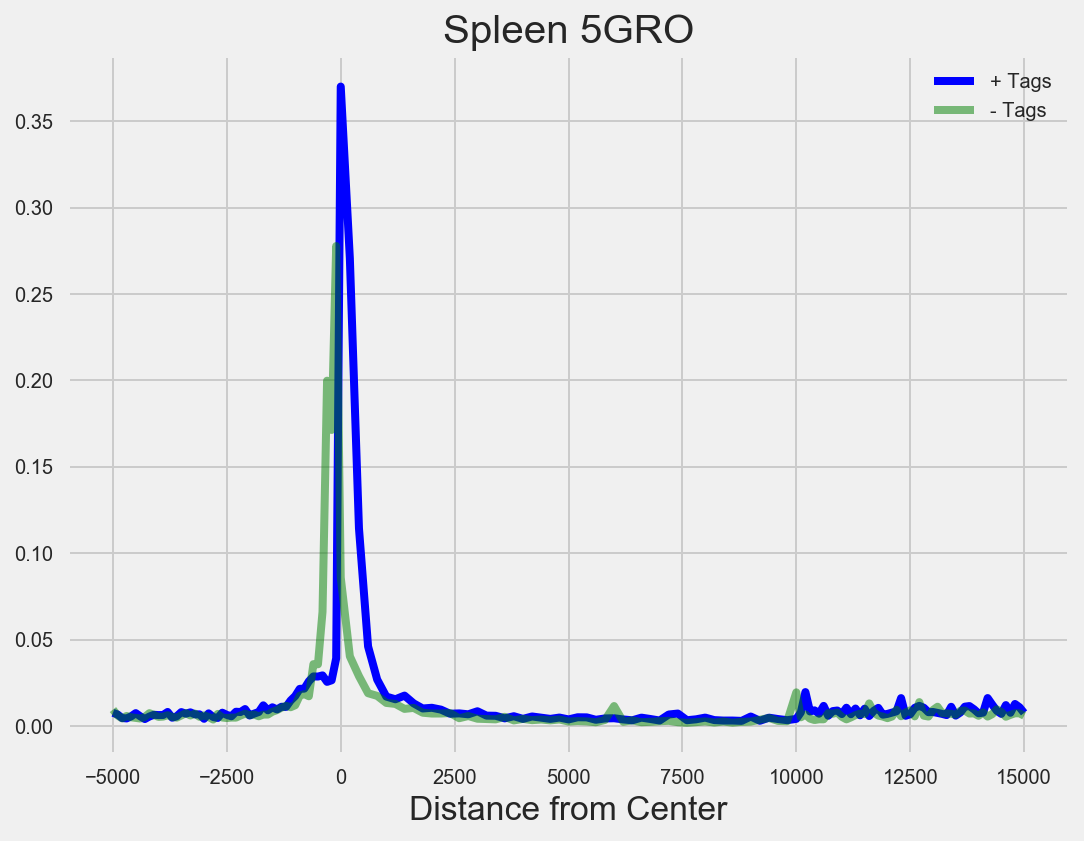

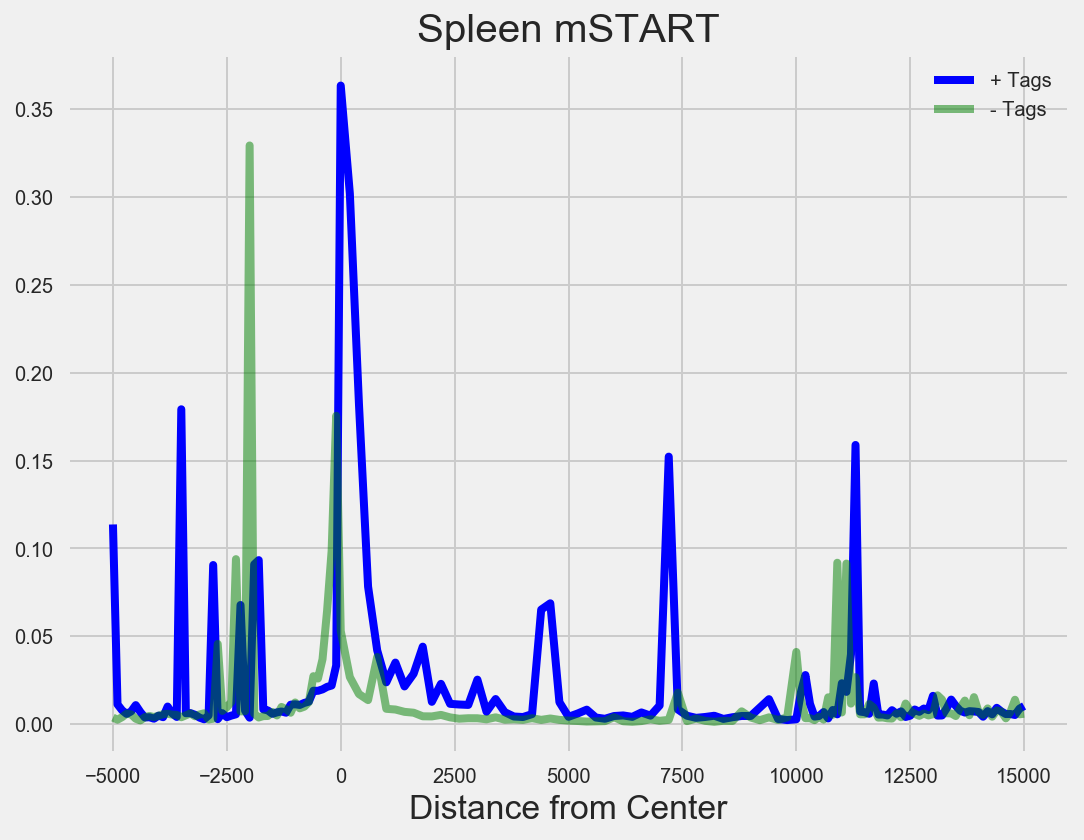

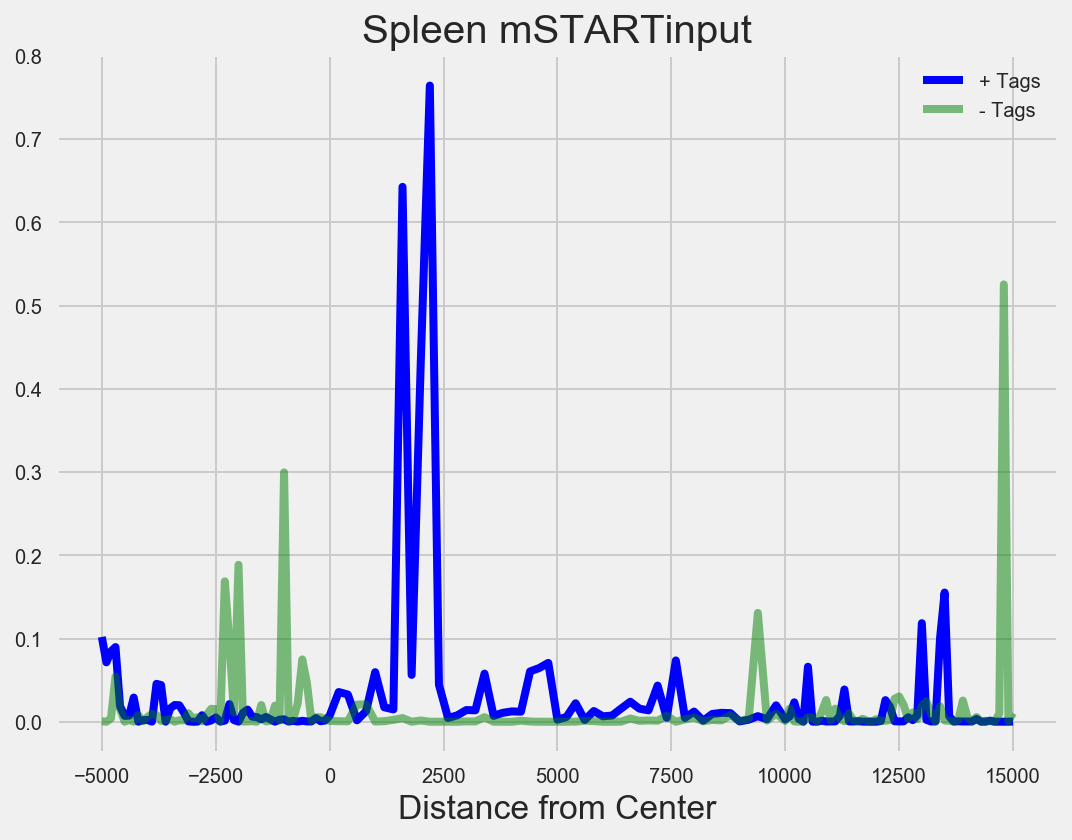

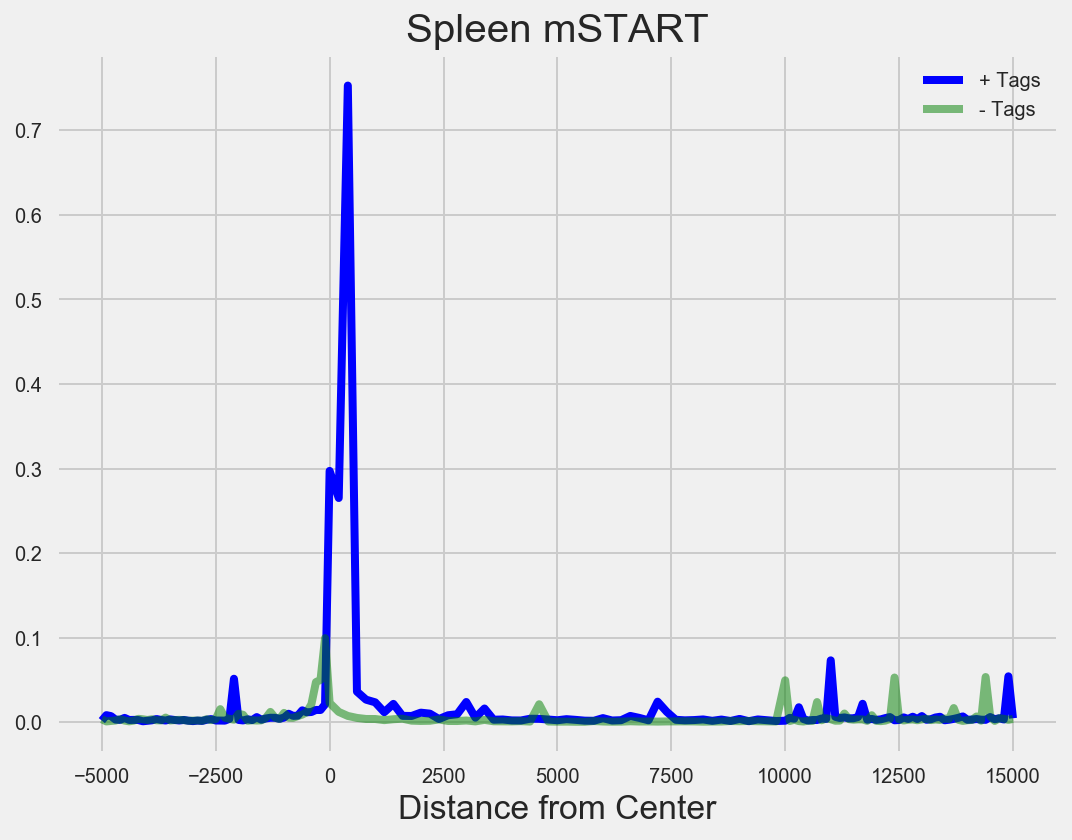

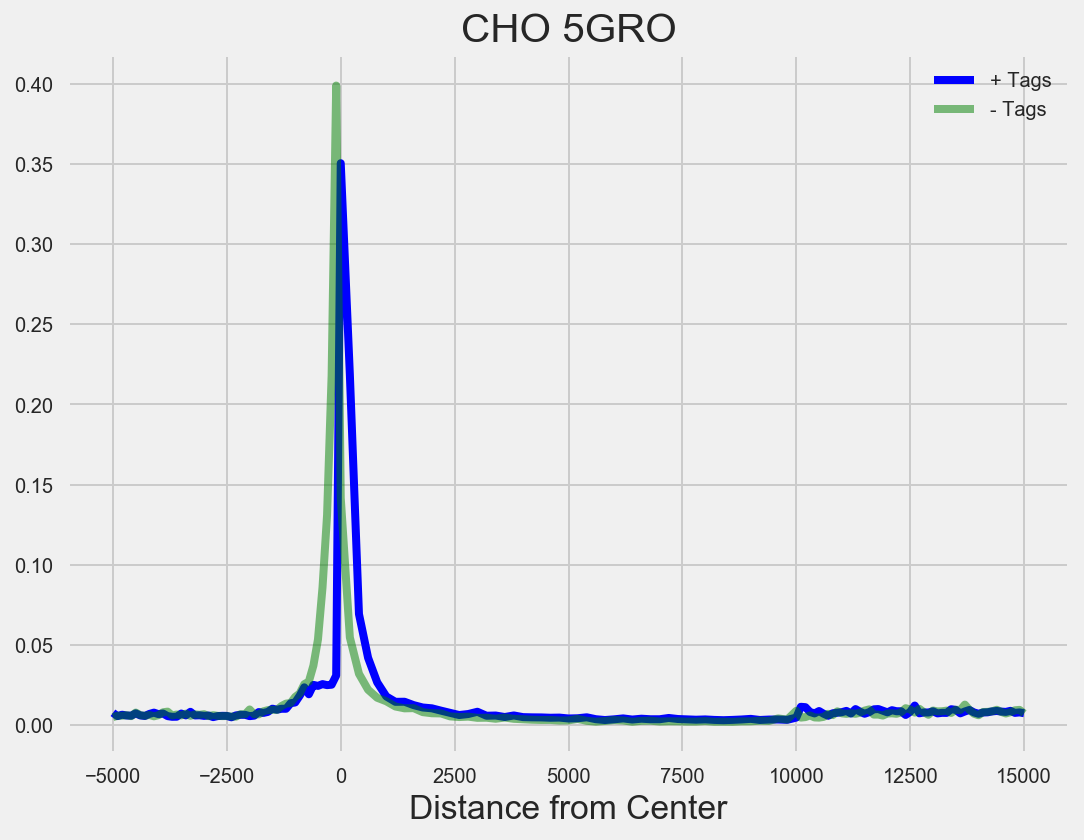

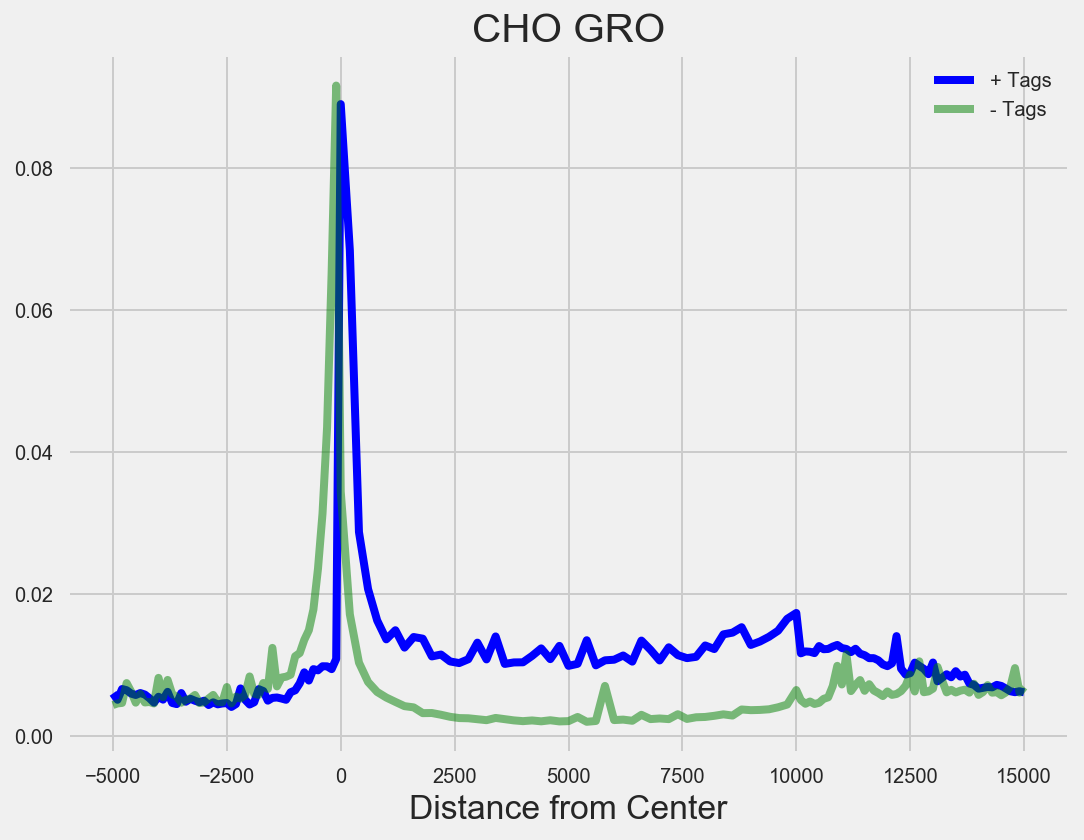

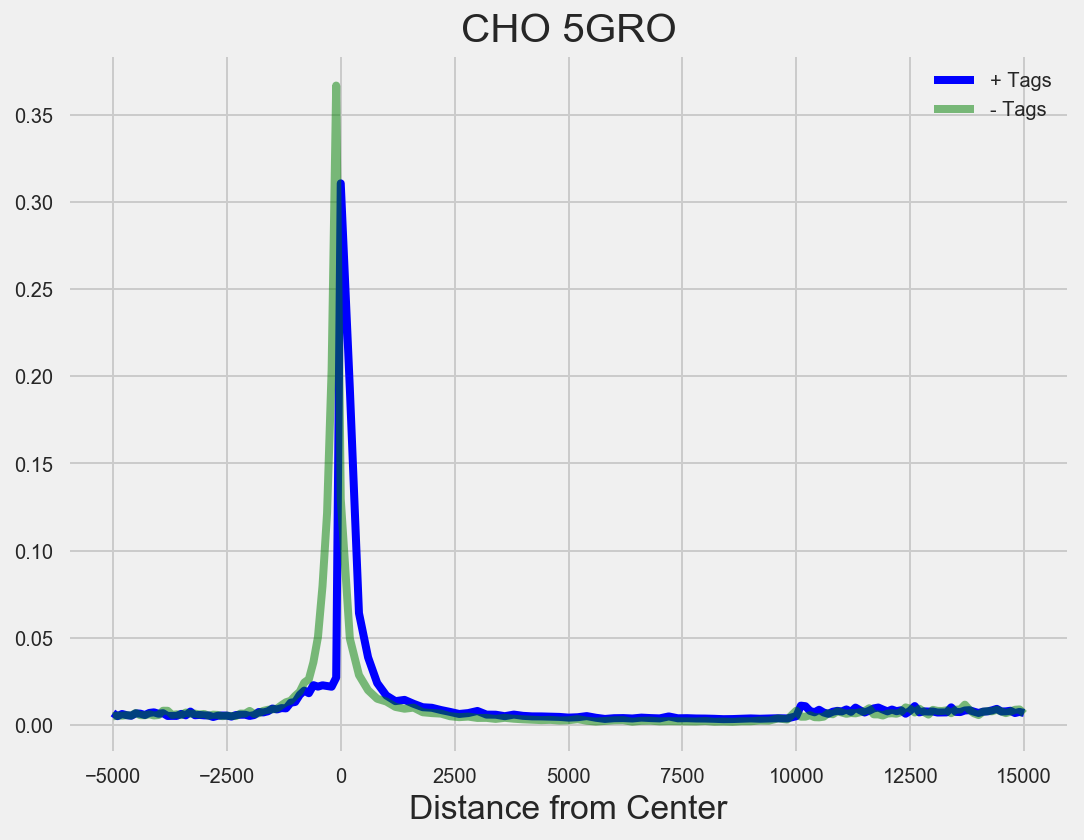

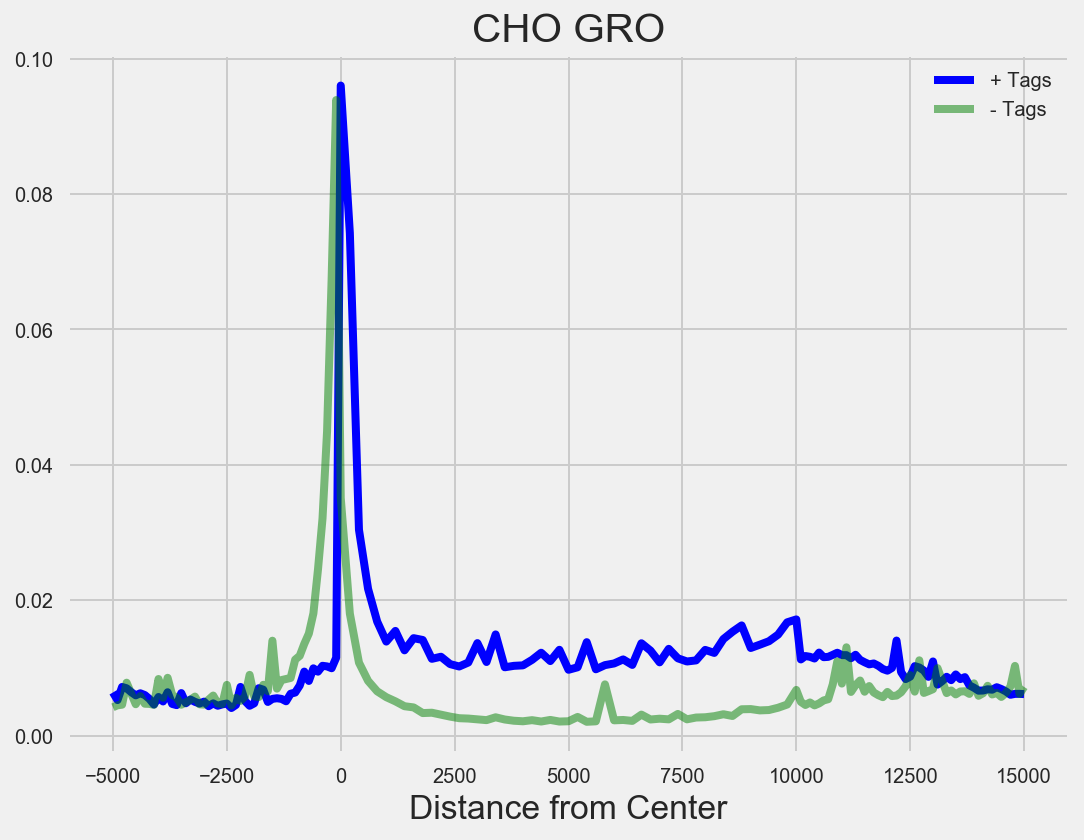

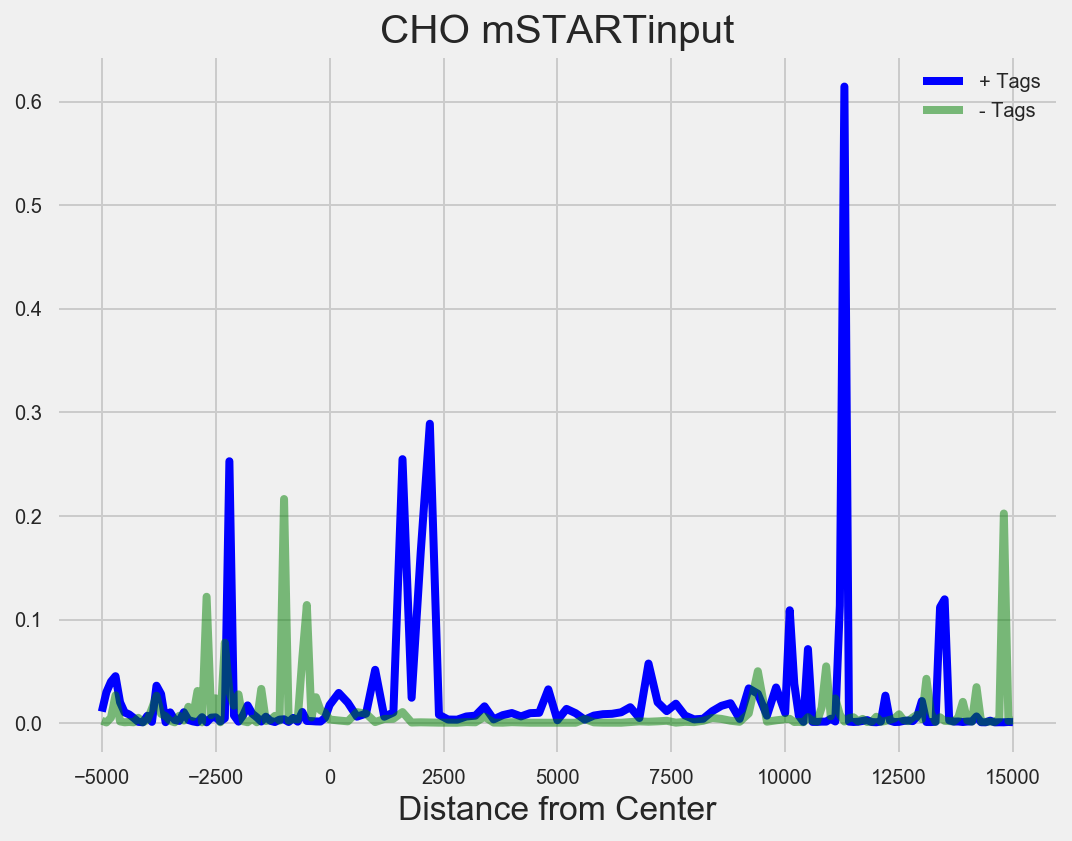

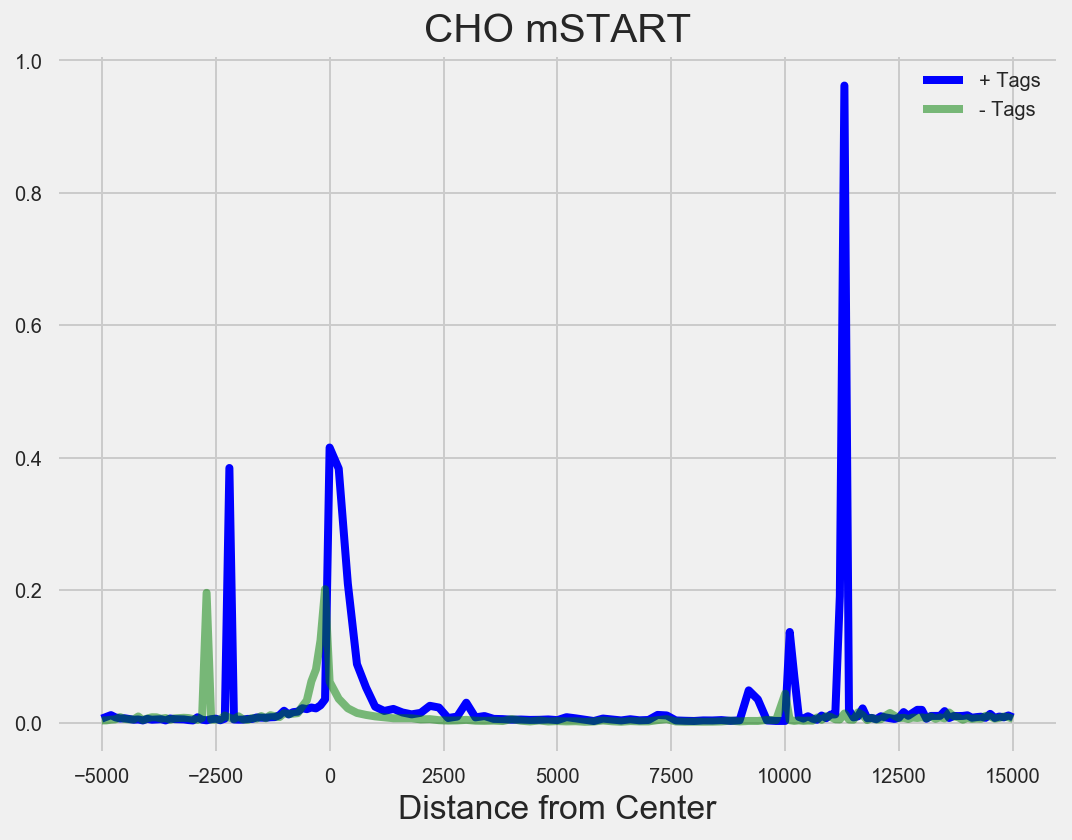

In [9]:
for t in tissues:    
    out_dir = os.path.join(save_dir, t)

    for s in ['GRO', 'mSTART']:
        curr = (os.path.join(data_folder, t, s,'f03_tags'))
        for f in glob.glob(curr + '/*'):
            in_file = f

            out_file = os.path.join(out_dir, os.path.basename(f).replace('trim_','').partition('_SD')[0])

            
            metagene = pd.read_csv(out_file,sep='\t')
            cols = metagene.columns
            cols = ['Distance from Center','Coverage','+ Tags','- Tags']
            metagene.columns = cols
            f = plt.figure()
            ax = metagene.plot('Distance from Center' ,'+ Tags')
            metagene.plot('Distance from Center','- Tags',ax=ax,alpha=0.5)
            
            if s == 'mSTART' and 'input' in os.path.basename(out_file):
                plt.title(t + ' mSTARTinput')
                
            elif s == 'GRO' and '5GRO' in os.path.basename(out_file):
                plt.title(t + ' 5GRO')
            else:
                plt.title(t + ' ' + s)
            plt.savefig(out_file + '.png')

## Example with CHO

In [9]:
peak_file = '/data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv'
tag_file = '../Processed/CHO/GRO/f03_tags/trim_CHO-5GRO-SD367_S6_R1_001.fastq'
out_file = 'Results/metaGene/trim_CHO-5GRO-SD367_S6_R1_001'


Text(0.5,1,u'CHO GRO')

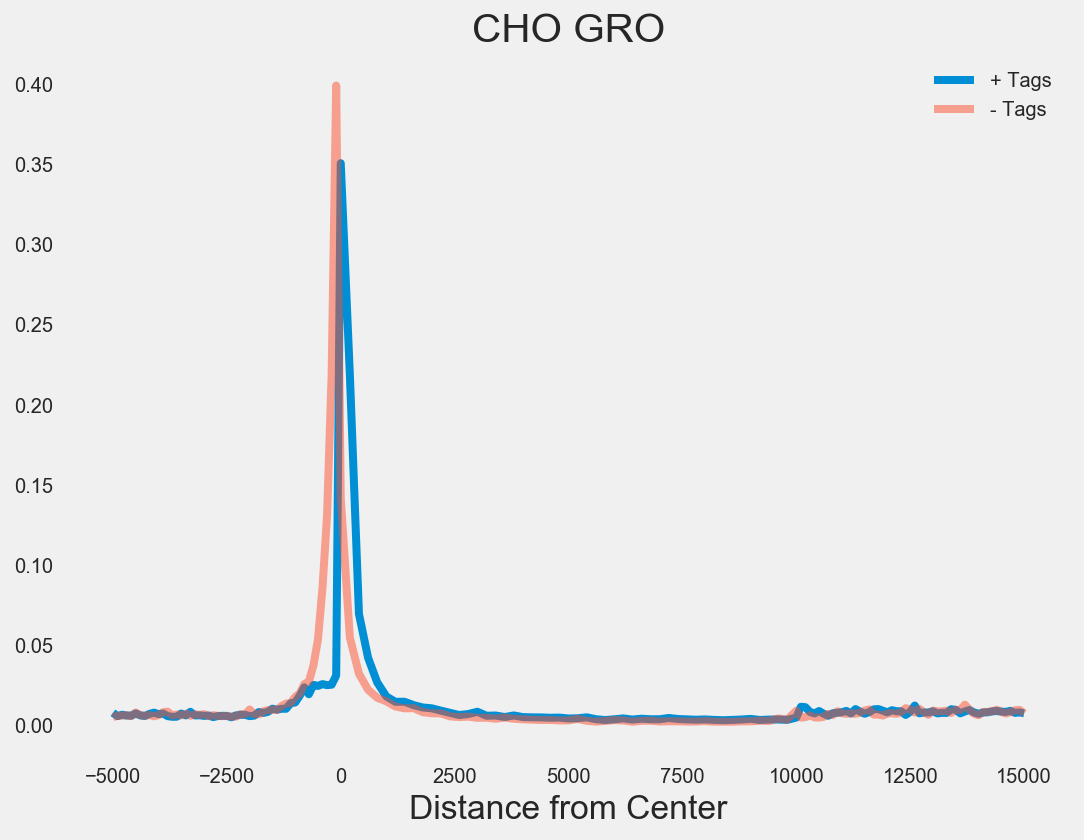

In [28]:
cho_metagene = pd.read_csv('Results/metaGene/trim_CHO-5GRO-SD367_S6_R1_001_bg',sep='\t')
cols = cho_metagene.columns
cols = ['Distance from Center','Coverage','+ Tags','- Tags']
cho_metagene.columns = cols

f = plt.figure()
ax = cho_metagene.plot('Distance from Center' ,'+ Tags')
cho_metagene.plot('Distance from Center','- Tags',ax=ax,alpha=0.5)
plt.title(t + ' ' + seq)

## Instead of tags use peaks

In [22]:
## Use peaks instead of tags
tag_file = '../Processed/CHO/GRO/f04_peaks/merge_bg_2.peak'
out_file = 'Results/metaGene/trim_CHO-5GRO-SD367_S6_R1_001_PEAK'


cmd = 'makeMetaGeneProfile.pl %s %s -gff3 %s -p %s -min 200 > %s' % (gene_set,org,annotation,tag_file,out_file)

print(cmd)
!{cmd}

makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/CHO/GRO/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGene/trim_CHO-5GRO-SD367_S6_R1_001_PEAK
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks

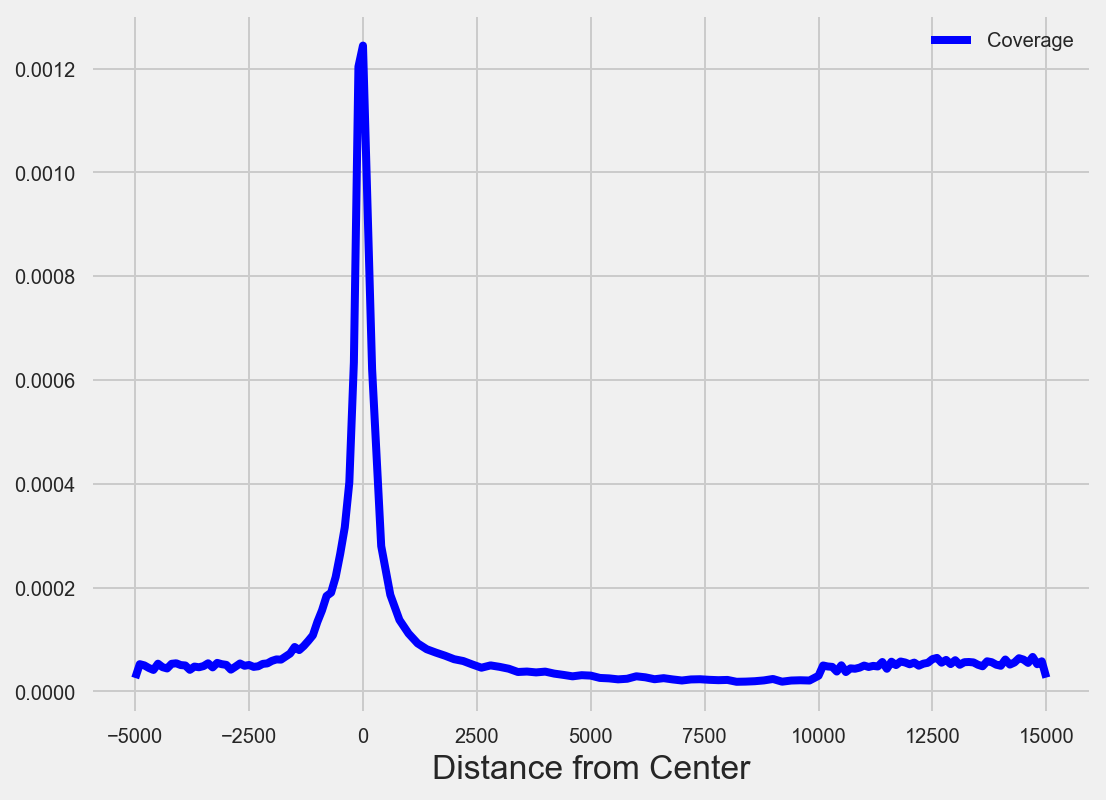

In [26]:
metagene = pd.read_csv(out_file,sep='\t')
cols = metagene.columns
cols = ['Distance from Center','Coverage']#,'+ Tags','- Tags']
metagene.columns = cols
f = plt.figure()
ax = metagene.plot('Distance from Center' ,'Coverage')




In [24]:
metagene

Distance from Center (cmd=annotatePeaks.pl 0.746241543748514.2.tmp ch -size 10000 -hist 100 -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/CHO/GRO/f04_peaks/merge_bg_2.peak)  \
0                                                -5000                                                                                                                                                    
1                                                -4900                                                                                                                                                    
2                                                -4800                                                                                                                                                    
3                                                -4700                                                                                                                                                    
4                                                -4600                                                                                                                                                    
5                                                -4500                                                                                                                                                    
6                                                -4400                                                                                                                                                    
7                                                -4300                                                                                                                                                    
8                                                -4200                                                                                                                                                    
9                                                -4100                                                                                                                                                    
10                                               -4000                                                                                                                                                    
11                                               -3900                                                                                                                                                    
12                                               -3800                                                                                                                                                    
13                                               -3700                                                                                                                                                    
14                                               -3600                                                                                                                                                    
15                                               -3500                                                                                                                                                    
16                                               -3400                                                                                                                                                    
17                                               -3300                                                                                                                                                    
18                                               -3200                                                                                              

In [16]:
!ls {tag_file}

ls: cannot access '../Processed/CHO/GRO/f04_peaks/_peaks/merge_bg_2.peak': No such file or directory


In [7]:
def run_metaGene_peaks(t,save_dir,org,gene_set,annotation,data_folder):

    for t in tissues:    
        #(save_dir,org,gene_set,annotation,data_folder) = (f_args)

        out_dir = os.path.join(save_dir, t)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        for s in ['GRO', 'mSTART']:
            f = (os.path.join(data_folder, t, s,'f04_peaks','merge_bg_2.peak'))
            print(f)
            if os.path.exists(f):
                in_file = f

                out_file = os.path.join(out_dir, os.path.basename(f).replace('trim_','').partition('_SD')[0])

                cmd = 'makeMetaGeneProfile.pl %s %s -gff3 %s -p %s -min 200 > %s' % (
                    gene_set, org, annotation, in_file, out_file)

                print(cmd)
                !{cmd}

    return 

In [ ]:
save_dir = 'Results/metaGenePeaks'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
org = 'ch'
gene_set = '/data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv'
pf.parallel_ar(np.array(tissues),run_metaGene_peaks,func_args=(save_dir,org,gene_set,annotation,data_folder))

../Processed/BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/mSTART/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/mSTART/f04_peaks/merge_bg_2.peak
../Processed/BMDM1hKLA1/mSTART/f04_peaks/merge_bg_2.peak
../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak
../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGenePeaks/BMDMwt/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak -min 200 > 

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with 


	Peak file = 0.0479577258965982.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak

	Peak file = 0.431163710382865.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		R


	Peak file = 0.942721475455077.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Brain/GRO/f04_peaks/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Resizing peaks...
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGenePeaks/Brain/merge_bg_2.peak
../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGenePeaks/Brain/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	Reading Positions...
	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak
	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak
	Peak/BE


	Peak file = 0.868087950236262.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizin

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header 


	Peak file = 0.299551337565394.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Heart/mSTART/f04_peaks/merge_bg_2.peak
	Resizing peaks...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:


../Processed/Intestine/mSTART/f04_peaks/merge_bg_2.peak
../Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGenePeaks/Kidney/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (


	Peak file = 0.607748771625669.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Reading Positions...

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Kidney/GRO/f0

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Resizing peaks...
	Resizing peaks...

	Peak file = 0.607748771625669.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	----------------------------------------


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 

	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0
	Resizing peaks...

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	Reading Positions...
	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Kidney/mSTART/f04_peaks/merge_bg_2.peak
	-----------------------
	Finding nearby peaks in ../Processed/Kidney/mSTA


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
../Processed/Liver/GRO/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/Liver/GRO/f04_peaks/merge_bg_2.peak -min 200 > Results/metaGenePeaks/Liver/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Liver/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50533
		Duplicated Peak IDs: 2
	-----------------------
	Finding nearby peaks in ../Processed/Liver/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50533
		Duplicated Peak IDs: 2
	Reading Positions...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50533
		Duplicated Peak IDs: 2
	-----------------------
	Finding nearby peaks in ../Processed/Liver/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50533
		Duplicated Peak IDs: 2
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...



	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	Reading Positions...
	Resizing peaks...
	-----------------------
	Finding nearby peaks in ../Processed/Liver/GRO/f04_peaks/merge_bg_


	Peak file = 0.753360721356334.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Liver/mSTART/f04_peaks/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File St

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 8541
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 8541
		Duplicated Peak IDs: 0
	Reading Positions...
	Reading Positions...
	-----------------------
	Finding nearby peaks in ../Processed/Liver/mSTART/f04_peaks/merge_bg_2.peak
	-----------------------
	Finding nearby peaks in ../Processed/Liver/mSTART/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 8541
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 8541
		Duplicated Peak IDs: 0
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...



	Peak file = 0.509114905799837.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000



	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 


	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Compiling per % Histograms...
	Finding Tags in Peaks from each directory...
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52228
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.395654517765255.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Lung/GRO/f04_peaks/merge_bg_2.peak
	Resizing peaks...

	-----------------------
	Finding nearby peaks in ../Processed/Lung/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 68485
		Duplicated Peak IDs: 6
	-----------------------
	Finding nearby peaks in ../Processed/Lung/GRO/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 68485
		Duplicated Peak IDs: 6
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 68485
		Duplicated Peak IDs: 6
	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...

	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...

../Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak
makeMetaGeneProfile.pl /data/isshamie/genome/start_site_mRNA_updated_final_sort_homer.tsv ch -gff3 /data/isshamie/genome/updated_final_sort.gff3 -p ../Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak -min 200 > Results

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak file = 0.955109980031015.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	-----------------------------------------------------
	Histogram mode activated (bin size = 1/50)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.197332295895652.1.tmp
	Genome = ch
	Organism = null
	Using actual sizes of regions
	Peak Region set to given
	---------------

	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...

	Peak file = 0.140691775436611.3.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52229
		Duplicated Peak IDs: 0

	Compiling per bp Histograms...
	Finding Tags in Peaks from each directory...

	Peak File Statistics:
		Total Peaks: 52229
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak/BED fi

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak File Statistics:
		Total Peaks: 52382
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 52382
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 52382
		R



	Peak File Statistics:
		Total Peaks: 52228
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!



	Peak file = 0.772565723004849.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3 file: /data/isshamie/genome/updated_final_sort.gff3 (better to get GTF file)
	Peak Files:
		../Processed/Muscle/mSTART/f04_peaks/merge_bg_2.peak
	Resizing peaks...

	Peak file = 0.582769014247791.2.tmp
	Genome = ch
	Organism = null
	Peak Region set to 10000
	-----------------------------------------------------
	Histogram mode activated (bin size = 100 bp)
	-----------------------------------------------------
	Custom annotation GFF3

In [ ]:
for t in tissues:    
    out_dir = os.path.join(save_dir, t)

    for s in ['GRO', 'mSTART']:
        f = (os.path.join(data_folder, t, s,'f04_peaks','merge_bg_2.peak'))
        
        in_file = f

        out_file = os.path.join(out_dir, f)

        metagene = pd.read_csv(out_file,sep='\t')
        cols = metagene.columns
        cols = ['Distance from Center','Coverage']#,'+ Tags','- Tags']
        metagene.columns = cols
        f = plt.figure()
        ax = metagene.plot('Distance from Center' ,'Coverage')

        if s == 'mSTART' and 'input' in os.path.basename(out_file):
            plt.title(t + ' mSTARTinput')

        elif s == 'GRO' and '5GRO' in os.path.basename(out_file):
            plt.title(t + ' 5GRO')
        else:
            plt.title(t + ' ' + s)
        plt.savefig(out_file + '.png')